## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1096, 715)
Hypercube shape: (1096, 715, 102)


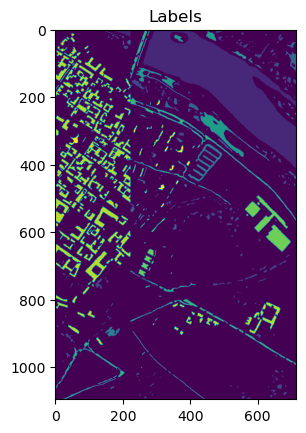

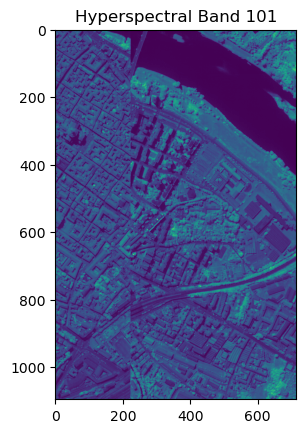

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Pavia_gt.mat'
data_files = 'Pavia.mat'
label_files = 'pavia_gt'
hypercube_files = 'pavia'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 148152
Extracted windows shape: (148152, 5, 5, 102)
Corresponding labels shape: (148152,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 65971 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 7598 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 3090 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 2685 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 6584 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 9248 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 7287 samples
Shuffled class indices for class '7'
Selected 10 train


 -- Test set created with: 
	148017 samples
	shape (148017, 5, 5, 102) --




All datasets saved to the 'indices' folder.
(90, 5, 5, 102)
(45, 5, 5, 102)
(148017, 5, 5, 102)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 90
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (118521, 5, 5, 102)
Validation data shape: (29631, 5, 5, 102)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

102


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/1852], Loss: 0.1719, PSNR: 4.5147


	 Training Batch [200/1852], Loss: 0.0970, PSNR: 6.4769


	 Training Batch [400/1852], Loss: 0.0453, PSNR: 9.1280


	 Training Batch [600/1852], Loss: 0.0247, PSNR: 11.1522


	 Training Batch [800/1852], Loss: 0.0165, PSNR: 13.9224


	 Training Batch [1000/1852], Loss: 0.0114, PSNR: 17.0482


	 Training Batch [1200/1852], Loss: 0.0089, PSNR: 17.3815


	 Training Batch [1400/1852], Loss: 0.0076, PSNR: 16.0124


	 Training Batch [1600/1852], Loss: 0.0074, PSNR: 18.2202


	 Training Batch [1800/1852], Loss: 0.0057, PSNR: 17.9909


Epoch [1/50] Training Loss: 0.0330, PSNR: 13.6674
	[Val]   Batch [1/463] Loss: 0.0052, PSNR: 18.0781
	[Val]   Batch [10/463] Loss: 0.0048, PSNR: 19.2865
	[Val]   Batch [20/463] Loss: 0.0048, PSNR: 18.3037
	[Val]   Batch [30/463] Loss: 0.0059, PSNR: 18.7984
	[Val]   Batch [40/463] Loss: 0.0046, PSNR: 17.9863
	[Val]   Batch [50/463] Loss: 0.0048, PSNR: 18.2019


	[Val]   Batch [60/463] Loss: 0.0046, PSNR: 18.2304
	[Val]   Batch [70/463] Loss: 0.0066, PSNR: 18.5396
	[Val]   Batch [80/463] Loss: 0.0058, PSNR: 20.4725
	[Val]   Batch [90/463] Loss: 0.0056, PSNR: 19.5642
	[Val]   Batch [100/463] Loss: 0.0057, PSNR: 19.2516
	[Val]   Batch [110/463] Loss: 0.0066, PSNR: 18.6622
	[Val]   Batch [120/463] Loss: 0.0044, PSNR: 18.2331
	[Val]   Batch [130/463] Loss: 0.0053, PSNR: 19.5770


	[Val]   Batch [140/463] Loss: 0.0062, PSNR: 19.1243
	[Val]   Batch [150/463] Loss: 0.0071, PSNR: 19.1512
	[Val]   Batch [160/463] Loss: 0.0056, PSNR: 19.4257
	[Val]   Batch [170/463] Loss: 0.0074, PSNR: 18.3086
	[Val]   Batch [180/463] Loss: 0.0053, PSNR: 19.1601
	[Val]   Batch [190/463] Loss: 0.0057, PSNR: 19.5091
	[Val]   Batch [200/463] Loss: 0.0057, PSNR: 18.8939
	[Val]   Batch [210/463] Loss: 0.0056, PSNR: 18.4565


	[Val]   Batch [220/463] Loss: 0.0055, PSNR: 19.6593
	[Val]   Batch [230/463] Loss: 0.0065, PSNR: 19.4976
	[Val]   Batch [240/463] Loss: 0.0049, PSNR: 18.3359
	[Val]   Batch [250/463] Loss: 0.0063, PSNR: 17.4937
	[Val]   Batch [260/463] Loss: 0.0055, PSNR: 18.5184
	[Val]   Batch [270/463] Loss: 0.0041, PSNR: 17.7681


	[Val]   Batch [280/463] Loss: 0.0052, PSNR: 20.4117
	[Val]   Batch [290/463] Loss: 0.0057, PSNR: 17.4019
	[Val]   Batch [300/463] Loss: 0.0057, PSNR: 19.6760
	[Val]   Batch [310/463] Loss: 0.0053, PSNR: 19.5610
	[Val]   Batch [320/463] Loss: 0.0054, PSNR: 19.4224
	[Val]   Batch [330/463] Loss: 0.0063, PSNR: 18.8207
	[Val]   Batch [340/463] Loss: 0.0051, PSNR: 19.7779


	[Val]   Batch [350/463] Loss: 0.0068, PSNR: 19.6508
	[Val]   Batch [360/463] Loss: 0.0045, PSNR: 20.6680
	[Val]   Batch [370/463] Loss: 0.0067, PSNR: 18.7232
	[Val]   Batch [380/463] Loss: 0.0065, PSNR: 18.8908
	[Val]   Batch [390/463] Loss: 0.0060, PSNR: 18.7142
	[Val]   Batch [400/463] Loss: 0.0053, PSNR: 17.7594
	[Val]   Batch [410/463] Loss: 0.0051, PSNR: 20.1186
	[Val]   Batch [420/463] Loss: 0.0053, PSNR: 18.8973


	[Val]   Batch [430/463] Loss: 0.0052, PSNR: 18.2951
	[Val]   Batch [440/463] Loss: 0.0052, PSNR: 19.2794
	[Val]   Batch [450/463] Loss: 0.0039, PSNR: 16.7186
	[Val]   Batch [460/463] Loss: 0.0056, PSNR: 18.0391
Epoch [1/50] Validation Loss: 0.0055, PSNR: 18.8620

LOG: Epoch [2/50]
	 Training Batch [1/1852], Loss: 0.0052, PSNR: 21.3477


	 Training Batch [200/1852], Loss: 0.0050, PSNR: 18.3872


	 Training Batch [400/1852], Loss: 0.0047, PSNR: 19.2070


	 Training Batch [600/1852], Loss: 0.0041, PSNR: 21.0911


	 Training Batch [800/1852], Loss: 0.0048, PSNR: 20.0827


	 Training Batch [1000/1852], Loss: 0.0038, PSNR: 19.7686


	 Training Batch [1200/1852], Loss: 0.0027, PSNR: 19.6726


	 Training Batch [1400/1852], Loss: 0.0038, PSNR: 21.6599


	 Training Batch [1600/1852], Loss: 0.0027, PSNR: 22.2621


	 Training Batch [1800/1852], Loss: 0.0031, PSNR: 22.8012


Epoch [2/50] Training Loss: 0.0043, PSNR: 20.1697
	[Val]   Batch [1/463] Loss: 0.0024, PSNR: 21.4639
	[Val]   Batch [10/463] Loss: 0.0022, PSNR: 22.6803
	[Val]   Batch [20/463] Loss: 0.0022, PSNR: 21.7753
	[Val]   Batch [30/463] Loss: 0.0027, PSNR: 22.2000
	[Val]   Batch [40/463] Loss: 0.0022, PSNR: 21.2068
	[Val]   Batch [50/463] Loss: 0.0023, PSNR: 21.4667
	[Val]   Batch [60/463] Loss: 0.0022, PSNR: 21.5128


	[Val]   Batch [70/463] Loss: 0.0031, PSNR: 21.8561
	[Val]   Batch [80/463] Loss: 0.0027, PSNR: 23.7307
	[Val]   Batch [90/463] Loss: 0.0026, PSNR: 22.9742
	[Val]   Batch [100/463] Loss: 0.0028, PSNR: 22.4315
	[Val]   Batch [110/463] Loss: 0.0031, PSNR: 22.0095
	[Val]   Batch [120/463] Loss: 0.0021, PSNR: 21.4383
	[Val]   Batch [130/463] Loss: 0.0024, PSNR: 23.0733


	[Val]   Batch [140/463] Loss: 0.0029, PSNR: 22.3880
	[Val]   Batch [150/463] Loss: 0.0031, PSNR: 22.6769
	[Val]   Batch [160/463] Loss: 0.0028, PSNR: 22.4393
	[Val]   Batch [170/463] Loss: 0.0035, PSNR: 21.5588
	[Val]   Batch [180/463] Loss: 0.0026, PSNR: 22.1602
	[Val]   Batch [190/463] Loss: 0.0026, PSNR: 22.9362
	[Val]   Batch [200/463] Loss: 0.0027, PSNR: 22.1989


	[Val]   Batch [210/463] Loss: 0.0028, PSNR: 21.4276
	[Val]   Batch [220/463] Loss: 0.0027, PSNR: 22.7880
	[Val]   Batch [230/463] Loss: 0.0028, PSNR: 23.1199
	[Val]   Batch [240/463] Loss: 0.0023, PSNR: 21.6296
	[Val]   Batch [250/463] Loss: 0.0030, PSNR: 20.6939
	[Val]   Batch [260/463] Loss: 0.0026, PSNR: 21.7134
	[Val]   Batch [270/463] Loss: 0.0019, PSNR: 21.0656


	[Val]   Batch [280/463] Loss: 0.0024, PSNR: 23.6927
	[Val]   Batch [290/463] Loss: 0.0026, PSNR: 20.7968
	[Val]   Batch [300/463] Loss: 0.0027, PSNR: 22.9036
	[Val]   Batch [310/463] Loss: 0.0027, PSNR: 22.4538
	[Val]   Batch [320/463] Loss: 0.0026, PSNR: 22.6274
	[Val]   Batch [330/463] Loss: 0.0028, PSNR: 22.3417
	[Val]   Batch [340/463] Loss: 0.0024, PSNR: 23.0033
	[Val]   Batch [350/463] Loss: 0.0033, PSNR: 22.7585


	[Val]   Batch [360/463] Loss: 0.0024, PSNR: 23.4243
	[Val]   Batch [370/463] Loss: 0.0030, PSNR: 22.1921
	[Val]   Batch [380/463] Loss: 0.0028, PSNR: 22.5644
	[Val]   Batch [390/463] Loss: 0.0026, PSNR: 22.2824
	[Val]   Batch [400/463] Loss: 0.0026, PSNR: 20.8988
	[Val]   Batch [410/463] Loss: 0.0023, PSNR: 23.5363
	[Val]   Batch [420/463] Loss: 0.0024, PSNR: 22.3163


	[Val]   Batch [430/463] Loss: 0.0026, PSNR: 21.3670
	[Val]   Batch [440/463] Loss: 0.0025, PSNR: 22.3800
	[Val]   Batch [450/463] Loss: 0.0020, PSNR: 19.7266
	[Val]   Batch [460/463] Loss: 0.0026, PSNR: 21.4048
Epoch [2/50] Validation Loss: 0.0026, PSNR: 22.1649

LOG: Epoch [3/50]
	 Training Batch [1/1852], Loss: 0.0031, PSNR: 21.5677


	 Training Batch [200/1852], Loss: 0.0033, PSNR: 21.3046


	 Training Batch [400/1852], Loss: 0.0026, PSNR: 21.7921


	 Training Batch [600/1852], Loss: 0.0030, PSNR: 22.0912


	 Training Batch [800/1852], Loss: 0.0026, PSNR: 23.0627


	 Training Batch [1000/1852], Loss: 0.0027, PSNR: 23.8299


	 Training Batch [1200/1852], Loss: 0.0015, PSNR: 24.3824


	 Training Batch [1400/1852], Loss: 0.0016, PSNR: 23.8858


	 Training Batch [1600/1852], Loss: 0.0016, PSNR: 24.3594


	 Training Batch [1800/1852], Loss: 0.0015, PSNR: 23.6538


Epoch [3/50] Training Loss: 0.0022, PSNR: 22.9498
	[Val]   Batch [1/463] Loss: 0.0015, PSNR: 23.4771
	[Val]   Batch [10/463] Loss: 0.0014, PSNR: 24.7960
	[Val]   Batch [20/463] Loss: 0.0013, PSNR: 23.9586
	[Val]   Batch [30/463] Loss: 0.0016, PSNR: 24.4209
	[Val]   Batch [40/463] Loss: 0.0014, PSNR: 23.0557


	[Val]   Batch [50/463] Loss: 0.0014, PSNR: 23.4874
	[Val]   Batch [60/463] Loss: 0.0014, PSNR: 23.4470
	[Val]   Batch [70/463] Loss: 0.0018, PSNR: 24.1495
	[Val]   Batch [80/463] Loss: 0.0016, PSNR: 26.2075
	[Val]   Batch [90/463] Loss: 0.0016, PSNR: 25.1000
	[Val]   Batch [100/463] Loss: 0.0017, PSNR: 24.5917
	[Val]   Batch [110/463] Loss: 0.0018, PSNR: 24.3537


	[Val]   Batch [120/463] Loss: 0.0014, PSNR: 23.3127
	[Val]   Batch [130/463] Loss: 0.0014, PSNR: 25.3827
	[Val]   Batch [140/463] Loss: 0.0018, PSNR: 24.5607
	[Val]   Batch [150/463] Loss: 0.0017, PSNR: 25.2720
	[Val]   Batch [160/463] Loss: 0.0018, PSNR: 24.3932
	[Val]   Batch [170/463] Loss: 0.0022, PSNR: 23.6378


	[Val]   Batch [180/463] Loss: 0.0017, PSNR: 24.1427
	[Val]   Batch [190/463] Loss: 0.0015, PSNR: 25.1951
	[Val]   Batch [200/463] Loss: 0.0015, PSNR: 24.6671
	[Val]   Batch [210/463] Loss: 0.0018, PSNR: 23.2925
	[Val]   Batch [220/463] Loss: 0.0017, PSNR: 24.7247
	[Val]   Batch [230/463] Loss: 0.0015, PSNR: 25.7804
	[Val]   Batch [240/463] Loss: 0.0014, PSNR: 23.7248


	[Val]   Batch [250/463] Loss: 0.0020, PSNR: 22.6185
	[Val]   Batch [260/463] Loss: 0.0017, PSNR: 23.6525
	[Val]   Batch [270/463] Loss: 0.0012, PSNR: 23.0719
	[Val]   Batch [280/463] Loss: 0.0015, PSNR: 25.7483
	[Val]   Batch [290/463] Loss: 0.0016, PSNR: 22.8892
	[Val]   Batch [300/463] Loss: 0.0017, PSNR: 24.9459


	[Val]   Batch [310/463] Loss: 0.0018, PSNR: 24.3617
	[Val]   Batch [320/463] Loss: 0.0016, PSNR: 24.7703
	[Val]   Batch [330/463] Loss: 0.0016, PSNR: 24.7361
	[Val]   Batch [340/463] Loss: 0.0015, PSNR: 25.1075
	[Val]   Batch [350/463] Loss: 0.0020, PSNR: 24.9213
	[Val]   Batch [360/463] Loss: 0.0017, PSNR: 24.8688
	[Val]   Batch [370/463] Loss: 0.0018, PSNR: 24.4270


	[Val]   Batch [380/463] Loss: 0.0015, PSNR: 25.1404
	[Val]   Batch [390/463] Loss: 0.0015, PSNR: 24.7399
	[Val]   Batch [400/463] Loss: 0.0017, PSNR: 22.7242
	[Val]   Batch [410/463] Loss: 0.0014, PSNR: 25.7165
	[Val]   Batch [420/463] Loss: 0.0015, PSNR: 24.4611
	[Val]   Batch [430/463] Loss: 0.0017, PSNR: 23.1724
	[Val]   Batch [440/463] Loss: 0.0016, PSNR: 24.3123


	[Val]   Batch [450/463] Loss: 0.0013, PSNR: 21.4446
	[Val]   Batch [460/463] Loss: 0.0016, PSNR: 23.5264
Epoch [3/50] Validation Loss: 0.0016, PSNR: 24.3100

LOG: Epoch [4/50]
	 Training Batch [1/1852], Loss: 0.0018, PSNR: 25.3018


	 Training Batch [200/1852], Loss: 0.0015, PSNR: 24.3732


	 Training Batch [400/1852], Loss: 0.0018, PSNR: 24.5138


	 Training Batch [600/1852], Loss: 0.0017, PSNR: 23.5402


	 Training Batch [800/1852], Loss: 0.0016, PSNR: 24.1169


	 Training Batch [1000/1852], Loss: 0.0012, PSNR: 23.5806


	 Training Batch [1200/1852], Loss: 0.0013, PSNR: 24.1325


	 Training Batch [1400/1852], Loss: 0.0013, PSNR: 25.1465


	 Training Batch [1600/1852], Loss: 0.0013, PSNR: 25.7763


	 Training Batch [1800/1852], Loss: 0.0012, PSNR: 25.6776


Epoch [4/50] Training Loss: 0.0016, PSNR: 24.4802
	[Val]   Batch [1/463] Loss: 0.0011, PSNR: 24.6940
	[Val]   Batch [10/463] Loss: 0.0010, PSNR: 26.0705
	[Val]   Batch [20/463] Loss: 0.0010, PSNR: 25.2397
	[Val]   Batch [30/463] Loss: 0.0012, PSNR: 25.6334
	[Val]   Batch [40/463] Loss: 0.0011, PSNR: 24.2076
	[Val]   Batch [50/463] Loss: 0.0011, PSNR: 24.7521
	[Val]   Batch [60/463] Loss: 0.0010, PSNR: 24.6541


	[Val]   Batch [70/463] Loss: 0.0014, PSNR: 25.3912
	[Val]   Batch [80/463] Loss: 0.0011, PSNR: 27.6335
	[Val]   Batch [90/463] Loss: 0.0012, PSNR: 26.3429
	[Val]   Batch [100/463] Loss: 0.0012, PSNR: 25.8740
	[Val]   Batch [110/463] Loss: 0.0013, PSNR: 25.6951
	[Val]   Batch [120/463] Loss: 0.0010, PSNR: 24.5700
	[Val]   Batch [130/463] Loss: 0.0010, PSNR: 26.6734


	[Val]   Batch [140/463] Loss: 0.0013, PSNR: 25.7642
	[Val]   Batch [150/463] Loss: 0.0013, PSNR: 26.6103
	[Val]   Batch [160/463] Loss: 0.0014, PSNR: 25.5542
	[Val]   Batch [170/463] Loss: 0.0017, PSNR: 24.7709
	[Val]   Batch [180/463] Loss: 0.0013, PSNR: 25.3221
	[Val]   Batch [190/463] Loss: 0.0012, PSNR: 26.4467
	[Val]   Batch [200/463] Loss: 0.0011, PSNR: 26.0449


	[Val]   Batch [210/463] Loss: 0.0014, PSNR: 24.4587
	[Val]   Batch [220/463] Loss: 0.0013, PSNR: 25.9072
	[Val]   Batch [230/463] Loss: 0.0011, PSNR: 27.1365
	[Val]   Batch [240/463] Loss: 0.0010, PSNR: 25.0223
	[Val]   Batch [250/463] Loss: 0.0015, PSNR: 23.7313
	[Val]   Batch [260/463] Loss: 0.0013, PSNR: 24.7969
	[Val]   Batch [270/463] Loss: 0.0009, PSNR: 24.4089


	[Val]   Batch [280/463] Loss: 0.0011, PSNR: 26.9957
	[Val]   Batch [290/463] Loss: 0.0012, PSNR: 24.1312
	[Val]   Batch [300/463] Loss: 0.0013, PSNR: 26.0842
	[Val]   Batch [310/463] Loss: 0.0013, PSNR: 25.5905
	[Val]   Batch [320/463] Loss: 0.0012, PSNR: 26.0914
	[Val]   Batch [330/463] Loss: 0.0012, PSNR: 26.0230
	[Val]   Batch [340/463] Loss: 0.0011, PSNR: 26.3697


	[Val]   Batch [350/463] Loss: 0.0015, PSNR: 26.1245
	[Val]   Batch [360/463] Loss: 0.0014, PSNR: 25.8433
	[Val]   Batch [370/463] Loss: 0.0013, PSNR: 25.6769
	[Val]   Batch [380/463] Loss: 0.0011, PSNR: 26.5179
	[Val]   Batch [390/463] Loss: 0.0011, PSNR: 26.0594
	[Val]   Batch [400/463] Loss: 0.0013, PSNR: 23.8562
	[Val]   Batch [410/463] Loss: 0.0010, PSNR: 27.0277


	[Val]   Batch [420/463] Loss: 0.0011, PSNR: 25.6474
	[Val]   Batch [430/463] Loss: 0.0013, PSNR: 24.2838
	[Val]   Batch [440/463] Loss: 0.0012, PSNR: 25.5055
	[Val]   Batch [450/463] Loss: 0.0010, PSNR: 22.6693
	[Val]   Batch [460/463] Loss: 0.0012, PSNR: 24.7137
Epoch [4/50] Validation Loss: 0.0012, PSNR: 25.5678

LOG: Epoch [5/50]
	 Training Batch [1/1852], Loss: 0.0014, PSNR: 24.9603


	 Training Batch [200/1852], Loss: 0.0011, PSNR: 25.2388


	 Training Batch [400/1852], Loss: 0.0014, PSNR: 24.6239


	 Training Batch [600/1852], Loss: 0.0010, PSNR: 26.1424


	 Training Batch [800/1852], Loss: 0.0026, PSNR: 23.0503


	 Training Batch [1000/1852], Loss: 0.0014, PSNR: 23.9824


	 Training Batch [1200/1852], Loss: 0.0012, PSNR: 26.1724


	 Training Batch [1400/1852], Loss: 0.0011, PSNR: 24.1751


	 Training Batch [1600/1852], Loss: 0.0009, PSNR: 27.8805


	 Training Batch [1800/1852], Loss: 0.0011, PSNR: 26.4954


Epoch [5/50] Training Loss: 0.0012, PSNR: 25.4549
	[Val]   Batch [1/463] Loss: 0.0009, PSNR: 25.7643
	[Val]   Batch [10/463] Loss: 0.0008, PSNR: 27.0984
	[Val]   Batch [20/463] Loss: 0.0008, PSNR: 26.3251
	[Val]   Batch [30/463] Loss: 0.0009, PSNR: 26.7599
	[Val]   Batch [40/463] Loss: 0.0009, PSNR: 25.1766
	[Val]   Batch [50/463] Loss: 0.0008, PSNR: 25.8143
	[Val]   Batch [60/463] Loss: 0.0008, PSNR: 25.6416


	[Val]   Batch [70/463] Loss: 0.0010, PSNR: 26.5156
	[Val]   Batch [80/463] Loss: 0.0008, PSNR: 28.8755
	[Val]   Batch [90/463] Loss: 0.0009, PSNR: 27.4867
	[Val]   Batch [100/463] Loss: 0.0010, PSNR: 26.9918
	[Val]   Batch [110/463] Loss: 0.0010, PSNR: 26.9249
	[Val]   Batch [120/463] Loss: 0.0008, PSNR: 25.5939
	[Val]   Batch [130/463] Loss: 0.0008, PSNR: 27.7996
	[Val]   Batch [140/463] Loss: 0.0010, PSNR: 26.9203


	[Val]   Batch [150/463] Loss: 0.0010, PSNR: 27.8365
	[Val]   Batch [160/463] Loss: 0.0011, PSNR: 26.5238
	[Val]   Batch [170/463] Loss: 0.0013, PSNR: 25.8623
	[Val]   Batch [180/463] Loss: 0.0010, PSNR: 26.3620
	[Val]   Batch [190/463] Loss: 0.0009, PSNR: 27.4895
	[Val]   Batch [200/463] Loss: 0.0008, PSNR: 27.2316
	[Val]   Batch [210/463] Loss: 0.0011, PSNR: 25.4914
	[Val]   Batch [220/463] Loss: 0.0010, PSNR: 26.9021


	[Val]   Batch [230/463] Loss: 0.0008, PSNR: 28.4996
	[Val]   Batch [240/463] Loss: 0.0008, PSNR: 26.1427
	[Val]   Batch [250/463] Loss: 0.0012, PSNR: 24.7837
	[Val]   Batch [260/463] Loss: 0.0010, PSNR: 25.8061
	[Val]   Batch [270/463] Loss: 0.0007, PSNR: 25.5160
	[Val]   Batch [280/463] Loss: 0.0009, PSNR: 28.0789
	[Val]   Batch [290/463] Loss: 0.0009, PSNR: 25.3179
	[Val]   Batch [300/463] Loss: 0.0011, PSNR: 27.0295


	[Val]   Batch [310/463] Loss: 0.0011, PSNR: 26.5704
	[Val]   Batch [320/463] Loss: 0.0009, PSNR: 27.2474
	[Val]   Batch [330/463] Loss: 0.0009, PSNR: 27.2239
	[Val]   Batch [340/463] Loss: 0.0009, PSNR: 27.4857
	[Val]   Batch [350/463] Loss: 0.0012, PSNR: 27.1835
	[Val]   Batch [360/463] Loss: 0.0012, PSNR: 26.5455
	[Val]   Batch [370/463] Loss: 0.0010, PSNR: 26.9497


	[Val]   Batch [380/463] Loss: 0.0008, PSNR: 27.8050
	[Val]   Batch [390/463] Loss: 0.0008, PSNR: 27.2957
	[Val]   Batch [400/463] Loss: 0.0010, PSNR: 24.8593
	[Val]   Batch [410/463] Loss: 0.0008, PSNR: 28.0929
	[Val]   Batch [420/463] Loss: 0.0009, PSNR: 26.7364
	[Val]   Batch [430/463] Loss: 0.0011, PSNR: 25.2017
	[Val]   Batch [440/463] Loss: 0.0010, PSNR: 26.5632


	[Val]   Batch [450/463] Loss: 0.0008, PSNR: 23.5894
	[Val]   Batch [460/463] Loss: 0.0009, PSNR: 25.8326
Epoch [5/50] Validation Loss: 0.0009, PSNR: 26.6707

LOG: Epoch [6/50]
	 Training Batch [1/1852], Loss: 0.0011, PSNR: 24.9637


	 Training Batch [200/1852], Loss: 0.0010, PSNR: 26.1444


	 Training Batch [400/1852], Loss: 0.0010, PSNR: 27.7138


	 Training Batch [600/1852], Loss: 0.0013, PSNR: 25.6781


	 Training Batch [800/1852], Loss: 0.0010, PSNR: 26.2141


	 Training Batch [1000/1852], Loss: 0.0011, PSNR: 25.0834


	 Training Batch [1200/1852], Loss: 0.0008, PSNR: 27.1166


	 Training Batch [1400/1852], Loss: 0.0011, PSNR: 26.2135


	 Training Batch [1600/1852], Loss: 0.0012, PSNR: 24.7783


	 Training Batch [1800/1852], Loss: 0.0008, PSNR: 26.7228


Epoch [6/50] Training Loss: 0.0010, PSNR: 26.2448
	[Val]   Batch [1/463] Loss: 0.0007, PSNR: 26.5726
	[Val]   Batch [10/463] Loss: 0.0007, PSNR: 27.9205
	[Val]   Batch [20/463] Loss: 0.0006, PSNR: 27.1575
	[Val]   Batch [30/463] Loss: 0.0008, PSNR: 27.5470
	[Val]   Batch [40/463] Loss: 0.0007, PSNR: 25.9297
	[Val]   Batch [50/463] Loss: 0.0007, PSNR: 26.6977


	[Val]   Batch [60/463] Loss: 0.0007, PSNR: 26.4081
	[Val]   Batch [70/463] Loss: 0.0009, PSNR: 27.3691
	[Val]   Batch [80/463] Loss: 0.0007, PSNR: 29.8325
	[Val]   Batch [90/463] Loss: 0.0007, PSNR: 28.3457
	[Val]   Batch [100/463] Loss: 0.0008, PSNR: 27.8523
	[Val]   Batch [110/463] Loss: 0.0008, PSNR: 27.8135
	[Val]   Batch [120/463] Loss: 0.0007, PSNR: 26.4546
	[Val]   Batch [130/463] Loss: 0.0007, PSNR: 28.6042


	[Val]   Batch [140/463] Loss: 0.0008, PSNR: 27.7816
	[Val]   Batch [150/463] Loss: 0.0008, PSNR: 28.7742
	[Val]   Batch [160/463] Loss: 0.0009, PSNR: 27.3782
	[Val]   Batch [170/463] Loss: 0.0011, PSNR: 26.6731
	[Val]   Batch [180/463] Loss: 0.0008, PSNR: 27.2232
	[Val]   Batch [190/463] Loss: 0.0008, PSNR: 28.3036
	[Val]   Batch [200/463] Loss: 0.0007, PSNR: 28.1108


	[Val]   Batch [210/463] Loss: 0.0009, PSNR: 26.3837
	[Val]   Batch [220/463] Loss: 0.0009, PSNR: 27.7033
	[Val]   Batch [230/463] Loss: 0.0007, PSNR: 29.3561
	[Val]   Batch [240/463] Loss: 0.0007, PSNR: 27.0216
	[Val]   Batch [250/463] Loss: 0.0010, PSNR: 25.5986
	[Val]   Batch [260/463] Loss: 0.0008, PSNR: 26.6792
	[Val]   Batch [270/463] Loss: 0.0006, PSNR: 26.4458
	[Val]   Batch [280/463] Loss: 0.0007, PSNR: 28.9457


	[Val]   Batch [290/463] Loss: 0.0008, PSNR: 26.1799
	[Val]   Batch [300/463] Loss: 0.0009, PSNR: 27.7663
	[Val]   Batch [310/463] Loss: 0.0009, PSNR: 27.4615
	[Val]   Batch [320/463] Loss: 0.0007, PSNR: 28.1701
	[Val]   Batch [330/463] Loss: 0.0007, PSNR: 28.0520
	[Val]   Batch [340/463] Loss: 0.0007, PSNR: 28.3609
	[Val]   Batch [350/463] Loss: 0.0010, PSNR: 28.0174


	[Val]   Batch [360/463] Loss: 0.0010, PSNR: 27.1236
	[Val]   Batch [370/463] Loss: 0.0008, PSNR: 27.7791
	[Val]   Batch [380/463] Loss: 0.0007, PSNR: 28.7211
	[Val]   Batch [390/463] Loss: 0.0007, PSNR: 28.1885
	[Val]   Batch [400/463] Loss: 0.0009, PSNR: 25.6608
	[Val]   Batch [410/463] Loss: 0.0007, PSNR: 28.8953
	[Val]   Batch [420/463] Loss: 0.0007, PSNR: 27.5441


	[Val]   Batch [430/463] Loss: 0.0009, PSNR: 26.0141
	[Val]   Batch [440/463] Loss: 0.0008, PSNR: 27.4229
	[Val]   Batch [450/463] Loss: 0.0007, PSNR: 24.4457
	[Val]   Batch [460/463] Loss: 0.0008, PSNR: 26.7148
Epoch [6/50] Validation Loss: 0.0008, PSNR: 27.5325

LOG: Epoch [7/50]
	 Training Batch [1/1852], Loss: 0.0011, PSNR: 27.4024


	 Training Batch [200/1852], Loss: 0.0010, PSNR: 26.9270


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 27.3953


	 Training Batch [600/1852], Loss: 0.0010, PSNR: 25.0132


	 Training Batch [800/1852], Loss: 0.0011, PSNR: 26.7791


	 Training Batch [1000/1852], Loss: 0.0007, PSNR: 28.4041


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 25.8207


	 Training Batch [1400/1852], Loss: 0.0010, PSNR: 25.7532


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 26.6959


	 Training Batch [1800/1852], Loss: 0.0008, PSNR: 28.9522


Epoch [7/50] Training Loss: 0.0009, PSNR: 26.9220
	[Val]   Batch [1/463] Loss: 0.0006, PSNR: 27.4050
	[Val]   Batch [10/463] Loss: 0.0005, PSNR: 28.8612
	[Val]   Batch [20/463] Loss: 0.0005, PSNR: 28.1905
	[Val]   Batch [30/463] Loss: 0.0006, PSNR: 28.4649
	[Val]   Batch [40/463] Loss: 0.0006, PSNR: 26.8048
	[Val]   Batch [50/463] Loss: 0.0005, PSNR: 27.7173
	[Val]   Batch [60/463] Loss: 0.0006, PSNR: 27.3316


	[Val]   Batch [70/463] Loss: 0.0007, PSNR: 28.3553
	[Val]   Batch [80/463] Loss: 0.0005, PSNR: 30.8761
	[Val]   Batch [90/463] Loss: 0.0006, PSNR: 29.3163
	[Val]   Batch [100/463] Loss: 0.0006, PSNR: 28.7659
	[Val]   Batch [110/463] Loss: 0.0006, PSNR: 28.8621
	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 27.4096
	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 29.5142
	[Val]   Batch [140/463] Loss: 0.0007, PSNR: 28.7533


	[Val]   Batch [150/463] Loss: 0.0006, PSNR: 29.8599
	[Val]   Batch [160/463] Loss: 0.0007, PSNR: 28.3453
	[Val]   Batch [170/463] Loss: 0.0009, PSNR: 27.5682
	[Val]   Batch [180/463] Loss: 0.0007, PSNR: 28.1553
	[Val]   Batch [190/463] Loss: 0.0006, PSNR: 29.2280
	[Val]   Batch [200/463] Loss: 0.0005, PSNR: 29.1579
	[Val]   Batch [210/463] Loss: 0.0007, PSNR: 27.3288


	[Val]   Batch [220/463] Loss: 0.0007, PSNR: 28.5876
	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 30.2935
	[Val]   Batch [240/463] Loss: 0.0005, PSNR: 27.9304
	[Val]   Batch [250/463] Loss: 0.0008, PSNR: 26.5963
	[Val]   Batch [260/463] Loss: 0.0007, PSNR: 27.6940
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 27.5402
	[Val]   Batch [280/463] Loss: 0.0006, PSNR: 29.8897
	[Val]   Batch [290/463] Loss: 0.0006, PSNR: 27.1815


	[Val]   Batch [300/463] Loss: 0.0007, PSNR: 28.6721
	[Val]   Batch [310/463] Loss: 0.0007, PSNR: 28.4423
	[Val]   Batch [320/463] Loss: 0.0006, PSNR: 29.2134
	[Val]   Batch [330/463] Loss: 0.0006, PSNR: 29.0193
	[Val]   Batch [340/463] Loss: 0.0006, PSNR: 29.3111
	[Val]   Batch [350/463] Loss: 0.0008, PSNR: 28.9324
	[Val]   Batch [360/463] Loss: 0.0009, PSNR: 27.8185
	[Val]   Batch [370/463] Loss: 0.0007, PSNR: 28.7829


	[Val]   Batch [380/463] Loss: 0.0005, PSNR: 29.7721
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.2134
	[Val]   Batch [400/463] Loss: 0.0007, PSNR: 26.5024
	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 29.8386
	[Val]   Batch [420/463] Loss: 0.0006, PSNR: 28.4531
	[Val]   Batch [430/463] Loss: 0.0007, PSNR: 26.9547
	[Val]   Batch [440/463] Loss: 0.0006, PSNR: 28.2763


	[Val]   Batch [450/463] Loss: 0.0005, PSNR: 25.4740
	[Val]   Batch [460/463] Loss: 0.0006, PSNR: 27.7086
Epoch [7/50] Validation Loss: 0.0006, PSNR: 28.5051

LOG: Epoch [8/50]
	 Training Batch [1/1852], Loss: 0.0009, PSNR: 26.6685


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 26.5561


	 Training Batch [400/1852], Loss: 0.0009, PSNR: 25.5298


	 Training Batch [600/1852], Loss: 0.0008, PSNR: 26.9681


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 26.7056


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 27.1338


	 Training Batch [1200/1852], Loss: 0.0008, PSNR: 28.2115


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 28.0967


	 Training Batch [1600/1852], Loss: 0.0008, PSNR: 27.8808


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 27.0089


Epoch [8/50] Training Loss: 0.0008, PSNR: 27.5105
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.0539
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 29.6141
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 28.8741
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.1308
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 27.4646
	[Val]   Batch [50/463] Loss: 0.0005, PSNR: 28.4593


	[Val]   Batch [60/463] Loss: 0.0005, PSNR: 27.9608
	[Val]   Batch [70/463] Loss: 0.0006, PSNR: 29.0526
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 31.6574
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 29.9648
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 29.5280
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 29.5201
	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 28.0536


	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 30.1864
	[Val]   Batch [140/463] Loss: 0.0006, PSNR: 29.3325
	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 30.6063
	[Val]   Batch [160/463] Loss: 0.0006, PSNR: 29.1104
	[Val]   Batch [170/463] Loss: 0.0008, PSNR: 28.2220
	[Val]   Batch [180/463] Loss: 0.0006, PSNR: 28.8604
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 29.9046


	[Val]   Batch [200/463] Loss: 0.0005, PSNR: 29.8444
	[Val]   Batch [210/463] Loss: 0.0006, PSNR: 28.0836
	[Val]   Batch [220/463] Loss: 0.0006, PSNR: 29.2279
	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 30.9305
	[Val]   Batch [240/463] Loss: 0.0005, PSNR: 28.6585
	[Val]   Batch [250/463] Loss: 0.0007, PSNR: 27.2843
	[Val]   Batch [260/463] Loss: 0.0006, PSNR: 28.4675
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 28.2820


	[Val]   Batch [280/463] Loss: 0.0005, PSNR: 30.5404
	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 27.8858
	[Val]   Batch [300/463] Loss: 0.0006, PSNR: 29.3768
	[Val]   Batch [310/463] Loss: 0.0006, PSNR: 29.1692
	[Val]   Batch [320/463] Loss: 0.0005, PSNR: 29.9879
	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 29.6700
	[Val]   Batch [340/463] Loss: 0.0005, PSNR: 30.0474


	[Val]   Batch [350/463] Loss: 0.0007, PSNR: 29.6080
	[Val]   Batch [360/463] Loss: 0.0008, PSNR: 28.2953
	[Val]   Batch [370/463] Loss: 0.0006, PSNR: 29.4175
	[Val]   Batch [380/463] Loss: 0.0005, PSNR: 30.4871
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.8690
	[Val]   Batch [400/463] Loss: 0.0006, PSNR: 27.1359
	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 30.4650


	[Val]   Batch [420/463] Loss: 0.0005, PSNR: 29.1545
	[Val]   Batch [430/463] Loss: 0.0006, PSNR: 27.6578
	[Val]   Batch [440/463] Loss: 0.0006, PSNR: 28.8782
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.1675
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.4305
Epoch [8/50] Validation Loss: 0.0005, PSNR: 29.2004

LOG: Epoch [9/50]
	 Training Batch [1/1852], Loss: 0.0007, PSNR: 27.6250


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 28.0549


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 29.7505


	 Training Batch [600/1852], Loss: 0.0007, PSNR: 28.1514


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 28.1018


	 Training Batch [1000/1852], Loss: 0.0007, PSNR: 26.1842


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 28.8253


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 29.3729


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 29.3107


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 28.7631


Epoch [9/50] Training Loss: 0.0007, PSNR: 28.0531
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 28.6976
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 30.3094
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 29.5415
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.8387
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 28.0358
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 29.1741


	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.5563
	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 29.7878
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 32.3715
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 30.7277
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 30.2172
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 30.2579
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.6835
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 30.8332


	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 29.9713
	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.4046
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 29.8013
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 28.9556
	[Val]   Batch [180/463] Loss: 0.0005, PSNR: 29.5119
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 30.5352
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.4864
	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 28.7854


	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 29.7873
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.6953
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.3443
	[Val]   Batch [250/463] Loss: 0.0006, PSNR: 27.9939
	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 29.2233
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 28.9394
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.1588


	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 28.6329
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.0155
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 29.7457
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 30.6601
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 30.3950
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 30.6764
	[Val]   Batch [350/463] Loss: 0.0006, PSNR: 30.2898
	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.6537


	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 30.1609
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 31.3002
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.5740
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 27.7464
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.0553
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 29.8090
	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.2731


	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.4447
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.7382
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.1567
Epoch [9/50] Validation Loss: 0.0004, PSNR: 29.8715

LOG: Epoch [10/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 28.0661


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 29.1574


	 Training Batch [400/1852], Loss: 0.0008, PSNR: 27.7611


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 28.6997


	 Training Batch [800/1852], Loss: 0.0008, PSNR: 26.6246


	 Training Batch [1000/1852], Loss: 0.0008, PSNR: 28.9088


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 29.6889


	 Training Batch [1400/1852], Loss: 0.0008, PSNR: 26.7827


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 27.6095


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 28.4853


Epoch [10/50] Training Loss: 0.0006, PSNR: 28.4972
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 28.9625
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 30.6773
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 29.8546
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.1833
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.3904
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 29.5833


	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.9417
	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.1878
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 32.7650
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 30.9870
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.5794
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 30.6162
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 29.0101


	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 31.1206
	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 30.2731
	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.8280
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 30.2805
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 29.3240
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 29.9337
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 30.8560


	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.8223
	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 29.2629
	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 30.1446
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.9950
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.6695
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.3688
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 29.6679


	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.3384
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.5343
	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 29.0130
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.4236
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 30.1991
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 31.0369
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 30.7281
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 31.0881


	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 30.6920
	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.9082
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 30.4851
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 31.6263
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.8954
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 28.0986
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.3021
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.1914


	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.6845
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.8220
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 27.1656
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.4879
Epoch [10/50] Validation Loss: 0.0004, PSNR: 30.2396

LOG: Epoch [11/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 29.1917


	 Training Batch [200/1852], Loss: 0.0009, PSNR: 27.7820


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 29.5523


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 27.8216


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 28.7145


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 30.8148


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 28.6952


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 29.3587


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 28.6631


	 Training Batch [1800/1852], Loss: 0.0011, PSNR: 26.7310


Epoch [11/50] Training Loss: 0.0006, PSNR: 28.8172
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.5856
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.3422
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.5260
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.8013
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.9720
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.2306
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.5063


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.8811
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.4536
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 31.7094
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 31.2009
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 31.2858
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.5966
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 31.8306


	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 30.9417
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.5798
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 30.9412
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 29.9141
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.4370
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.4484
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.4833


	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 29.8622
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.6657
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.6932
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.3599
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.0491
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 30.3771
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.9331
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 32.0839


	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 29.7254
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 30.8424
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.7122
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.6811
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.4411
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.7113
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 31.2602


	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.2380
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.1872
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.4267
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.5427
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.6243
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 31.9328
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 30.8247


	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.2176
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.3778
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.7181
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.1293
Epoch [11/50] Validation Loss: 0.0004, PSNR: 30.8812

LOG: Epoch [12/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 28.5774


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 27.5587


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 28.0498


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 28.1963


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 27.8948


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 28.4972


	 Training Batch [1200/1852], Loss: 0.0004, PSNR: 28.2514


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 28.4463


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 28.9688


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 30.3619


Epoch [12/50] Training Loss: 0.0005, PSNR: 29.1381
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.7678
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.5922
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.6872
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 31.0207
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.2155
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.4471
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.7651


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 31.1098
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.6807
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 31.9311
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.4034
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.5138
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.7736
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.0221
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.1456


	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.8416
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 31.2609
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 30.1800
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.6906
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 31.6953
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.6608
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 30.1540
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.8915


	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.9337
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.5826
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.2419
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 30.6720
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.2006
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.3540
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 29.9662
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.1031


	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.9667
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.8891
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.6542
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.9770
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.5870
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.4000
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.4142
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.6974


	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.7509
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.7959
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.0685
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.0700
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.4625
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.5788
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.9658


	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.3805
Epoch [12/50] Validation Loss: 0.0003, PSNR: 31.1134

LOG: Epoch [13/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 27.3972


	 Training Batch [200/1852], Loss: 0.0004, PSNR: 30.1985


	 Training Batch [400/1852], Loss: 0.0004, PSNR: 30.7850


	 Training Batch [600/1852], Loss: 0.0004, PSNR: 26.8740


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 28.0292


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 29.5360


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 28.9318


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 30.2465


	 Training Batch [1600/1852], Loss: 0.0004, PSNR: 30.5242


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 28.8105


Epoch [13/50] Training Loss: 0.0005, PSNR: 29.3972
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.0197
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.8637
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.9391
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.3257
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.4634
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.6793
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.0530


	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.5059
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.9377
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.2018
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.7280
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.8586
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.0133
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.3580


	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.4639
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.2240
	[Val]   Batch [160/463] Loss: 0.0003, PSNR: 31.5910
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 30.5551
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 30.9740
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 31.9153
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.9139


	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 30.5425
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.1470
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.2492
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.8196
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.6300
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 30.9921
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.4307
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.6461


	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.2826
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.4209
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 31.2577
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.1534
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.9764
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.2648
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.8891


	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.5701
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 31.7629
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 33.0275
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.0742
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.1342
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.2721
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.3538


	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.7554
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.8533
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.2927
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.6935
Epoch [13/50] Validation Loss: 0.0003, PSNR: 31.3969

LOG: Epoch [14/50]
	 Training Batch [1/1852], Loss: 0.0004, PSNR: 31.3048


	 Training Batch [200/1852], Loss: 0.0004, PSNR: 30.0771


	 Training Batch [400/1852], Loss: 0.0004, PSNR: 27.9489


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 28.0656


	 Training Batch [800/1852], Loss: 0.0004, PSNR: 29.7483


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 30.7357


	 Training Batch [1200/1852], Loss: 0.0004, PSNR: 29.4810


	 Training Batch [1400/1852], Loss: 0.0004, PSNR: 28.7077


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 29.7108


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 29.1610


Epoch [14/50] Training Loss: 0.0005, PSNR: 29.6589
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 29.9188
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.7167
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.7953
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.0976
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.3368
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.6998
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.0362


	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.3712
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.8207
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.0176
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.5745
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.7106
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.9085
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.2319


	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.3037
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.0655
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 31.4639
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 30.4544
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 30.9407
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 31.7915
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.8926
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 30.4374


	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.8742
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.9838
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.7678
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.5413
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 30.9243
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.1834
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.4071


	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.0285
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.3069
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 31.1542
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.1065
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.7790
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.1497
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.7027


	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.4300
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.4516
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.8088
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.8201
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.0600
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.2037
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.0655


	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.6576
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.6832
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.1089
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.6205
Epoch [14/50] Validation Loss: 0.0003, PSNR: 31.2481

LOG: Epoch [15/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 30.8132


	 Training Batch [200/1852], Loss: 0.0004, PSNR: 30.8411


	 Training Batch [400/1852], Loss: 0.0004, PSNR: 28.7915


	 Training Batch [600/1852], Loss: 0.0004, PSNR: 30.8151


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 30.0924


	 Training Batch [1000/1852], Loss: 0.0004, PSNR: 29.5766


	 Training Batch [1200/1852], Loss: 0.0004, PSNR: 30.0075


	 Training Batch [1400/1852], Loss: 0.0003, PSNR: 29.6989


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 30.2284


	 Training Batch [1800/1852], Loss: 0.0004, PSNR: 30.3505


Epoch [15/50] Training Loss: 0.0005, PSNR: 29.8325
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.6238
	[Val]   Batch [10/463] Loss: 0.0002, PSNR: 32.4702
	[Val]   Batch [20/463] Loss: 0.0002, PSNR: 31.5424
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.9625
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 30.0753
	[Val]   Batch [50/463] Loss: 0.0002, PSNR: 31.4310
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.7162


	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 32.1754
	[Val]   Batch [80/463] Loss: 0.0002, PSNR: 34.6189
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.8480
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 32.3916
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 32.5216
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.5570


	[Val]   Batch [130/463] Loss: 0.0002, PSNR: 32.9905
	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 32.0867
	[Val]   Batch [150/463] Loss: 0.0002, PSNR: 33.9382
	[Val]   Batch [160/463] Loss: 0.0003, PSNR: 32.2477
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 31.1154
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.5962
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 32.4578


	[Val]   Batch [200/463] Loss: 0.0002, PSNR: 32.5746
	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 31.1534
	[Val]   Batch [220/463] Loss: 0.0003, PSNR: 31.7043
	[Val]   Batch [230/463] Loss: 0.0002, PSNR: 33.8585
	[Val]   Batch [240/463] Loss: 0.0002, PSNR: 31.5186
	[Val]   Batch [250/463] Loss: 0.0003, PSNR: 30.2428
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 31.7066


	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 31.0971
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 33.2288
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.9438
	[Val]   Batch [300/463] Loss: 0.0003, PSNR: 31.9044
	[Val]   Batch [310/463] Loss: 0.0003, PSNR: 31.8506
	[Val]   Batch [320/463] Loss: 0.0002, PSNR: 32.8520
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.5452


	[Val]   Batch [340/463] Loss: 0.0002, PSNR: 32.9153
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 32.4676
	[Val]   Batch [360/463] Loss: 0.0005, PSNR: 29.9543
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 32.3879
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.7488
	[Val]   Batch [390/463] Loss: 0.0002, PSNR: 32.6739
	[Val]   Batch [400/463] Loss: 0.0003, PSNR: 29.7390


	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.8245
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.9204
	[Val]   Batch [430/463] Loss: 0.0003, PSNR: 30.3146
	[Val]   Batch [440/463] Loss: 0.0003, PSNR: 31.4137
	[Val]   Batch [450/463] Loss: 0.0002, PSNR: 28.9258
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 31.2577
Epoch [15/50] Validation Loss: 0.0003, PSNR: 32.0373
Early stopping triggered at epoch 15. No improvement for 3 epochs.


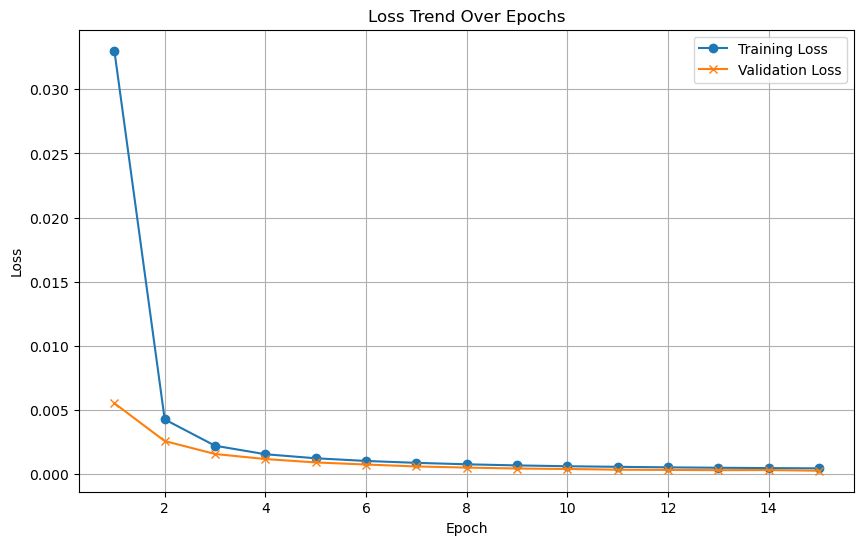

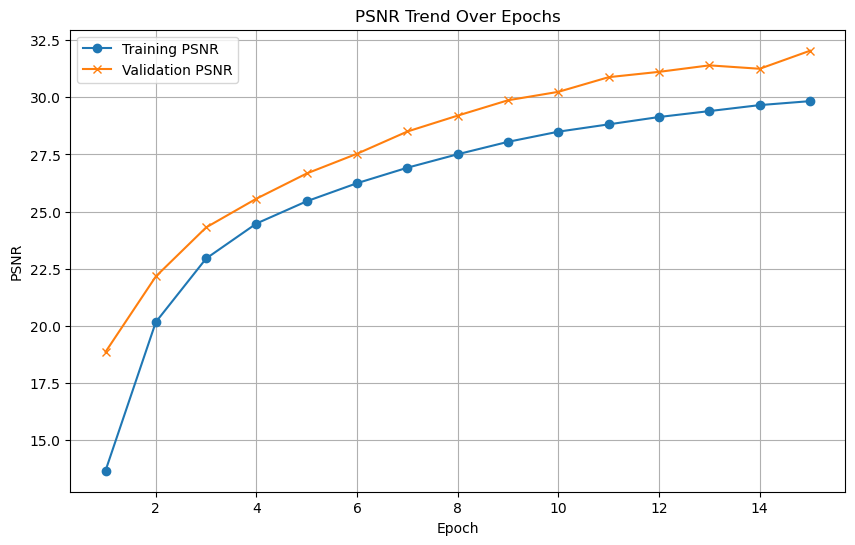

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/579 for test dataset.


    Processed batch 101/579 for test dataset.


    Processed batch 201/579 for test dataset.


    Processed batch 301/579 for test dataset.


    Processed batch 401/579 for test dataset.


    Processed batch 501/579 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.2222
    Validation Batch [1/1], Loss: 2.2011
Validation Loss: 2.2011, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2011. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1559
    Validation Batch [1/1], Loss: 2.2011
Validation Loss: 2.2011, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.1268
    Validation Batch [1/1], Loss: 2.2011
Validation Loss: 2.2011, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.1059
    Validation Batch [1/1], Loss: 2.2010
Validation Loss: 2.2010, Validation Accuracy: 11.11%
Validation loss improved from 2.2011 to 2.2010. Saving model...

LOG: Epoch [5/1000] - Training
Epoch [5/1000] co

Epoch [7/1000] completed, Average Training Loss: 2.0308
    Validation Batch [1/1], Loss: 2.2010
Validation Loss: 2.2010, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [8/1000] - Training
Epoch [8/1000] completed, Average Training Loss: 2.0379
    Validation Batch [1/1], Loss: 2.2011
Validation Loss: 2.2011, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 2.0060
    Validation Batch [1/1], Loss: 2.2011
Validation Loss: 2.2011, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 2.0061
    Validation Batch [1/1], Loss: 2.2011
Validation Loss: 2.2011, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 1.9843
    Validation B

    Validation Batch [1/1], Loss: 2.1123
Validation Loss: 2.1123, Validation Accuracy: 37.78%
Validation loss improved from 2.1227 to 2.1123. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 1.6828
    Validation Batch [1/1], Loss: 2.1007
Validation Loss: 2.1007, Validation Accuracy: 35.56%
Validation loss improved from 2.1123 to 2.1007. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 1.7139
    Validation Batch [1/1], Loss: 2.0880
Validation Loss: 2.0880, Validation Accuracy: 33.33%
Validation loss improved from 2.1007 to 2.0880. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 1.6914
    Validation Batch [1/1], Loss: 2.0745
Validation Loss: 2.0745, Validation Accuracy: 33.33%
Validation loss improved from 2.0880 to 2.0745. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [43/1000] completed, Average Training Loss: 1.6997
    Vali

    Validation Batch [1/1], Loss: 1.6254
Validation Loss: 1.6254, Validation Accuracy: 77.78%
Validation loss improved from 1.6416 to 1.6254. Saving model...

LOG: Epoch [69/1000] - Training
Epoch [69/1000] completed, Average Training Loss: 1.4107
    Validation Batch [1/1], Loss: 1.6124
Validation Loss: 1.6124, Validation Accuracy: 77.78%
Validation loss improved from 1.6254 to 1.6124. Saving model...

LOG: Epoch [70/1000] - Training
Epoch [70/1000] completed, Average Training Loss: 1.4375
    Validation Batch [1/1], Loss: 1.5984
Validation Loss: 1.5984, Validation Accuracy: 75.56%
Validation loss improved from 1.6124 to 1.5984. Saving model...

LOG: Epoch [71/1000] - Training
Epoch [71/1000] completed, Average Training Loss: 1.4142
    Validation Batch [1/1], Loss: 1.5879
Validation Loss: 1.5879, Validation Accuracy: 77.78%
Validation loss improved from 1.5984 to 1.5879. Saving model...

LOG: Epoch [72/1000] - Training
Epoch [72/1000] completed, Average Training Loss: 1.4104
    Vali

Epoch [100/1000] completed, Average Training Loss: 1.1909
    Validation Batch [1/1], Loss: 1.3433
Validation Loss: 1.3433, Validation Accuracy: 80.00%
Validation loss improved from 1.3503 to 1.3433. Saving model...

LOG: Epoch [101/1000] - Training
Epoch [101/1000] completed, Average Training Loss: 1.1514
    Validation Batch [1/1], Loss: 1.3339
Validation Loss: 1.3339, Validation Accuracy: 82.22%
Validation loss improved from 1.3433 to 1.3339. Saving model...

LOG: Epoch [102/1000] - Training
Epoch [102/1000] completed, Average Training Loss: 1.1150
    Validation Batch [1/1], Loss: 1.3281
Validation Loss: 1.3281, Validation Accuracy: 80.00%
Validation loss improved from 1.3339 to 1.3281. Saving model...

LOG: Epoch [103/1000] - Training
Epoch [103/1000] completed, Average Training Loss: 1.1550
    Validation Batch [1/1], Loss: 1.3240
Validation Loss: 1.3240, Validation Accuracy: 80.00%
Validation loss improved from 1.3281 to 1.3240. Saving model...

LOG: Epoch [104/1000] - Training


Epoch [128/1000] completed, Average Training Loss: 0.9697
    Validation Batch [1/1], Loss: 1.1425
Validation Loss: 1.1425, Validation Accuracy: 84.44%
Validation loss improved from 1.1487 to 1.1425. Saving model...

LOG: Epoch [129/1000] - Training
Epoch [129/1000] completed, Average Training Loss: 0.9367
    Validation Batch [1/1], Loss: 1.1410
Validation Loss: 1.1410, Validation Accuracy: 82.22%
Validation loss improved from 1.1425 to 1.1410. Saving model...

LOG: Epoch [130/1000] - Training
Epoch [130/1000] completed, Average Training Loss: 0.9573
    Validation Batch [1/1], Loss: 1.1416
Validation Loss: 1.1416, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [131/1000] - Training
Epoch [131/1000] completed, Average Training Loss: 0.9476
    Validation Batch [1/1], Loss: 1.1354
Validation Loss: 1.1354, Validation Accuracy: 84.44%
Validation loss improved from 1.1410 to 1.1354. Saving model...

LOG: Epoch [132/1000] - Training
Epoch [132/1000

Epoch [159/1000] completed, Average Training Loss: 0.6876
    Validation Batch [1/1], Loss: 0.9546
Validation Loss: 0.9546, Validation Accuracy: 88.89%
Validation loss improved from 0.9618 to 0.9546. Saving model...

LOG: Epoch [160/1000] - Training
Epoch [160/1000] completed, Average Training Loss: 0.7784
    Validation Batch [1/1], Loss: 0.9506
Validation Loss: 0.9506, Validation Accuracy: 86.67%
Validation loss improved from 0.9546 to 0.9506. Saving model...

LOG: Epoch [161/1000] - Training
Epoch [161/1000] completed, Average Training Loss: 0.7390
    Validation Batch [1/1], Loss: 0.9404
Validation Loss: 0.9404, Validation Accuracy: 86.67%
Validation loss improved from 0.9506 to 0.9404. Saving model...

LOG: Epoch [162/1000] - Training
Epoch [162/1000] completed, Average Training Loss: 0.7731
    Validation Batch [1/1], Loss: 0.9319
Validation Loss: 0.9319, Validation Accuracy: 88.89%
Validation loss improved from 0.9404 to 0.9319. Saving model...

LOG: Epoch [163/1000] - Training


    Validation Batch [1/1], Loss: 0.7815
Validation Loss: 0.7815, Validation Accuracy: 91.11%
Validation loss improved from 0.7842 to 0.7815. Saving model...

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 0.5757
    Validation Batch [1/1], Loss: 0.7804
Validation Loss: 0.7804, Validation Accuracy: 91.11%
Validation loss improved from 0.7815 to 0.7804. Saving model...

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training Loss: 0.5788
    Validation Batch [1/1], Loss: 0.7807
Validation Loss: 0.7807, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [191/1000] - Training
Epoch [191/1000] completed, Average Training Loss: 0.5414
    Validation Batch [1/1], Loss: 0.7672
Validation Loss: 0.7672, Validation Accuracy: 91.11%
Validation loss improved from 0.7804 to 0.7672. Saving model...

LOG: Epoch [192/1000] - Training
Epoch [192/1000] completed, Average Training Loss: 0.5302
    Validation 

Epoch [218/1000] completed, Average Training Loss: 0.4155
    Validation Batch [1/1], Loss: 0.6511
Validation Loss: 0.6511, Validation Accuracy: 91.11%
Validation loss improved from 0.6581 to 0.6511. Saving model...

LOG: Epoch [219/1000] - Training
Epoch [219/1000] completed, Average Training Loss: 0.4312
    Validation Batch [1/1], Loss: 0.6440
Validation Loss: 0.6440, Validation Accuracy: 91.11%
Validation loss improved from 0.6511 to 0.6440. Saving model...

LOG: Epoch [220/1000] - Training
Epoch [220/1000] completed, Average Training Loss: 0.4114
    Validation Batch [1/1], Loss: 0.6413
Validation Loss: 0.6413, Validation Accuracy: 93.33%
Validation loss improved from 0.6440 to 0.6413. Saving model...

LOG: Epoch [221/1000] - Training
Epoch [221/1000] completed, Average Training Loss: 0.3500
    Validation Batch [1/1], Loss: 0.6366
Validation Loss: 0.6366, Validation Accuracy: 91.11%
Validation loss improved from 0.6413 to 0.6366. Saving model...

LOG: Epoch [222/1000] - Training


Epoch [249/1000] completed, Average Training Loss: 0.3064
    Validation Batch [1/1], Loss: 0.5427
Validation Loss: 0.5427, Validation Accuracy: 91.11%
Validation loss improved from 0.5456 to 0.5427. Saving model...

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training Loss: 0.2919
    Validation Batch [1/1], Loss: 0.5465
Validation Loss: 0.5465, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training Loss: 0.2792
    Validation Batch [1/1], Loss: 0.5444
Validation Loss: 0.5444, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [252/1000] - Training
Epoch [252/1000] completed, Average Training Loss: 0.2644
    Validation Batch [1/1], Loss: 0.5374
Validation Loss: 0.5374, Validation Accuracy: 93.33%
Validation loss improved from 0.5427 to 0.5374. Saving model...

LOG: Epoch [253/1000] - Training
Epoch [253/1000] completed, Av

    Validation Batch [1/1], Loss: 0.4649
Validation Loss: 0.4649, Validation Accuracy: 91.11%
Validation loss improved from 0.4696 to 0.4649. Saving model...

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.2091
    Validation Batch [1/1], Loss: 0.4646
Validation Loss: 0.4646, Validation Accuracy: 91.11%
Validation loss improved from 0.4649 to 0.4646. Saving model...

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.2203
    Validation Batch [1/1], Loss: 0.4632
Validation Loss: 0.4632, Validation Accuracy: 91.11%
Validation loss improved from 0.4646 to 0.4632. Saving model...

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Average Training Loss: 0.1959
    Validation Batch [1/1], Loss: 0.4657
Validation Loss: 0.4657, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [284/1000] - Training
Epoch [284/1000] completed, Average Training Loss: 0.2043
    Validation 

Validation Loss: 0.4231, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [312/1000] - Training
Epoch [312/1000] completed, Average Training Loss: 0.1694
    Validation Batch [1/1], Loss: 0.4215
Validation Loss: 0.4215, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Training Loss: 0.1734
    Validation Batch [1/1], Loss: 0.4185
Validation Loss: 0.4185, Validation Accuracy: 91.11%
Validation loss improved from 0.4214 to 0.4185. Saving model...

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.1580
    Validation Batch [1/1], Loss: 0.4167
Validation Loss: 0.4167, Validation Accuracy: 91.11%
Validation loss improved from 0.4185 to 0.4167. Saving model...

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.1376
    Validation Batch [1/1], Loss: 0.4139
Validation Loss: 0.4139, Valid

    Validation Batch [1/1], Loss: 0.3857
Validation Loss: 0.3857, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [344/1000] - Training
Epoch [344/1000] completed, Average Training Loss: 0.1194
    Validation Batch [1/1], Loss: 0.3856
Validation Loss: 0.3856, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [345/1000] - Training
Epoch [345/1000] completed, Average Training Loss: 0.1236
    Validation Batch [1/1], Loss: 0.3920
Validation Loss: 0.3920, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [346/1000] - Training
Epoch [346/1000] completed, Average Training Loss: 0.1244
    Validation Batch [1/1], Loss: 0.4003
Validation Loss: 0.4003, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [347/1000] - Training
Epoch [347/1000] completed, Average Training Loss: 0.1330
    Validation Batch [1/1], Loss: 0.4003
Validation Loss: 0.

Epoch [372/1000] completed, Average Training Loss: 0.1018
    Validation Batch [1/1], Loss: 0.3783
Validation Loss: 0.3783, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [373/1000] - Training
Epoch [373/1000] completed, Average Training Loss: 0.0982
    Validation Batch [1/1], Loss: 0.3753
Validation Loss: 0.3753, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Average Training Loss: 0.1085
    Validation Batch [1/1], Loss: 0.3727
Validation Loss: 0.3727, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [375/1000] - Training
Epoch [375/1000] completed, Average Training Loss: 0.0885
    Validation Batch [1/1], Loss: 0.3674
Validation Loss: 0.3674, Validation Accuracy: 91.11%
Validation loss improved from 0.3708 to 0.3674. Saving model...

LOG: Epoch [376/1000] - Training
Epoch [376/1000] completed, Average Training 

Epoch [404/1000] completed, Average Training Loss: 0.1063
    Validation Batch [1/1], Loss: 0.3583
Validation Loss: 0.3583, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [405/1000] - Training
Epoch [405/1000] completed, Average Training Loss: 0.0664
    Validation Batch [1/1], Loss: 0.3548
Validation Loss: 0.3548, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [406/1000] - Training
Epoch [406/1000] completed, Average Training Loss: 0.0656
    Validation Batch [1/1], Loss: 0.3545
Validation Loss: 0.3545, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [407/1000] - Training
Epoch [407/1000] completed, Average Training Loss: 0.1003
    Validation Batch [1/1], Loss: 0.3656
Validation Loss: 0.3656, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [408/1000] - Training
Epoch [408/1000] completed, Average Training Loss: 0.077

Epoch [435/1000] completed, Average Training Loss: 0.0614
    Validation Batch [1/1], Loss: 0.3535
Validation Loss: 0.3535, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [436/1000] - Training
Epoch [436/1000] completed, Average Training Loss: 0.0639
    Validation Batch [1/1], Loss: 0.3504
Validation Loss: 0.3504, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [437/1000] - Training
Epoch [437/1000] completed, Average Training Loss: 0.0684
    Validation Batch [1/1], Loss: 0.3469
Validation Loss: 0.3469, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [438/1000] - Training
Epoch [438/1000] completed, Average Training Loss: 0.0770
    Validation Batch [1/1], Loss: 0.3431
Validation Loss: 0.3431, Validation Accuracy: 91.11%
Validation loss improved from 0.3436 to 0.3431. Saving model...

LOG: Epoch [439/1000] - Training
Epoch [439/1000] completed, Average Traini

Epoch [467/1000] completed, Average Training Loss: 0.0477
    Validation Batch [1/1], Loss: 0.3571
Validation Loss: 0.3571, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Training Loss: 0.0520
    Validation Batch [1/1], Loss: 0.3648
Validation Loss: 0.3648, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [469/1000] - Training
Epoch [469/1000] completed, Average Training Loss: 0.0518
    Validation Batch [1/1], Loss: 0.3353
Validation Loss: 0.3353, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [470/1000] - Training
Epoch [470/1000] completed, Average Training Loss: 0.0575
    Validation Batch [1/1], Loss: 0.3304
Validation Loss: 0.3304, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [471/1000] - Training
Epoch [471/1000] completed, Average Training Loss: 0.049

    Validation Batch [1/1], Loss: 0.3476
Validation Loss: 0.3476, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [499/1000] - Training
Epoch [499/1000] completed, Average Training Loss: 0.0380
    Validation Batch [1/1], Loss: 0.3462
Validation Loss: 0.3462, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [500/1000] - Training
Epoch [500/1000] completed, Average Training Loss: 0.0486
    Validation Batch [1/1], Loss: 0.3464
Validation Loss: 0.3464, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [501/1000] - Training
Epoch [501/1000] completed, Average Training Loss: 0.0474
    Validation Batch [1/1], Loss: 0.3494
Validation Loss: 0.3494, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Training Loss: 0.0419
    Validation Batch [1/1], Loss: 0.3541
Validation Loss

Epoch [530/1000] completed, Average Training Loss: 0.0410
    Validation Batch [1/1], Loss: 0.3370
Validation Loss: 0.3370, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [531/1000] - Training
Epoch [531/1000] completed, Average Training Loss: 0.0324
    Validation Batch [1/1], Loss: 0.3365
Validation Loss: 0.3365, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [532/1000] - Training
Epoch [532/1000] completed, Average Training Loss: 0.0421
    Validation Batch [1/1], Loss: 0.3477
Validation Loss: 0.3477, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [533/1000] - Training
Epoch [533/1000] completed, Average Training Loss: 0.0361
    Validation Batch [1/1], Loss: 0.3442
Validation Loss: 0.3442, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [534/1000] - Training
Epoch [534/1000] completed, Average Training Loss: 0.031

Epoch [561/1000] completed, Average Training Loss: 0.0431
    Validation Batch [1/1], Loss: 0.3490
Validation Loss: 0.3490, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [562/1000] - Training
Epoch [562/1000] completed, Average Training Loss: 0.0381
    Validation Batch [1/1], Loss: 0.3410
Validation Loss: 0.3410, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [563/1000] - Training
Epoch [563/1000] completed, Average Training Loss: 0.0411
    Validation Batch [1/1], Loss: 0.3350
Validation Loss: 0.3350, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 88/100

LOG: Epoch [564/1000] - Training
Epoch [564/1000] completed, Average Training Loss: 0.0375
    Validation Batch [1/1], Loss: 0.3357
Validation Loss: 0.3357, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 89/100

LOG: Epoch [565/1000] - Training
Epoch [565/1000] completed, Average Training Loss: 0.032

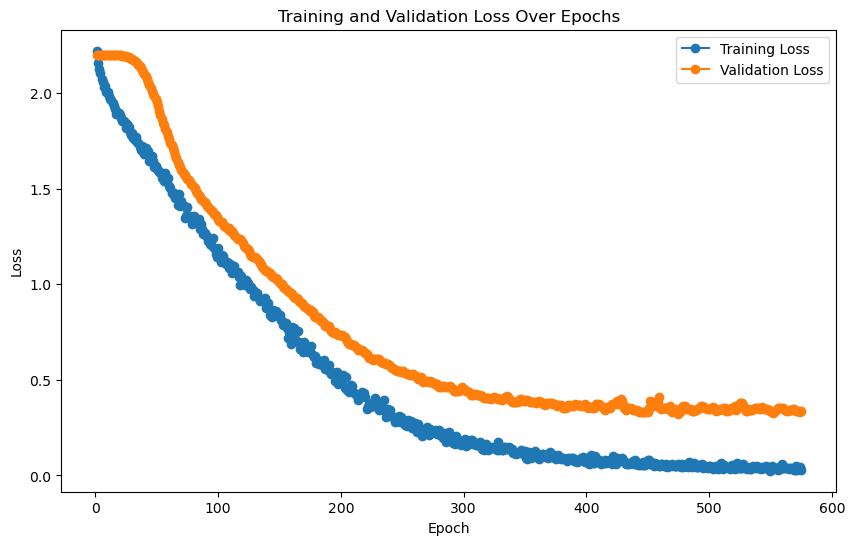

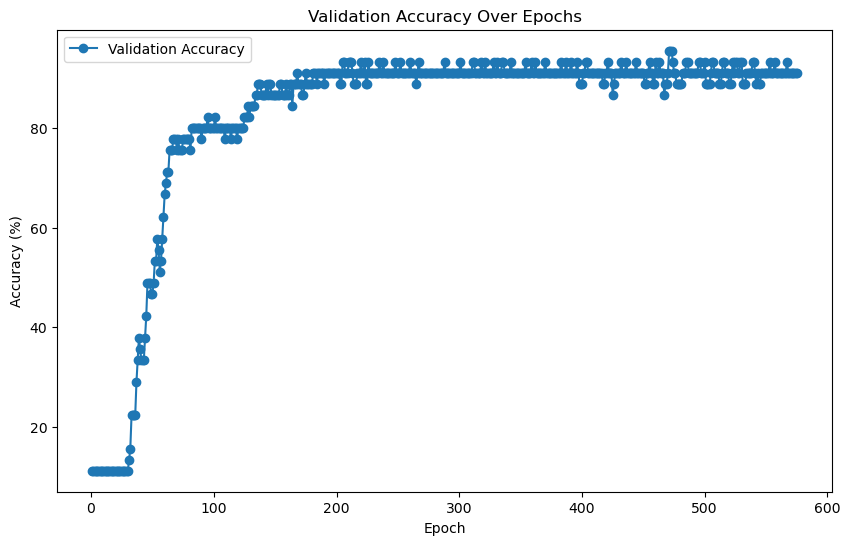


Evaluating on the test set...
    Test Batch [1/579], Loss: 0.2309



Final Test Loss: 0.1292, Test Accuracy: 96.79%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/579 for test dataset.
  Processed batch 20/579 for test dataset.
  Processed batch 30/579 for test dataset.


  Processed batch 40/579 for test dataset.


  Processed batch 50/579 for test dataset.
  Processed batch 60/579 for test dataset.
  Processed batch 70/579 for test dataset.
  Processed batch 80/579 for test dataset.


  Processed batch 90/579 for test dataset.


  Processed batch 100/579 for test dataset.
  Processed batch 110/579 for test dataset.
  Processed batch 120/579 for test dataset.
  Processed batch 130/579 for test dataset.


  Processed batch 140/579 for test dataset.


  Processed batch 150/579 for test dataset.
  Processed batch 160/579 for test dataset.
  Processed batch 170/579 for test dataset.
  Processed batch 180/579 for test dataset.


  Processed batch 190/579 for test dataset.


  Processed batch 200/579 for test dataset.
  Processed batch 210/579 for test dataset.
  Processed batch 220/579 for test dataset.
  Processed batch 230/579 for test dataset.


  Processed batch 240/579 for test dataset.


  Processed batch 250/579 for test dataset.
  Processed batch 260/579 for test dataset.
  Processed batch 270/579 for test dataset.
  Processed batch 280/579 for test dataset.


  Processed batch 290/579 for test dataset.


  Processed batch 300/579 for test dataset.
  Processed batch 310/579 for test dataset.
  Processed batch 320/579 for test dataset.
  Processed batch 330/579 for test dataset.
  Processed batch 340/579 for test dataset.


  Processed batch 350/579 for test dataset.
  Processed batch 360/579 for test dataset.
  Processed batch 370/579 for test dataset.
  Processed batch 380/579 for test dataset.
  Processed batch 390/579 for test dataset.


  Processed batch 400/579 for test dataset.
  Processed batch 410/579 for test dataset.
  Processed batch 420/579 for test dataset.
  Processed batch 430/579 for test dataset.
  Processed batch 440/579 for test dataset.


  Processed batch 450/579 for test dataset.
  Processed batch 460/579 for test dataset.
  Processed batch 470/579 for test dataset.
  Processed batch 480/579 for test dataset.
  Processed batch 490/579 for test dataset.


  Processed batch 500/579 for test dataset.
  Processed batch 510/579 for test dataset.
  Processed batch 520/579 for test dataset.
  Processed batch 530/579 for test dataset.
  Processed batch 540/579 for test dataset.


  Processed batch 550/579 for test dataset.
  Processed batch 560/579 for test dataset.
  Processed batch 570/579 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148017 samples with 64 features each
LOG: Labels shape: (148017,)

LOG: Training features shape: (90, 64), Training labels shape: (90,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (148017, 64), Test labels shape: (148017,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 82.22%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.40      0.57         5
           2       0.57      0.80      0.67         5
           3       0.75      0.60      0.67         5
           4       0.57      0.80      0.67         5
           5       0.83      1.00      0.91         5
           6       1.00      0.80      0.89         5
           7       1.00      1.00      1.00         5
           8       1.00      

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 148017 samples with 64 features each
LOG: Labels shape: (148017,)
Train reps shape: (90, 64)
Train labels shape: (90,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (148017, 64)
Test labels shape: (148017,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3010  |  Val Loss: 2.1490
Validation loss improved from inf to 2.1490.
[Epoch 2/1000] Train Loss: 2.1095  |  Val Loss: 2.0203
Validation loss improved from 2.1490 to 2.0203.
[Epoch 3/1000] Train Loss: 1.9872  |  Val Loss: 1.9158
Validation loss improved from 2.0203 to 1.9158.
[Epoch 4/1000] Train Loss: 1.8771  |  Val Loss: 1.8182
Validation loss improved from 1.9158 to 1.8182.
[Epoch 5/1000] Train Loss: 1.7743  |  Val Loss: 1.7434
Validation loss improved from 1.8182 to 1.7434.
[Epoch 6/1000] Train Loss: 1.6908  |  Val Loss: 1.6780
Validation loss improved from 1.7434 to 1.6780.
[Epoch 7/1000] Train Loss: 1.6177  |  Val Loss: 1.6157
Validation loss improved from 1.6780 to 1.6157.
[Epoch 8/1000] Train Loss: 1.5476  |  Val Loss: 1.5580
Validation loss improved from 1.6157 to 1.5580.


[Epoch 9/1000] Train Loss: 1.4785  |  Val Loss: 1.4981
Validation loss improved from 1.5580 to 1.4981.
[Epoch 10/1000] Train Loss: 1.4086  |  Val Loss: 1.4358
Validation loss improved from 1.4981 to 1.4358.
[Epoch 11/1000] Train Loss: 1.3333  |  Val Loss: 1.3742
Validation loss improved from 1.4358 to 1.3742.
[Epoch 12/1000] Train Loss: 1.2630  |  Val Loss: 1.3163
Validation loss improved from 1.3742 to 1.3163.
[Epoch 13/1000] Train Loss: 1.2002  |  Val Loss: 1.2664
Validation loss improved from 1.3163 to 1.2664.
[Epoch 14/1000] Train Loss: 1.1421  |  Val Loss: 1.2218
Validation loss improved from 1.2664 to 1.2218.
[Epoch 15/1000] Train Loss: 1.0857  |  Val Loss: 1.1768
Validation loss improved from 1.2218 to 1.1768.
[Epoch 16/1000] Train Loss: 1.0330  |  Val Loss: 1.1328
Validation loss improved from 1.1768 to 1.1328.
[Epoch 17/1000] Train Loss: 0.9824  |  Val Loss: 1.0939
Validation loss improved from 1.1328 to 1.0939.
[Epoch 18/1000] Train Loss: 0.9338  |  Val Loss: 1.0608
Validatio

[Epoch 45/1000] Train Loss: 0.2634  |  Val Loss: 0.4898
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 46/1000] Train Loss: 0.2578  |  Val Loss: 0.4881
Validation loss improved from 0.4897 to 0.4881.
[Epoch 47/1000] Train Loss: 0.2429  |  Val Loss: 0.4868
Validation loss improved from 0.4881 to 0.4868.
[Epoch 48/1000] Train Loss: 0.2313  |  Val Loss: 0.4888
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 49/1000] Train Loss: 0.2255  |  Val Loss: 0.4880
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 50/1000] Train Loss: 0.2198  |  Val Loss: 0.4764
Validation loss improved from 0.4868 to 0.4764.
[Epoch 51/1000] Train Loss: 0.2092  |  Val Loss: 0.4728
Validation loss improved from 0.4764 to 0.4728.
[Epoch 52/1000] Train Loss: 0.2029  |  Val Loss: 0.4690
Validation loss improved from 0.4728 to 0.4690.
[Epoch 53/1000] Train Loss: 0.1980  |  Val Loss: 0.4559
Validation loss improved from 0.4690 to 0.4559.
[Epoch 54/1000] Train Loss: 0.1921  |  Val Los

[Epoch 55/1000] Train Loss: 0.1809  |  Val Loss: 0.4664
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 56/1000] Train Loss: 0.1808  |  Val Loss: 0.4704
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 57/1000] Train Loss: 0.1722  |  Val Loss: 0.4598
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 58/1000] Train Loss: 0.1666  |  Val Loss: 0.4559
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 59/1000] Train Loss: 0.1628  |  Val Loss: 0.4569
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 60/1000] Train Loss: 0.1564  |  Val Loss: 0.4538
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 61/1000] Train Loss: 0.1534  |  Val Loss: 0.4395
Validation loss improved from 0.4538 to 0.4395.
[Epoch 62/1000] Train Loss: 0.1478  |  Val Loss: 0.4313
Validation loss improved from 0.4395 to 0.4313.
[Epoch 63/1000] Train Loss: 0.1421  |  Val Loss: 0.4265
Validation loss improved from 0.4313 to 0.4265.
[Epoch 64/1000] Train Loss: 

[Epoch 86/1000] Train Loss: 0.0790  |  Val Loss: 0.4593
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 87/1000] Train Loss: 0.0794  |  Val Loss: 0.4654
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 88/1000] Train Loss: 0.0800  |  Val Loss: 0.4626
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 89/1000] Train Loss: 0.0760  |  Val Loss: 0.4642
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 90/1000] Train Loss: 0.0760  |  Val Loss: 0.4764
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 91/1000] Train Loss: 0.0727  |  Val Loss: 0.4743
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 92/1000] Train Loss: 0.0710  |  Val Loss: 0.4752
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 93/1000] Train Loss: 0.0713  |  Val Loss: 0.4779
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 94/1000] Train Loss: 0.0669  |  Val Loss: 0.4787
!! Validation loss did NOT improve !! Patience: 31/100
[

[Epoch 98/1000] Train Loss: 0.0619  |  Val Loss: 0.4945
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 99/1000] Train Loss: 0.0609  |  Val Loss: 0.4938
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 100/1000] Train Loss: 0.0598  |  Val Loss: 0.4863
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 101/1000] Train Loss: 0.0590  |  Val Loss: 0.4857
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 102/1000] Train Loss: 0.0590  |  Val Loss: 0.4870
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 103/1000] Train Loss: 0.0583  |  Val Loss: 0.4937
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 104/1000] Train Loss: 0.0587  |  Val Loss: 0.4871
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 105/1000] Train Loss: 0.0543  |  Val Loss: 0.4909
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 106/1000] Train Loss: 0.0573  |  Val Loss: 0.4890
!! Validation loss did NOT improve !! Patience: 4

[Epoch 133/1000] Train Loss: 0.0344  |  Val Loss: 0.5661
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 134/1000] Train Loss: 0.0362  |  Val Loss: 0.5893
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 135/1000] Train Loss: 0.0374  |  Val Loss: 0.5924
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 136/1000] Train Loss: 0.0353  |  Val Loss: 0.5821
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 137/1000] Train Loss: 0.0338  |  Val Loss: 0.5695
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 138/1000] Train Loss: 0.0326  |  Val Loss: 0.5522
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 139/1000] Train Loss: 0.0335  |  Val Loss: 0.5436
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 140/1000] Train Loss: 0.0318  |  Val Loss: 0.5464
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 141/1000] Train Loss: 0.0319  |  Val Loss: 0.5595
!! Validation loss did NOT improve !! Patience:

[Epoch 143/1000] Train Loss: 0.0312  |  Val Loss: 0.5899
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 144/1000] Train Loss: 0.0306  |  Val Loss: 0.5893
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 145/1000] Train Loss: 0.0330  |  Val Loss: 0.5906
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 146/1000] Train Loss: 0.0278  |  Val Loss: 0.6121
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 147/1000] Train Loss: 0.0308  |  Val Loss: 0.6333
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 148/1000] Train Loss: 0.0376  |  Val Loss: 0.6154
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 149/1000] Train Loss: 0.0295  |  Val Loss: 0.5857
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 150/1000] Train Loss: 0.0264  |  Val Loss: 0.5760
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 151/1000] Train Loss: 0.0359  |  Val Loss: 0.5596
!! Validation loss did NOT improve !! Patience:

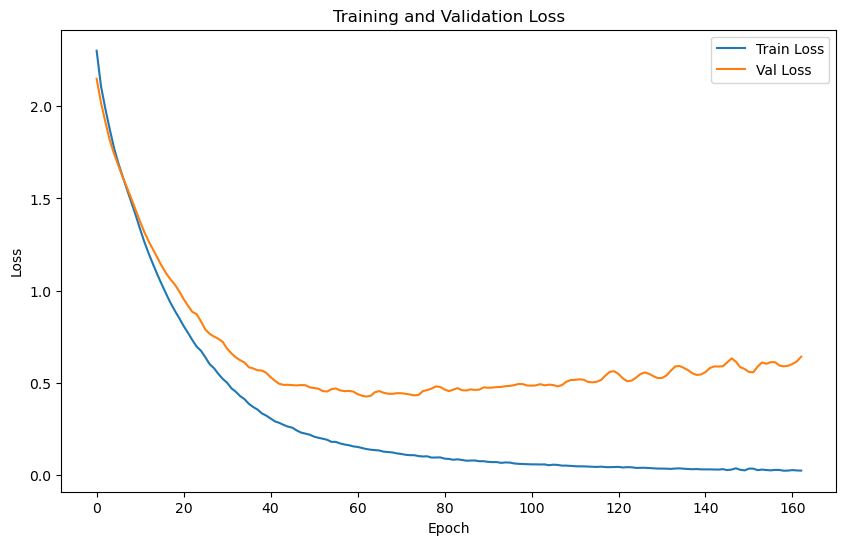

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.2298 | Test Accuracy: 94.38%


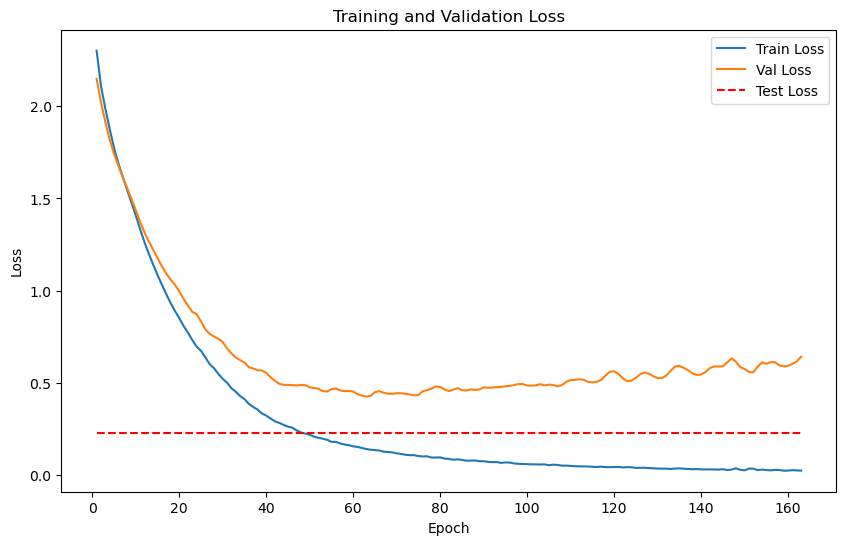

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148017 samples with 64 features each
LOG: Labels shape: (148017,)


Train embeddings shape: (90, 64), 
Train labels shape: (90,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (148017, 64), 
Test labels shape: (148017,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}
Training batch size: 90


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.6095
Epoch [1/2000], Avg Train Loss: 8.6095


Epoch [1/2000], Avg Val Loss: 3.3051
Validation loss improved from inf to 3.3051. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.1740
Epoch [2/2000], Avg Train Loss: 8.1740
Epoch [2/2000], Avg Val Loss: 3.2748
Validation loss improved from 3.3051 to 3.2748. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.4483
Epoch [3/2000], Avg Train Loss: 8.4483
Epoch [3/2000], Avg Val Loss: 3.2459
Validation loss improved from 3.2748 to 3.2459. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.9517
Epoch [4/2000], Avg Train Loss: 7.9517
Epoch [4/2000], Avg Val Loss: 3.2181
Validation loss improved from 3.2459 to 3.2181. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.1426
Epoch [5/2000], Avg Train Loss: 8.1426
Epoch [5/2000], Avg Val Loss: 3.1913
Validation loss improved from 3.2181 to 3.1913. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 8.2288
Ep

    Batch [1/1], Train Loss: 7.7330
Epoch [13/2000], Avg Train Loss: 7.7330
Epoch [13/2000], Avg Val Loss: 3.0082
Validation loss improved from 3.0284 to 3.0082. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 7.6229
Epoch [14/2000], Avg Train Loss: 7.6229
Epoch [14/2000], Avg Val Loss: 2.9888
Validation loss improved from 3.0082 to 2.9888. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 7.7050
Epoch [15/2000], Avg Train Loss: 7.7050
Epoch [15/2000], Avg Val Loss: 2.9699
Validation loss improved from 2.9888 to 2.9699. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 7.7168
Epoch [16/2000], Avg Train Loss: 7.7168
Epoch [16/2000], Avg Val Loss: 2.9519
Validation loss improved from 2.9699 to 2.9519. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 7.3201
Epoch [17/2000], Avg Train Loss: 7.3201
Epoch [17/2000], Avg Val Loss: 2.9346
Validation loss improved from 2.9519 to 2.

    Batch [1/1], Train Loss: 5.6890


Epoch [48/2000], Avg Train Loss: 5.6890
Epoch [48/2000], Avg Val Loss: 2.6344
Validation loss improved from 2.6391 to 2.6344. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 5.5384
Epoch [49/2000], Avg Train Loss: 5.5384
Epoch [49/2000], Avg Val Loss: 2.6299
Validation loss improved from 2.6344 to 2.6299. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 5.7080
Epoch [50/2000], Avg Train Loss: 5.7080
Epoch [50/2000], Avg Val Loss: 2.6256
Validation loss improved from 2.6299 to 2.6256. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 5.5954
Epoch [51/2000], Avg Train Loss: 5.5954
Epoch [51/2000], Avg Val Loss: 2.6215
Validation loss improved from 2.6256 to 2.6215. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 5.5017
Epoch [52/2000], Avg Train Loss: 5.5017
Epoch [52/2000], Avg Val Loss: 2.6177
Validation loss improved from 2.6215 to 2.6177. Saving model...

LOG: Epoch [5

Epoch [94/2000], Avg Val Loss: 2.5578
Validation loss improved from 2.5581 to 2.5578. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 4.3539
Epoch [95/2000], Avg Train Loss: 4.3539
Epoch [95/2000], Avg Val Loss: 2.5575
Validation loss improved from 2.5578 to 2.5575. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 4.2645
Epoch [96/2000], Avg Train Loss: 4.2645
Epoch [96/2000], Avg Val Loss: 2.5572
Validation loss improved from 2.5575 to 2.5572. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 4.4849
Epoch [97/2000], Avg Train Loss: 4.4849
Epoch [97/2000], Avg Val Loss: 2.5569
Validation loss improved from 2.5572 to 2.5569. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 4.2613
Epoch [98/2000], Avg Train Loss: 4.2613
Epoch [98/2000], Avg Val Loss: 2.5566
Validation loss improved from 2.5569 to 2.5566. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/1], Trai

Epoch [139/2000], Avg Val Loss: 2.5496
Validation loss improved from 2.5498 to 2.5496. Saving model...

LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 4.0797
Epoch [140/2000], Avg Train Loss: 4.0797
Epoch [140/2000], Avg Val Loss: 2.5494
Validation loss improved from 2.5496 to 2.5494. Saving model...

LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 4.0613
Epoch [141/2000], Avg Train Loss: 4.0613
Epoch [141/2000], Avg Val Loss: 2.5492
Validation loss improved from 2.5494 to 2.5492. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 4.0404
Epoch [142/2000], Avg Train Loss: 4.0404
Epoch [142/2000], Avg Val Loss: 2.5490
Validation loss improved from 2.5492 to 2.5490. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 4.0314
Epoch [143/2000], Avg Train Loss: 4.0314
Epoch [143/2000], Avg Val Loss: 2.5488
Validation loss improved from 2.5490 to 2.5488. Saving model...

LOG: Epoch [144/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9034
Epoch [186/2000], Avg Train Loss: 3.9034
Epoch [186/2000], Avg Val Loss: 2.5321
Validation loss improved from 2.5326 to 2.5321. Saving model...

LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 3.8586
Epoch [187/2000], Avg Train Loss: 3.8586
Epoch [187/2000], Avg Val Loss: 2.5316
Validation loss improved from 2.5321 to 2.5316. Saving model...

LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 3.8128
Epoch [188/2000], Avg Train Loss: 3.8128
Epoch [188/2000], Avg Val Loss: 2.5311
Validation loss improved from 2.5316 to 2.5311. Saving model...

LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 3.7681
Epoch [189/2000], Avg Train Loss: 3.7681
Epoch [189/2000], Avg Val Loss: 2.5306
Validation loss improved from 2.5311 to 2.5306. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 3.7851
Epoch [190/2000], Avg Train Loss: 3.7851
Epoch [190/2000], Avg Val Loss: 2.5301
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5805
Epoch [234/2000], Avg Train Loss: 3.5805
Epoch [234/2000], Avg Val Loss: 2.5030
Validation loss improved from 2.5037 to 2.5030. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 3.6940
Epoch [235/2000], Avg Train Loss: 3.6940
Epoch [235/2000], Avg Val Loss: 2.5023
Validation loss improved from 2.5030 to 2.5023. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 3.7073
Epoch [236/2000], Avg Train Loss: 3.7073
Epoch [236/2000], Avg Val Loss: 2.5016
Validation loss improved from 2.5023 to 2.5016. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 3.6006
Epoch [237/2000], Avg Train Loss: 3.6006
Epoch [237/2000], Avg Val Loss: 2.5009
Validation loss improved from 2.5016 to 2.5009. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 3.6108
Epoch [238/2000], Avg Train Loss: 3.6108
Epoch [238/2000], Avg Val Loss: 2.5002
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5871
Epoch [282/2000], Avg Train Loss: 3.5871
Epoch [282/2000], Avg Val Loss: 2.4719
Validation loss improved from 2.4725 to 2.4719. Saving model...

LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 3.5379
Epoch [283/2000], Avg Train Loss: 3.5379
Epoch [283/2000], Avg Val Loss: 2.4713
Validation loss improved from 2.4719 to 2.4713. Saving model...

LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 3.6042
Epoch [284/2000], Avg Train Loss: 3.6042
Epoch [284/2000], Avg Val Loss: 2.4706
Validation loss improved from 2.4713 to 2.4706. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 3.5841
Epoch [285/2000], Avg Train Loss: 3.5841
Epoch [285/2000], Avg Val Loss: 2.4700
Validation loss improved from 2.4706 to 2.4700. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 3.5089
Epoch [286/2000], Avg Train Loss: 3.5089
Epoch [286/2000], Avg Val Loss: 2.4694
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4960
Epoch [327/2000], Avg Train Loss: 3.4960
Epoch [327/2000], Avg Val Loss: 2.4437
Validation loss improved from 2.4443 to 2.4437. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 3.4275
Epoch [328/2000], Avg Train Loss: 3.4275
Epoch [328/2000], Avg Val Loss: 2.4431
Validation loss improved from 2.4437 to 2.4431. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 3.4830
Epoch [329/2000], Avg Train Loss: 3.4830
Epoch [329/2000], Avg Val Loss: 2.4425
Validation loss improved from 2.4431 to 2.4425. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 3.4522
Epoch [330/2000], Avg Train Loss: 3.4522
Epoch [330/2000], Avg Val Loss: 2.4419
Validation loss improved from 2.4425 to 2.4419. Saving model...

LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 3.4579
Epoch [331/2000], Avg Train Loss: 3.4579
Epoch [331/2000], Avg Val Loss: 2.4413
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3778
Epoch [371/2000], Avg Train Loss: 3.3778
Epoch [371/2000], Avg Val Loss: 2.4180
Validation loss improved from 2.4185 to 2.4180. Saving model...

LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 3.3702
Epoch [372/2000], Avg Train Loss: 3.3702
Epoch [372/2000], Avg Val Loss: 2.4174
Validation loss improved from 2.4180 to 2.4174. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 3.3533
Epoch [373/2000], Avg Train Loss: 3.3533
Epoch [373/2000], Avg Val Loss: 2.4169
Validation loss improved from 2.4174 to 2.4169. Saving model...

LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 3.4059
Epoch [374/2000], Avg Train Loss: 3.4059
Epoch [374/2000], Avg Val Loss: 2.4163
Validation loss improved from 2.4169 to 2.4163. Saving model...

LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 3.3918
Epoch [375/2000], Avg Train Loss: 3.3918
Epoch [375/2000], Avg Val Loss: 2.4158
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2877
Epoch [416/2000], Avg Train Loss: 3.2877
Epoch [416/2000], Avg Val Loss: 2.3950
Validation loss improved from 2.3955 to 2.3950. Saving model...

LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 3.3078
Epoch [417/2000], Avg Train Loss: 3.3078
Epoch [417/2000], Avg Val Loss: 2.3945
Validation loss improved from 2.3950 to 2.3945. Saving model...

LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 3.3771
Epoch [418/2000], Avg Train Loss: 3.3771
Epoch [418/2000], Avg Val Loss: 2.3940
Validation loss improved from 2.3945 to 2.3940. Saving model...

LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 3.3317
Epoch [419/2000], Avg Train Loss: 3.3317
Epoch [419/2000], Avg Val Loss: 2.3935
Validation loss improved from 2.3940 to 2.3935. Saving model...

LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 3.3504
Epoch [420/2000], Avg Train Loss: 3.3504
Epoch [420/2000], Avg Val Loss: 2.3931
Validation loss improved fro

Epoch [464/2000], Avg Val Loss: 2.3735
Validation loss improved from 2.3740 to 2.3735. Saving model...

LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 3.3162
Epoch [465/2000], Avg Train Loss: 3.3162
Epoch [465/2000], Avg Val Loss: 2.3731
Validation loss improved from 2.3735 to 2.3731. Saving model...

LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 3.3347
Epoch [466/2000], Avg Train Loss: 3.3347
Epoch [466/2000], Avg Val Loss: 2.3727
Validation loss improved from 2.3731 to 2.3727. Saving model...

LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 3.2619
Epoch [467/2000], Avg Train Loss: 3.2619
Epoch [467/2000], Avg Val Loss: 2.3722
Validation loss improved from 2.3727 to 2.3722. Saving model...

LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 3.2883
Epoch [468/2000], Avg Train Loss: 3.2883
Epoch [468/2000], Avg Val Loss: 2.3718
Validation loss improved from 2.3722 to 2.3718. Saving model...

LOG: Epoch [469/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.2506
Epoch [510/2000], Avg Train Loss: 3.2506
Epoch [510/2000], Avg Val Loss: 2.3560
Validation loss improved from 2.3564 to 2.3560. Saving model...

LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 3.2442
Epoch [511/2000], Avg Train Loss: 3.2442
Epoch [511/2000], Avg Val Loss: 2.3556
Validation loss improved from 2.3560 to 2.3556. Saving model...

LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 3.2665
Epoch [512/2000], Avg Train Loss: 3.2665
Epoch [512/2000], Avg Val Loss: 2.3553
Validation loss improved from 2.3556 to 2.3553. Saving model...

LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 3.2685
Epoch [513/2000], Avg Train Loss: 3.2685
Epoch [513/2000], Avg Val Loss: 2.3549
Validation loss improved from 2.3553 to 2.3549. Saving model...

LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 3.2087
Epoch [514/2000], Avg Train Loss: 3.2087
Epoch [514/2000], Avg Val Loss: 2.3546
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2579
Epoch [559/2000], Avg Train Loss: 3.2579
Epoch [559/2000], Avg Val Loss: 2.3396
Validation loss improved from 2.3399 to 2.3396. Saving model...

LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 3.2685
Epoch [560/2000], Avg Train Loss: 3.2685
Epoch [560/2000], Avg Val Loss: 2.3392
Validation loss improved from 2.3396 to 2.3392. Saving model...

LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 3.2187
Epoch [561/2000], Avg Train Loss: 3.2187
Epoch [561/2000], Avg Val Loss: 2.3389
Validation loss improved from 2.3392 to 2.3389. Saving model...

LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 3.2459
Epoch [562/2000], Avg Train Loss: 3.2459
Epoch [562/2000], Avg Val Loss: 2.3385
Validation loss improved from 2.3389 to 2.3385. Saving model...

LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 3.2340
Epoch [563/2000], Avg Train Loss: 3.2340
Epoch [563/2000], Avg Val Loss: 2.3382
Validation loss improved fro

Epoch [603/2000], Avg Val Loss: 2.3271
Validation loss improved from 2.3273 to 2.3271. Saving model...

LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 3.1647
Epoch [604/2000], Avg Train Loss: 3.1647
Epoch [604/2000], Avg Val Loss: 2.3268
Validation loss improved from 2.3271 to 2.3268. Saving model...

LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 3.1434
Epoch [605/2000], Avg Train Loss: 3.1434
Epoch [605/2000], Avg Val Loss: 2.3266
Validation loss improved from 2.3268 to 2.3266. Saving model...

LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 3.1697
Epoch [606/2000], Avg Train Loss: 3.1697
Epoch [606/2000], Avg Val Loss: 2.3264
Validation loss improved from 2.3266 to 2.3264. Saving model...

LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 3.2137
Epoch [607/2000], Avg Train Loss: 3.2137
Epoch [607/2000], Avg Val Loss: 2.3261
Validation loss improved from 2.3264 to 2.3261. Saving model...

LOG: Epoch [608/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.1223
Epoch [654/2000], Avg Train Loss: 3.1223
Epoch [654/2000], Avg Val Loss: 2.3151
Validation loss improved from 2.3154 to 2.3151. Saving model...

LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 3.1514
Epoch [655/2000], Avg Train Loss: 3.1514
Epoch [655/2000], Avg Val Loss: 2.3148
Validation loss improved from 2.3151 to 2.3148. Saving model...

LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 3.0762
Epoch [656/2000], Avg Train Loss: 3.0762
Epoch [656/2000], Avg Val Loss: 2.3146
Validation loss improved from 2.3148 to 2.3146. Saving model...

LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 3.1762
Epoch [657/2000], Avg Train Loss: 3.1762
Epoch [657/2000], Avg Val Loss: 2.3143
Validation loss improved from 2.3146 to 2.3143. Saving model...

LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 3.0926
Epoch [658/2000], Avg Train Loss: 3.0926
Epoch [658/2000], Avg Val Loss: 2.3141
Validation loss improved fro

    Batch [1/1], Train Loss: 3.0890
Epoch [702/2000], Avg Train Loss: 3.0890
Epoch [702/2000], Avg Val Loss: 2.3042
Validation loss improved from 2.3044 to 2.3042. Saving model...

LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 3.0709
Epoch [703/2000], Avg Train Loss: 3.0709
Epoch [703/2000], Avg Val Loss: 2.3040
Validation loss improved from 2.3042 to 2.3040. Saving model...

LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 3.1089
Epoch [704/2000], Avg Train Loss: 3.1089
Epoch [704/2000], Avg Val Loss: 2.3038
Validation loss improved from 2.3040 to 2.3038. Saving model...

LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 3.1451
Epoch [705/2000], Avg Train Loss: 3.1451
Epoch [705/2000], Avg Val Loss: 2.3036
Validation loss improved from 2.3038 to 2.3036. Saving model...

LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 3.0918
Epoch [706/2000], Avg Train Loss: 3.0918
Epoch [706/2000], Avg Val Loss: 2.3034
Validation loss improved fro

Epoch [748/2000], Avg Val Loss: 2.2951
Validation loss improved from 2.2953 to 2.2951. Saving model...

LOG: Epoch [749/2000] - Training
    Batch [1/1], Train Loss: 3.0822
Epoch [749/2000], Avg Train Loss: 3.0822
Epoch [749/2000], Avg Val Loss: 2.2950
Validation loss improved from 2.2951 to 2.2950. Saving model...

LOG: Epoch [750/2000] - Training
    Batch [1/1], Train Loss: 3.0589
Epoch [750/2000], Avg Train Loss: 3.0589
Epoch [750/2000], Avg Val Loss: 2.2948
Validation loss improved from 2.2950 to 2.2948. Saving model...

LOG: Epoch [751/2000] - Training
    Batch [1/1], Train Loss: 3.0709
Epoch [751/2000], Avg Train Loss: 3.0709
Epoch [751/2000], Avg Val Loss: 2.2947
Validation loss improved from 2.2948 to 2.2947. Saving model...

LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 3.0895
Epoch [752/2000], Avg Train Loss: 3.0895
Epoch [752/2000], Avg Val Loss: 2.2945
Validation loss improved from 2.2947 to 2.2945. Saving model...

LOG: Epoch [753/2000] - Training
    Bat

Epoch [796/2000], Avg Val Loss: 2.2880
Validation loss improved from 2.2881 to 2.2880. Saving model...

LOG: Epoch [797/2000] - Training
    Batch [1/1], Train Loss: 3.0210
Epoch [797/2000], Avg Train Loss: 3.0210
Epoch [797/2000], Avg Val Loss: 2.2879
Validation loss improved from 2.2880 to 2.2879. Saving model...

LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 3.0574
Epoch [798/2000], Avg Train Loss: 3.0574
Epoch [798/2000], Avg Val Loss: 2.2878
Validation loss improved from 2.2879 to 2.2878. Saving model...

LOG: Epoch [799/2000] - Training
    Batch [1/1], Train Loss: 3.0480
Epoch [799/2000], Avg Train Loss: 3.0480
Epoch [799/2000], Avg Val Loss: 2.2877
Validation loss improved from 2.2878 to 2.2877. Saving model...

LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 3.0544
Epoch [800/2000], Avg Train Loss: 3.0544
Epoch [800/2000], Avg Val Loss: 2.2875
Validation loss improved from 2.2877 to 2.2875. Saving model...

LOG: Epoch [801/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.0148
Epoch [846/2000], Avg Train Loss: 3.0148
Epoch [846/2000], Avg Val Loss: 2.2815
Validation loss improved from 2.2815 to 2.2815. Saving model...

LOG: Epoch [847/2000] - Training
    Batch [1/1], Train Loss: 2.9978
Epoch [847/2000], Avg Train Loss: 2.9978
Epoch [847/2000], Avg Val Loss: 2.2814
Validation loss improved from 2.2815 to 2.2814. Saving model...

LOG: Epoch [848/2000] - Training
    Batch [1/1], Train Loss: 3.0466
Epoch [848/2000], Avg Train Loss: 3.0466
Epoch [848/2000], Avg Val Loss: 2.2813
Validation loss improved from 2.2814 to 2.2813. Saving model...

LOG: Epoch [849/2000] - Training
    Batch [1/1], Train Loss: 3.0246
Epoch [849/2000], Avg Train Loss: 3.0246
Epoch [849/2000], Avg Val Loss: 2.2813
Validation loss improved from 2.2813 to 2.2813. Saving model...

LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 3.0426
Epoch [850/2000], Avg Train Loss: 3.0426
Epoch [850/2000], Avg Val Loss: 2.2812
Validation loss improved fro

Epoch [897/2000], Avg Val Loss: 2.2750
Validation loss improved from 2.2751 to 2.2750. Saving model...

LOG: Epoch [898/2000] - Training
    Batch [1/1], Train Loss: 2.9819
Epoch [898/2000], Avg Train Loss: 2.9819
Epoch [898/2000], Avg Val Loss: 2.2748
Validation loss improved from 2.2750 to 2.2748. Saving model...

LOG: Epoch [899/2000] - Training
    Batch [1/1], Train Loss: 2.9961
Epoch [899/2000], Avg Train Loss: 2.9961
Epoch [899/2000], Avg Val Loss: 2.2747
Validation loss improved from 2.2748 to 2.2747. Saving model...

LOG: Epoch [900/2000] - Training
    Batch [1/1], Train Loss: 2.9542
Epoch [900/2000], Avg Train Loss: 2.9542
Epoch [900/2000], Avg Val Loss: 2.2746
Validation loss improved from 2.2747 to 2.2746. Saving model...

LOG: Epoch [901/2000] - Training
    Batch [1/1], Train Loss: 2.9961
Epoch [901/2000], Avg Train Loss: 2.9961
Epoch [901/2000], Avg Val Loss: 2.2745
Validation loss improved from 2.2746 to 2.2745. Saving model...

LOG: Epoch [902/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.9308
Epoch [943/2000], Avg Train Loss: 2.9308
Epoch [943/2000], Avg Val Loss: 2.2724
Validation loss improved from 2.2724 to 2.2724. Saving model...

LOG: Epoch [944/2000] - Training
    Batch [1/1], Train Loss: 2.9719
Epoch [944/2000], Avg Train Loss: 2.9719
Epoch [944/2000], Avg Val Loss: 2.2723
Validation loss improved from 2.2724 to 2.2723. Saving model...

LOG: Epoch [945/2000] - Training
    Batch [1/1], Train Loss: 2.9738
Epoch [945/2000], Avg Train Loss: 2.9738
Epoch [945/2000], Avg Val Loss: 2.2723
Validation loss improved from 2.2723 to 2.2723. Saving model...

LOG: Epoch [946/2000] - Training
    Batch [1/1], Train Loss: 2.9654
Epoch [946/2000], Avg Train Loss: 2.9654
Epoch [946/2000], Avg Val Loss: 2.2723
Validation loss improved from 2.2723 to 2.2723. Saving model...

LOG: Epoch [947/2000] - Training
    Batch [1/1], Train Loss: 2.9740
Epoch [947/2000], Avg Train Loss: 2.9740
Epoch [947/2000], Avg Val Loss: 2.2723
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9302
Epoch [986/2000], Avg Train Loss: 2.9302
Epoch [986/2000], Avg Val Loss: 2.2711
Validation loss did not improve. Patience: 16/100

LOG: Epoch [987/2000] - Training
    Batch [1/1], Train Loss: 2.9273
Epoch [987/2000], Avg Train Loss: 2.9273
Epoch [987/2000], Avg Val Loss: 2.2712
Validation loss did not improve. Patience: 17/100

LOG: Epoch [988/2000] - Training
    Batch [1/1], Train Loss: 2.8933
Epoch [988/2000], Avg Train Loss: 2.8933
Epoch [988/2000], Avg Val Loss: 2.2711
Validation loss did not improve. Patience: 18/100

LOG: Epoch [989/2000] - Training
    Batch [1/1], Train Loss: 2.9452
Epoch [989/2000], Avg Train Loss: 2.9452
Epoch [989/2000], Avg Val Loss: 2.2711
Validation loss did not improve. Patience: 19/100

LOG: Epoch [990/2000] - Training
    Batch [1/1], Train Loss: 2.9207
Epoch [990/2000], Avg Train Loss: 2.9207
Epoch [990/2000], Avg Val Loss: 2.2711
Validation loss did not improve. Patience: 20/100

LOG: Epoch [991/2000] - Training


    Batch [1/1], Train Loss: 2.9461
Epoch [1037/2000], Avg Train Loss: 2.9461
Epoch [1037/2000], Avg Val Loss: 2.2704
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1038/2000] - Training
    Batch [1/1], Train Loss: 2.8779
Epoch [1038/2000], Avg Train Loss: 2.8779
Epoch [1038/2000], Avg Val Loss: 2.2705
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1039/2000] - Training
    Batch [1/1], Train Loss: 2.9253
Epoch [1039/2000], Avg Train Loss: 2.9253
Epoch [1039/2000], Avg Val Loss: 2.2705
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1040/2000] - Training
    Batch [1/1], Train Loss: 2.9651
Epoch [1040/2000], Avg Train Loss: 2.9651
Epoch [1040/2000], Avg Val Loss: 2.2706
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1041/2000] - Training
    Batch [1/1], Train Loss: 2.9683
Epoch [1041/2000], Avg Train Loss: 2.9683
Epoch [1041/2000], Avg Val Loss: 2.2706
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1042/20

Epoch [1081/2000], Avg Val Loss: 2.2692
Validation loss improved from 2.2693 to 2.2692. Saving model...

LOG: Epoch [1082/2000] - Training
    Batch [1/1], Train Loss: 2.9192
Epoch [1082/2000], Avg Train Loss: 2.9192
Epoch [1082/2000], Avg Val Loss: 2.2692
Validation loss improved from 2.2692 to 2.2692. Saving model...

LOG: Epoch [1083/2000] - Training
    Batch [1/1], Train Loss: 2.9019
Epoch [1083/2000], Avg Train Loss: 2.9019
Epoch [1083/2000], Avg Val Loss: 2.2691
Validation loss improved from 2.2692 to 2.2691. Saving model...

LOG: Epoch [1084/2000] - Training
    Batch [1/1], Train Loss: 2.9117
Epoch [1084/2000], Avg Train Loss: 2.9117
Epoch [1084/2000], Avg Val Loss: 2.2690
Validation loss improved from 2.2691 to 2.2690. Saving model...

LOG: Epoch [1085/2000] - Training
    Batch [1/1], Train Loss: 2.8968
Epoch [1085/2000], Avg Train Loss: 2.8968
Epoch [1085/2000], Avg Val Loss: 2.2689
Validation loss improved from 2.2690 to 2.2689. Saving model...

LOG: Epoch [1086/2000] - Tr

    Batch [1/1], Train Loss: 2.8732
Epoch [1129/2000], Avg Train Loss: 2.8732
Epoch [1129/2000], Avg Val Loss: 2.2712
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1130/2000] - Training
    Batch [1/1], Train Loss: 2.8696
Epoch [1130/2000], Avg Train Loss: 2.8696
Epoch [1130/2000], Avg Val Loss: 2.2713
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1131/2000] - Training
    Batch [1/1], Train Loss: 2.8586
Epoch [1131/2000], Avg Train Loss: 2.8586
Epoch [1131/2000], Avg Val Loss: 2.2714
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1132/2000] - Training
    Batch [1/1], Train Loss: 2.9149
Epoch [1132/2000], Avg Train Loss: 2.9149
Epoch [1132/2000], Avg Val Loss: 2.2715
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1133/2000] - Training
    Batch [1/1], Train Loss: 2.8342
Epoch [1133/2000], Avg Train Loss: 2.8342
Epoch [1133/2000], Avg Val Loss: 2.2715
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1134/20

    Batch [1/1], Train Loss: 2.8887
Epoch [1173/2000], Avg Train Loss: 2.8887
Epoch [1173/2000], Avg Val Loss: 2.2723
Validation loss did not improve. Patience: 80/100

LOG: Epoch [1174/2000] - Training
    Batch [1/1], Train Loss: 2.8426
Epoch [1174/2000], Avg Train Loss: 2.8426
Epoch [1174/2000], Avg Val Loss: 2.2724
Validation loss did not improve. Patience: 81/100

LOG: Epoch [1175/2000] - Training
    Batch [1/1], Train Loss: 2.8252
Epoch [1175/2000], Avg Train Loss: 2.8252
Epoch [1175/2000], Avg Val Loss: 2.2725
Validation loss did not improve. Patience: 82/100

LOG: Epoch [1176/2000] - Training
    Batch [1/1], Train Loss: 2.9199
Epoch [1176/2000], Avg Train Loss: 2.9199
Epoch [1176/2000], Avg Val Loss: 2.2726
Validation loss did not improve. Patience: 83/100

LOG: Epoch [1177/2000] - Training
    Batch [1/1], Train Loss: 2.8659
Epoch [1177/2000], Avg Train Loss: 2.8659
Epoch [1177/2000], Avg Val Loss: 2.2728
Validation loss did not improve. Patience: 84/100

LOG: Epoch [1178/20

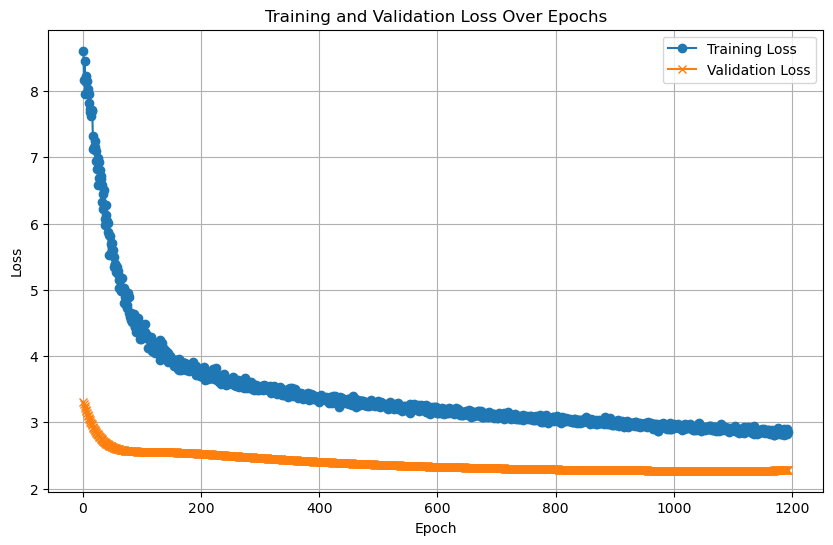

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/579], Loss: 5.3564
Test Batch [20/579], Loss: 5.2191
Test Batch [30/579], Loss: 5.3423
Test Batch [40/579], Loss: 5.3521
Test Batch [50/579], Loss: 5.2750
Test Batch [60/579], Loss: 5.3543
Test Batch [70/579], Loss: 5.4837
Test Batch [80/579], Loss: 5.2081
Test Batch [90/579], Loss: 5.2272
Test Batch [100/579], Loss: 5.2889
Test Batch [110/579], Loss: 5.2604
Test Batch [120/579], Loss: 5.2796
Test Batch [130/579], Loss: 5.3361
Test Batch [140/579], Loss: 5.2992
Test Batch [150/579], Loss: 5.2262


Test Batch [160/579], Loss: 5.1852
Test Batch [170/579], Loss: 5.2456
Test Batch [180/579], Loss: 5.0359
Test Batch [190/579], Loss: 5.3205
Test Batch [200/579], Loss: 5.3092
Test Batch [210/579], Loss: 5.2774
Test Batch [220/579], Loss: 5.4601
Test Batch [230/579], Loss: 5.3350
Test Batch [240/579], Loss: 5.4335
Test Batch [250/579], Loss: 5.2584
Test Batch [260/579], Loss: 5.2667
Test Batch [270/579], Loss: 5.2289
Test Batch [280/579], Loss: 5.0494
Test Batch [290/579], Loss: 5.4611
Test Batch [300/579], Loss: 5.4016
Test Batch [310/579], Loss: 5.5395
Test Batch [320/579], Loss: 5.5537


Test Batch [330/579], Loss: 5.4597
Test Batch [340/579], Loss: 5.3749
Test Batch [350/579], Loss: 5.3177
Test Batch [360/579], Loss: 5.6658
Test Batch [370/579], Loss: 5.7426
Test Batch [380/579], Loss: 5.1438
Test Batch [390/579], Loss: 5.7082
Test Batch [400/579], Loss: 5.6913
Test Batch [410/579], Loss: 5.6345
Test Batch [420/579], Loss: 5.4811
Test Batch [430/579], Loss: 5.9375
Test Batch [440/579], Loss: 5.8505


Test Batch [450/579], Loss: 5.8215
Test Batch [460/579], Loss: 5.9802
Test Batch [470/579], Loss: 5.8000
Test Batch [480/579], Loss: 5.1825
Test Batch [490/579], Loss: 5.2253
Test Batch [500/579], Loss: 5.5798
Test Batch [510/579], Loss: 5.5174
Test Batch [520/579], Loss: 4.4571
Test Batch [530/579], Loss: 4.8379
Test Batch [540/579], Loss: 5.1292
Test Batch [550/579], Loss: 5.1580
Test Batch [560/579], Loss: 5.0956
Test Batch [570/579], Loss: 5.2142

Test Loss: 5.3532


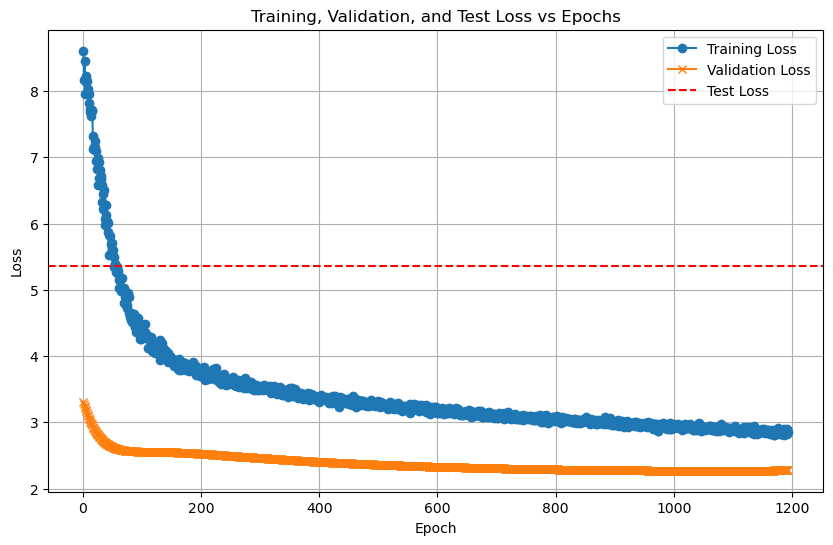

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/579 for test dataset.
  Processed batch 20/579 for test dataset.
  Processed batch 30/579 for test dataset.
  Processed batch 40/579 for test dataset.
  Processed batch 50/579 for test dataset.


  Processed batch 60/579 for test dataset.
  Processed batch 70/579 for test dataset.
  Processed batch 80/579 for test dataset.
  Processed batch 90/579 for test dataset.
  Processed batch 100/579 for test dataset.
  Processed batch 110/579 for test dataset.
  Processed batch 120/579 for test dataset.


  Processed batch 130/579 for test dataset.
  Processed batch 140/579 for test dataset.
  Processed batch 150/579 for test dataset.
  Processed batch 160/579 for test dataset.
  Processed batch 170/579 for test dataset.
  Processed batch 180/579 for test dataset.
  Processed batch 190/579 for test dataset.


  Processed batch 200/579 for test dataset.
  Processed batch 210/579 for test dataset.
  Processed batch 220/579 for test dataset.
  Processed batch 230/579 for test dataset.
  Processed batch 240/579 for test dataset.
  Processed batch 250/579 for test dataset.
  Processed batch 260/579 for test dataset.


  Processed batch 270/579 for test dataset.
  Processed batch 280/579 for test dataset.
  Processed batch 290/579 for test dataset.
  Processed batch 300/579 for test dataset.
  Processed batch 310/579 for test dataset.
  Processed batch 320/579 for test dataset.
  Processed batch 330/579 for test dataset.


  Processed batch 340/579 for test dataset.
  Processed batch 350/579 for test dataset.
  Processed batch 360/579 for test dataset.
  Processed batch 370/579 for test dataset.
  Processed batch 380/579 for test dataset.
  Processed batch 390/579 for test dataset.


  Processed batch 400/579 for test dataset.
  Processed batch 410/579 for test dataset.
  Processed batch 420/579 for test dataset.
  Processed batch 430/579 for test dataset.
  Processed batch 440/579 for test dataset.
  Processed batch 450/579 for test dataset.
  Processed batch 460/579 for test dataset.


  Processed batch 470/579 for test dataset.
  Processed batch 480/579 for test dataset.
  Processed batch 490/579 for test dataset.
  Processed batch 500/579 for test dataset.
  Processed batch 510/579 for test dataset.
  Processed batch 520/579 for test dataset.
  Processed batch 530/579 for test dataset.


  Processed batch 540/579 for test dataset.
  Processed batch 550/579 for test dataset.
  Processed batch 560/579 for test dataset.
  Processed batch 570/579 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148017, 128)
Test labels shape: (148017,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 82.22%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.80      0.80      0.80         5
           2       0.75      0.60      0.67         5
           3       0.67      0.40      0.50         5
           4       0.50      0.80      0.62         5
           5       0.83      1.00      0.91         5
           6       1.00      0.80      0.89         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           0.82        45
   macro avg       0.84      0.82      0.82        45
weighted avg       0.84      0.82      0.82        45


LOG: Evaluating on the test set...
Test Accuracy: 95.14%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     65956
           1       0.91      0.87      0.89      7583
           2       0.70      0.75      0.73      3075
           3       0.68      0.69      0.68      2670
           4       0.81      0.89      0.85      6569
           5       0.80      0.93      0.86      9233
           6       0.88      0.89      0.89      7272
           7       1.00      0.95      0.97     42811
           8       0.92      1.00      0.96      2848

    accuracy                           0.95    148017
   macro avg       0.86      0.88      0.87    148017
weighted avg       0.95      0.95      0.95    148017

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148017, 128)
Test labels shape: (148017,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3675  |  Val Loss: 2.3212
Validation loss improved from inf to 2.3212.
[Epoch 2/1000] Train Loss: 2.3427  |  Val Loss: 2.2997
Validation loss improved from 2.3212 to 2.2997.
[Epoch 3/1000] Train Loss: 2.3174  |  Val Loss: 2.2790
Validation loss improved from 2.2997 to 2.2790.
[Epoch 4/1000] Train Loss: 2.2932  |  Val Loss: 2.2588
Validation loss improved from 2.2790 to 2.2588.
[Epoch 5/1000] Train Loss: 2.2698  |  Val Loss: 2.2396
Validation loss improved from 2.2588 to 2.2396.
[Epoch 6/1000] Train Loss: 2.2460  |  Val Loss: 2.2213
Validation loss improved from 2.2396 to 2.2213.
[Epoch 7/1000] Train Loss: 2.2241  |  Val Loss: 2.2033
Validation loss improved from 2.2213 to 2.2033.
[Epoch 8/1000] Train Loss: 2.2025  |  Val Loss: 2.1856
Validation loss improved from 2.2033 to 2.1856.
[Epoch 9/1000] Train Loss: 2.1823  |  Val Loss: 2.1683
Validation loss improved from 2.1856 to 2.1683.
[Epoch 10/1000] Train Loss: 2.1619  |  Val Loss: 2.1516
Validation loss impr

[Epoch 41/1000] Train Loss: 1.6710  |  Val Loss: 1.7156
Validation loss improved from 1.7272 to 1.7156.
[Epoch 42/1000] Train Loss: 1.6582  |  Val Loss: 1.7041
Validation loss improved from 1.7156 to 1.7041.
[Epoch 43/1000] Train Loss: 1.6458  |  Val Loss: 1.6928
Validation loss improved from 1.7041 to 1.6928.
[Epoch 44/1000] Train Loss: 1.6338  |  Val Loss: 1.6816
Validation loss improved from 1.6928 to 1.6816.
[Epoch 45/1000] Train Loss: 1.6220  |  Val Loss: 1.6705
Validation loss improved from 1.6816 to 1.6705.
[Epoch 46/1000] Train Loss: 1.6101  |  Val Loss: 1.6597
Validation loss improved from 1.6705 to 1.6597.
[Epoch 47/1000] Train Loss: 1.5985  |  Val Loss: 1.6487
Validation loss improved from 1.6597 to 1.6487.
[Epoch 48/1000] Train Loss: 1.5872  |  Val Loss: 1.6377
Validation loss improved from 1.6487 to 1.6377.
[Epoch 49/1000] Train Loss: 1.5756  |  Val Loss: 1.6269
Validation loss improved from 1.6377 to 1.6269.
[Epoch 50/1000] Train Loss: 1.5643  |  Val Loss: 1.6162
Validati

[Epoch 87/1000] Train Loss: 1.1605  |  Val Loss: 1.2636
Validation loss improved from 1.2722 to 1.2636.
[Epoch 88/1000] Train Loss: 1.1509  |  Val Loss: 1.2552
Validation loss improved from 1.2636 to 1.2552.
[Epoch 89/1000] Train Loss: 1.1413  |  Val Loss: 1.2470
Validation loss improved from 1.2552 to 1.2470.
[Epoch 90/1000] Train Loss: 1.1316  |  Val Loss: 1.2389
Validation loss improved from 1.2470 to 1.2389.
[Epoch 91/1000] Train Loss: 1.1221  |  Val Loss: 1.2309
Validation loss improved from 1.2389 to 1.2309.
[Epoch 92/1000] Train Loss: 1.1127  |  Val Loss: 1.2230
Validation loss improved from 1.2309 to 1.2230.
[Epoch 93/1000] Train Loss: 1.1032  |  Val Loss: 1.2151
Validation loss improved from 1.2230 to 1.2151.
[Epoch 94/1000] Train Loss: 1.0938  |  Val Loss: 1.2073
Validation loss improved from 1.2151 to 1.2073.
[Epoch 95/1000] Train Loss: 1.0844  |  Val Loss: 1.1995
Validation loss improved from 1.2073 to 1.1995.
[Epoch 96/1000] Train Loss: 1.0753  |  Val Loss: 1.1918
Validati

[Epoch 129/1000] Train Loss: 0.8046  |  Val Loss: 0.9587
Validation loss improved from 0.9647 to 0.9587.
[Epoch 130/1000] Train Loss: 0.7972  |  Val Loss: 0.9526
Validation loss improved from 0.9587 to 0.9526.
[Epoch 131/1000] Train Loss: 0.7895  |  Val Loss: 0.9465
Validation loss improved from 0.9526 to 0.9465.
[Epoch 132/1000] Train Loss: 0.7825  |  Val Loss: 0.9403
Validation loss improved from 0.9465 to 0.9403.
[Epoch 133/1000] Train Loss: 0.7746  |  Val Loss: 0.9344
Validation loss improved from 0.9403 to 0.9344.
[Epoch 134/1000] Train Loss: 0.7674  |  Val Loss: 0.9285
Validation loss improved from 0.9344 to 0.9285.
[Epoch 135/1000] Train Loss: 0.7599  |  Val Loss: 0.9228
Validation loss improved from 0.9285 to 0.9228.
[Epoch 136/1000] Train Loss: 0.7526  |  Val Loss: 0.9170
Validation loss improved from 0.9228 to 0.9170.
[Epoch 137/1000] Train Loss: 0.7452  |  Val Loss: 0.9113
Validation loss improved from 0.9170 to 0.9113.
[Epoch 138/1000] Train Loss: 0.7379  |  Val Loss: 0.905

[Epoch 175/1000] Train Loss: 0.5008  |  Val Loss: 0.7072
Validation loss improved from 0.7119 to 0.7072.
[Epoch 176/1000] Train Loss: 0.4954  |  Val Loss: 0.7024
Validation loss improved from 0.7072 to 0.7024.
[Epoch 177/1000] Train Loss: 0.4898  |  Val Loss: 0.6974
Validation loss improved from 0.7024 to 0.6974.
[Epoch 178/1000] Train Loss: 0.4844  |  Val Loss: 0.6924
Validation loss improved from 0.6974 to 0.6924.
[Epoch 179/1000] Train Loss: 0.4789  |  Val Loss: 0.6876
Validation loss improved from 0.6924 to 0.6876.
[Epoch 180/1000] Train Loss: 0.4734  |  Val Loss: 0.6826
Validation loss improved from 0.6876 to 0.6826.
[Epoch 181/1000] Train Loss: 0.4679  |  Val Loss: 0.6777
Validation loss improved from 0.6826 to 0.6777.
[Epoch 182/1000] Train Loss: 0.4625  |  Val Loss: 0.6729
Validation loss improved from 0.6777 to 0.6729.
[Epoch 183/1000] Train Loss: 0.4569  |  Val Loss: 0.6684
Validation loss improved from 0.6729 to 0.6684.
[Epoch 184/1000] Train Loss: 0.4516  |  Val Loss: 0.664

[Epoch 221/1000] Train Loss: 0.2913  |  Val Loss: 0.5317
Validation loss improved from 0.5343 to 0.5317.
[Epoch 222/1000] Train Loss: 0.2878  |  Val Loss: 0.5294
Validation loss improved from 0.5317 to 0.5294.
[Epoch 223/1000] Train Loss: 0.2843  |  Val Loss: 0.5273
Validation loss improved from 0.5294 to 0.5273.
[Epoch 224/1000] Train Loss: 0.2809  |  Val Loss: 0.5252
Validation loss improved from 0.5273 to 0.5252.
[Epoch 225/1000] Train Loss: 0.2774  |  Val Loss: 0.5230
Validation loss improved from 0.5252 to 0.5230.
[Epoch 226/1000] Train Loss: 0.2741  |  Val Loss: 0.5208
Validation loss improved from 0.5230 to 0.5208.
[Epoch 227/1000] Train Loss: 0.2706  |  Val Loss: 0.5186
Validation loss improved from 0.5208 to 0.5186.
[Epoch 228/1000] Train Loss: 0.2674  |  Val Loss: 0.5168
Validation loss improved from 0.5186 to 0.5168.
[Epoch 229/1000] Train Loss: 0.2643  |  Val Loss: 0.5150
Validation loss improved from 0.5168 to 0.5150.
[Epoch 230/1000] Train Loss: 0.2610  |  Val Loss: 0.513

[Epoch 270/1000] Train Loss: 0.1711  |  Val Loss: 0.4435
Validation loss improved from 0.4453 to 0.4435.
[Epoch 271/1000] Train Loss: 0.1697  |  Val Loss: 0.4418
Validation loss improved from 0.4435 to 0.4418.
[Epoch 272/1000] Train Loss: 0.1680  |  Val Loss: 0.4403
Validation loss improved from 0.4418 to 0.4403.
[Epoch 273/1000] Train Loss: 0.1665  |  Val Loss: 0.4387
Validation loss improved from 0.4403 to 0.4387.
[Epoch 274/1000] Train Loss: 0.1651  |  Val Loss: 0.4372
Validation loss improved from 0.4387 to 0.4372.
[Epoch 275/1000] Train Loss: 0.1635  |  Val Loss: 0.4362
Validation loss improved from 0.4372 to 0.4362.
[Epoch 276/1000] Train Loss: 0.1620  |  Val Loss: 0.4354
Validation loss improved from 0.4362 to 0.4354.
[Epoch 277/1000] Train Loss: 0.1606  |  Val Loss: 0.4348
Validation loss improved from 0.4354 to 0.4348.
[Epoch 278/1000] Train Loss: 0.1591  |  Val Loss: 0.4344
Validation loss improved from 0.4348 to 0.4344.
[Epoch 279/1000] Train Loss: 0.1578  |  Val Loss: 0.434

[Epoch 315/1000] Train Loss: 0.1191  |  Val Loss: 0.4104
Validation loss improved from 0.4110 to 0.4104.
[Epoch 316/1000] Train Loss: 0.1182  |  Val Loss: 0.4099
Validation loss improved from 0.4104 to 0.4099.
[Epoch 317/1000] Train Loss: 0.1174  |  Val Loss: 0.4096
Validation loss improved from 0.4099 to 0.4096.
[Epoch 318/1000] Train Loss: 0.1165  |  Val Loss: 0.4091
Validation loss improved from 0.4096 to 0.4091.
[Epoch 319/1000] Train Loss: 0.1158  |  Val Loss: 0.4085
Validation loss improved from 0.4091 to 0.4085.
[Epoch 320/1000] Train Loss: 0.1150  |  Val Loss: 0.4076
Validation loss improved from 0.4085 to 0.4076.
[Epoch 321/1000] Train Loss: 0.1141  |  Val Loss: 0.4072
Validation loss improved from 0.4076 to 0.4072.
[Epoch 322/1000] Train Loss: 0.1134  |  Val Loss: 0.4070
Validation loss improved from 0.4072 to 0.4070.
[Epoch 323/1000] Train Loss: 0.1125  |  Val Loss: 0.4071
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 324/1000] Train Loss: 0.1118  |  Val Loss:

[Epoch 361/1000] Train Loss: 0.0908  |  Val Loss: 0.4035
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 362/1000] Train Loss: 0.0904  |  Val Loss: 0.4038
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 363/1000] Train Loss: 0.0900  |  Val Loss: 0.4040
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 364/1000] Train Loss: 0.0895  |  Val Loss: 0.4042
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 365/1000] Train Loss: 0.0891  |  Val Loss: 0.4041
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 366/1000] Train Loss: 0.0886  |  Val Loss: 0.4036
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 367/1000] Train Loss: 0.0883  |  Val Loss: 0.4031
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 368/1000] Train Loss: 0.0880  |  Val Loss: 0.4024
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 369/1000] Train Loss: 0.0873  |  Val Loss: 0.4022
!! Validation loss did NOT improve !! Patience:

[Epoch 409/1000] Train Loss: 0.0736  |  Val Loss: 0.3994
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 410/1000] Train Loss: 0.0734  |  Val Loss: 0.3986
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 411/1000] Train Loss: 0.0731  |  Val Loss: 0.3983
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 412/1000] Train Loss: 0.0729  |  Val Loss: 0.3981
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 413/1000] Train Loss: 0.0725  |  Val Loss: 0.3975
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 414/1000] Train Loss: 0.0726  |  Val Loss: 0.3971
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 415/1000] Train Loss: 0.0722  |  Val Loss: 0.3971
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 416/1000] Train Loss: 0.0719  |  Val Loss: 0.3973
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 417/1000] Train Loss: 0.0715  |  Val Loss: 0.3978
!! Validation loss did NOT improve !! Patience:

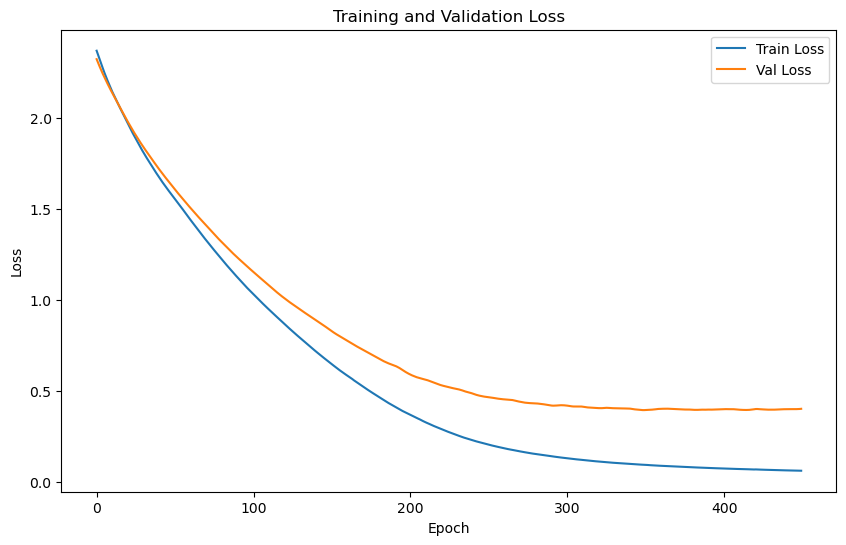

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.1801 | Test Accuracy: 94.85%


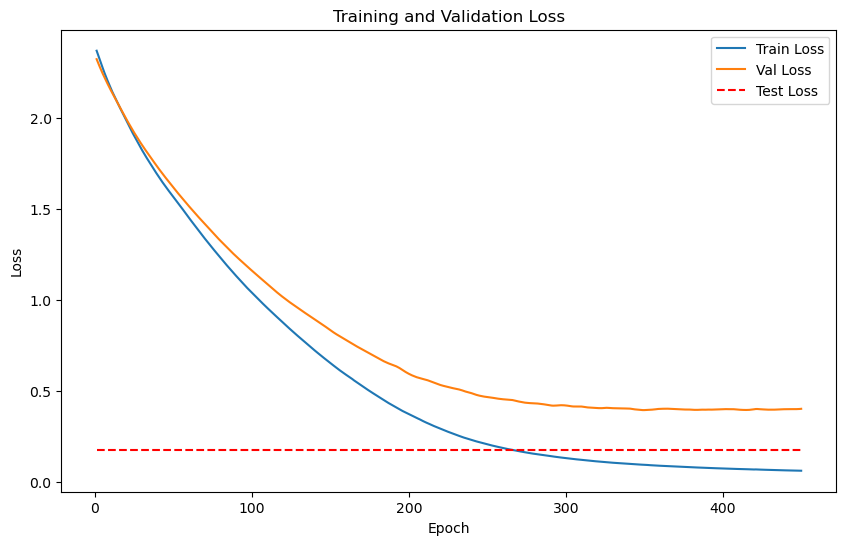

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148017 samples with 64 features each
LOG: Labels shape: (148017,)


Train embeddings shape: (90, 64), 
Train labels shape: (90,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (148017, 64), 
Test labels shape: (148017,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}
Training batch size: 90


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.3904
Epoch [1/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.3904

Validation loss improved from inf to 0.3904. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 0.4498
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.3916
Epoch [2/2000], Avg Train Loss: 0.4498, Avg Val Loss: 0.3916

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4524
LOG: Epoch [3/2000] - Validation
    Batch [1/1], Val Loss: 0.3920
Epoch [3/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.3920

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.4442
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.3922
Epoch [4/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.3922

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 0.4464
LOG: Epoch [5/2000] - Validation


    Batch [1/1], Val Loss: 0.3923
Epoch [5/2000], Avg Train Loss: 0.4464, Avg Val Loss: 0.3923

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 0.4436
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.3923
Epoch [6/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.3923

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [7/2000] - Validation


    Batch [1/1], Val Loss: 0.3926
Epoch [7/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.3926

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.3927
Epoch [8/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.3927

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [9/2000] - Validation


    Batch [1/1], Val Loss: 0.3928
Epoch [9/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.3928

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.4331
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.3925
Epoch [10/2000], Avg Train Loss: 0.4331, Avg Val Loss: 0.3925

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.4405
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.3920
Epoch [11/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.3920

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4362
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.3916
Epoch [12/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.3916

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.4376
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.3909
Epoch [13/2000], Avg Train Loss: 0.4376, Avg Val Loss: 0.3909

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.3905
Epoch [14/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.3905

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.4287
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.3899
Epoch [15/2000], Avg Train Loss: 0.4287, Avg Val Loss: 0.3899

Validation loss improved from 0.3904 to 0.3899. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4274
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.3893
Epoch [16/2000], Avg Train Loss: 0.4274, Avg Val Loss: 0.3893

Validation loss improved from 0.3899 to 0.3893. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 0.4280
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.3888
Epoch [17/2000], Avg Train Loss: 0.4280, Avg Val Loss: 0.3888

Validation loss improved from 0.3893 to 0.3888. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.4368
LOG: Epoch [18/2000] - Validation


    Batch [1/1], Val Loss: 0.3883
Epoch [18/2000], Avg Train Loss: 0.4368, Avg Val Loss: 0.3883

Validation loss improved from 0.3888 to 0.3883. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.4281
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.3878
Epoch [19/2000], Avg Train Loss: 0.4281, Avg Val Loss: 0.3878

Validation loss improved from 0.3883 to 0.3878. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4294
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.3872
Epoch [20/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.3872

Validation loss improved from 0.3878 to 0.3872. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.3866
Epoch [21/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.3866

Validation loss improved from 0.3872 to 0.3866. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.4254
LOG: Epoch [22/2000] - Validation


    Batch [1/1], Val Loss: 0.3861
Epoch [22/2000], Avg Train Loss: 0.4254, Avg Val Loss: 0.3861

Validation loss improved from 0.3866 to 0.3861. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.4174
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.3856
Epoch [23/2000], Avg Train Loss: 0.4174, Avg Val Loss: 0.3856

Validation loss improved from 0.3861 to 0.3856. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.4234
LOG: Epoch [24/2000] - Validation


    Batch [1/1], Val Loss: 0.3852
Epoch [24/2000], Avg Train Loss: 0.4234, Avg Val Loss: 0.3852

Validation loss improved from 0.3856 to 0.3852. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.4300
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.3848
Epoch [25/2000], Avg Train Loss: 0.4300, Avg Val Loss: 0.3848

Validation loss improved from 0.3852 to 0.3848. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.4251
LOG: Epoch [26/2000] - Validation


    Batch [1/1], Val Loss: 0.3844
Epoch [26/2000], Avg Train Loss: 0.4251, Avg Val Loss: 0.3844

Validation loss improved from 0.3848 to 0.3844. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.4263
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.3840
Epoch [27/2000], Avg Train Loss: 0.4263, Avg Val Loss: 0.3840

Validation loss improved from 0.3844 to 0.3840. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.4258
LOG: Epoch [28/2000] - Validation


    Batch [1/1], Val Loss: 0.3835
Epoch [28/2000], Avg Train Loss: 0.4258, Avg Val Loss: 0.3835

Validation loss improved from 0.3840 to 0.3835. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.3831
Epoch [29/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.3831

Validation loss improved from 0.3835 to 0.3831. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.4146
LOG: Epoch [30/2000] - Validation


    Batch [1/1], Val Loss: 0.3826
Epoch [30/2000], Avg Train Loss: 0.4146, Avg Val Loss: 0.3826

Validation loss improved from 0.3831 to 0.3826. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.3822
Epoch [31/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.3822

Validation loss improved from 0.3826 to 0.3822. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.4134
LOG: Epoch [32/2000] - Validation


    Batch [1/1], Val Loss: 0.3817
Epoch [32/2000], Avg Train Loss: 0.4134, Avg Val Loss: 0.3817

Validation loss improved from 0.3822 to 0.3817. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.4175
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.3813
Epoch [33/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.3813

Validation loss improved from 0.3817 to 0.3813. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.4138
LOG: Epoch [34/2000] - Validation


    Batch [1/1], Val Loss: 0.3808
Epoch [34/2000], Avg Train Loss: 0.4138, Avg Val Loss: 0.3808

Validation loss improved from 0.3813 to 0.3808. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.4113
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.3804
Epoch [35/2000], Avg Train Loss: 0.4113, Avg Val Loss: 0.3804

Validation loss improved from 0.3808 to 0.3804. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [36/2000] - Validation


    Batch [1/1], Val Loss: 0.3800
Epoch [36/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.3800

Validation loss improved from 0.3804 to 0.3800. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.4145
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.3795
Epoch [37/2000], Avg Train Loss: 0.4145, Avg Val Loss: 0.3795

Validation loss improved from 0.3800 to 0.3795. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.4119
LOG: Epoch [38/2000] - Validation


    Batch [1/1], Val Loss: 0.3791
Epoch [38/2000], Avg Train Loss: 0.4119, Avg Val Loss: 0.3791

Validation loss improved from 0.3795 to 0.3791. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.3787
Epoch [39/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.3787

Validation loss improved from 0.3791 to 0.3787. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.3782
Epoch [40/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.3782

Validation loss improved from 0.3787 to 0.3782. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4140
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.3778
Epoch [41/2000], Avg Train Loss: 0.4140, Avg Val Loss: 0.3778

Validation loss improved from 0.3782 to 0.3778. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.4158
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.3774
Epoch [42/2000], Avg Train Loss: 0.4158, Avg Val Loss: 0.3774

Validation loss improved from 0.3778 to 0.3774. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.4074
LOG: Epoch [43/2000] - Validation


    Batch [1/1], Val Loss: 0.3770
Epoch [43/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.3770

Validation loss improved from 0.3774 to 0.3770. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.3765
Epoch [44/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.3765

Validation loss improved from 0.3770 to 0.3765. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [45/2000] - Validation


    Batch [1/1], Val Loss: 0.3761
Epoch [45/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.3761

Validation loss improved from 0.3765 to 0.3761. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.4121
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [46/2000], Avg Train Loss: 0.4121, Avg Val Loss: 0.3757

Validation loss improved from 0.3761 to 0.3757. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.3753
Epoch [47/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.3753

Validation loss improved from 0.3757 to 0.3753. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.3979
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.3749
Epoch [48/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.3749

Validation loss improved from 0.3753 to 0.3749. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.3744
Epoch [49/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.3744

Validation loss improved from 0.3749 to 0.3744. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.3740
Epoch [50/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.3740

Validation loss improved from 0.3744 to 0.3740. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [51/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.3736

Validation loss improved from 0.3740 to 0.3736. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [52/2000] - Validation


    Batch [1/1], Val Loss: 0.3731
Epoch [52/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.3731

Validation loss improved from 0.3736 to 0.3731. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.3727
Epoch [53/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.3727

Validation loss improved from 0.3731 to 0.3727. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [54/2000] - Validation


    Batch [1/1], Val Loss: 0.3723
Epoch [54/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.3723

Validation loss improved from 0.3727 to 0.3723. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.3719
Epoch [55/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.3719

Validation loss improved from 0.3723 to 0.3719. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [56/2000] - Validation


    Batch [1/1], Val Loss: 0.3715
Epoch [56/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.3715

Validation loss improved from 0.3719 to 0.3715. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.3711
Epoch [57/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.3711

Validation loss improved from 0.3715 to 0.3711. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [58/2000] - Validation


    Batch [1/1], Val Loss: 0.3707
Epoch [58/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.3707

Validation loss improved from 0.3711 to 0.3707. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.3703
Epoch [59/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.3703

Validation loss improved from 0.3707 to 0.3703. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [60/2000] - Validation


    Batch [1/1], Val Loss: 0.3699
Epoch [60/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3699

Validation loss improved from 0.3703 to 0.3699. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.3694
Epoch [61/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.3694

Validation loss improved from 0.3699 to 0.3694. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.3831
LOG: Epoch [62/2000] - Validation


    Batch [1/1], Val Loss: 0.3690
Epoch [62/2000], Avg Train Loss: 0.3831, Avg Val Loss: 0.3690

Validation loss improved from 0.3694 to 0.3690. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.3860
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.3686
Epoch [63/2000], Avg Train Loss: 0.3860, Avg Val Loss: 0.3686

Validation loss improved from 0.3690 to 0.3686. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [64/2000] - Validation


    Batch [1/1], Val Loss: 0.3682
Epoch [64/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.3682

Validation loss improved from 0.3686 to 0.3682. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.3677
Epoch [65/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.3677

Validation loss improved from 0.3682 to 0.3677. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [66/2000] - Validation


    Batch [1/1], Val Loss: 0.3673
Epoch [66/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.3673

Validation loss improved from 0.3677 to 0.3673. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.3669
Epoch [67/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.3669

Validation loss improved from 0.3673 to 0.3669. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.3845
LOG: Epoch [68/2000] - Validation


    Batch [1/1], Val Loss: 0.3665
Epoch [68/2000], Avg Train Loss: 0.3845, Avg Val Loss: 0.3665

Validation loss improved from 0.3669 to 0.3665. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.3818
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.3660
Epoch [69/2000], Avg Train Loss: 0.3818, Avg Val Loss: 0.3660

Validation loss improved from 0.3665 to 0.3660. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.3751
LOG: Epoch [70/2000] - Validation


    Batch [1/1], Val Loss: 0.3656
Epoch [70/2000], Avg Train Loss: 0.3751, Avg Val Loss: 0.3656

Validation loss improved from 0.3660 to 0.3656. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.3792
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.3652
Epoch [71/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.3652

Validation loss improved from 0.3656 to 0.3652. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.3737
LOG: Epoch [72/2000] - Validation


    Batch [1/1], Val Loss: 0.3648
Epoch [72/2000], Avg Train Loss: 0.3737, Avg Val Loss: 0.3648

Validation loss improved from 0.3652 to 0.3648. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.3644
Epoch [73/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.3644

Validation loss improved from 0.3648 to 0.3644. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.3730
LOG: Epoch [74/2000] - Validation


    Batch [1/1], Val Loss: 0.3639
Epoch [74/2000], Avg Train Loss: 0.3730, Avg Val Loss: 0.3639

Validation loss improved from 0.3644 to 0.3639. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.3740
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.3635
Epoch [75/2000], Avg Train Loss: 0.3740, Avg Val Loss: 0.3635

Validation loss improved from 0.3639 to 0.3635. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.3780
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.3631
Epoch [76/2000], Avg Train Loss: 0.3780, Avg Val Loss: 0.3631

Validation loss improved from 0.3635 to 0.3631. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.3824
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.3626
Epoch [77/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.3626

Validation loss improved from 0.3631 to 0.3626. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.3754
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.3621
Epoch [78/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.3621

Validation loss improved from 0.3626 to 0.3621. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.3771
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.3617
Epoch [79/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.3617

Validation loss improved from 0.3621 to 0.3617. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.3734
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.3612
Epoch [80/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.3612

Validation loss improved from 0.3617 to 0.3612. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.3633
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.3608
Epoch [81/2000], Avg Train Loss: 0.3633, Avg Val Loss: 0.3608

Validation loss improved from 0.3612 to 0.3608. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [82/2000] - Validation


    Batch [1/1], Val Loss: 0.3604
Epoch [82/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.3604

Validation loss improved from 0.3608 to 0.3604. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.3703
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.3599
Epoch [83/2000], Avg Train Loss: 0.3703, Avg Val Loss: 0.3599

Validation loss improved from 0.3604 to 0.3599. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.3662
LOG: Epoch [84/2000] - Validation


    Batch [1/1], Val Loss: 0.3595
Epoch [84/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.3595

Validation loss improved from 0.3599 to 0.3595. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.3725
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.3591
Epoch [85/2000], Avg Train Loss: 0.3725, Avg Val Loss: 0.3591

Validation loss improved from 0.3595 to 0.3591. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [86/2000] - Validation


    Batch [1/1], Val Loss: 0.3587
Epoch [86/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.3587

Validation loss improved from 0.3591 to 0.3587. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.3582
Epoch [87/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.3582

Validation loss improved from 0.3587 to 0.3582. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [88/2000] - Validation


    Batch [1/1], Val Loss: 0.3578
Epoch [88/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.3578

Validation loss improved from 0.3582 to 0.3578. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.3555
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.3573
Epoch [89/2000], Avg Train Loss: 0.3555, Avg Val Loss: 0.3573

Validation loss improved from 0.3578 to 0.3573. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.3621
LOG: Epoch [90/2000] - Validation


    Batch [1/1], Val Loss: 0.3569
Epoch [90/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.3569

Validation loss improved from 0.3573 to 0.3569. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.3618
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.3565
Epoch [91/2000], Avg Train Loss: 0.3618, Avg Val Loss: 0.3565

Validation loss improved from 0.3569 to 0.3565. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.3561
Epoch [92/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.3561

Validation loss improved from 0.3565 to 0.3561. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.3593
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [93/2000], Avg Train Loss: 0.3593, Avg Val Loss: 0.3557

Validation loss improved from 0.3561 to 0.3557. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.3637
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.3553
Epoch [94/2000], Avg Train Loss: 0.3637, Avg Val Loss: 0.3553

Validation loss improved from 0.3557 to 0.3553. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.3573
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.3550
Epoch [95/2000], Avg Train Loss: 0.3573, Avg Val Loss: 0.3550

Validation loss improved from 0.3553 to 0.3550. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.3577
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [96/2000], Avg Train Loss: 0.3577, Avg Val Loss: 0.3546

Validation loss improved from 0.3550 to 0.3546. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [97/2000] - Validation


    Batch [1/1], Val Loss: 0.3542
Epoch [97/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.3542

Validation loss improved from 0.3546 to 0.3542. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.3590
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.3538
Epoch [98/2000], Avg Train Loss: 0.3590, Avg Val Loss: 0.3538

Validation loss improved from 0.3542 to 0.3538. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.3595
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.3534
Epoch [99/2000], Avg Train Loss: 0.3595, Avg Val Loss: 0.3534

Validation loss improved from 0.3538 to 0.3534. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.3558
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.3530
Epoch [100/2000], Avg Train Loss: 0.3558, Avg Val Loss: 0.3530

Validation loss improved from 0.3534 to 0.3530. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.3575
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.3526
Epoch [101/2000], Avg Train Loss: 0.3575, Avg Val Loss: 0.3526

Validation loss improved from 0.3530 to 0.3526. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.3553
LOG: Epoch [102/2000] - Validation


    Batch [1/1], Val Loss: 0.3522
Epoch [102/2000], Avg Train Loss: 0.3553, Avg Val Loss: 0.3522

Validation loss improved from 0.3526 to 0.3522. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.3498
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.3518
Epoch [103/2000], Avg Train Loss: 0.3498, Avg Val Loss: 0.3518

Validation loss improved from 0.3522 to 0.3518. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.3543
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.3514
Epoch [104/2000], Avg Train Loss: 0.3543, Avg Val Loss: 0.3514

Validation loss improved from 0.3518 to 0.3514. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.3570
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.3511
Epoch [105/2000], Avg Train Loss: 0.3570, Avg Val Loss: 0.3511

Validation loss improved from 0.3514 to 0.3511. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.3547
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.3507
Epoch [106/2000], Avg Train Loss: 0.3547, Avg Val Loss: 0.3507

Validation loss improved from 0.3511 to 0.3507. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.3528
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.3503
Epoch [107/2000], Avg Train Loss: 0.3528, Avg Val Loss: 0.3503

Validation loss improved from 0.3507 to 0.3503. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.3558
LOG: Epoch [108/2000] - Validation


    Batch [1/1], Val Loss: 0.3500
Epoch [108/2000], Avg Train Loss: 0.3558, Avg Val Loss: 0.3500

Validation loss improved from 0.3503 to 0.3500. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.3496
Epoch [109/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.3496

Validation loss improved from 0.3500 to 0.3496. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.3386
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.3492
Epoch [110/2000], Avg Train Loss: 0.3386, Avg Val Loss: 0.3492

Validation loss improved from 0.3496 to 0.3492. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.3516
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.3488
Epoch [111/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.3488

Validation loss improved from 0.3492 to 0.3488. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.3557
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.3485
Epoch [112/2000], Avg Train Loss: 0.3557, Avg Val Loss: 0.3485

Validation loss improved from 0.3488 to 0.3485. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.3482
Epoch [113/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.3482

Validation loss improved from 0.3485 to 0.3482. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.3483
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.3478
Epoch [114/2000], Avg Train Loss: 0.3483, Avg Val Loss: 0.3478

Validation loss improved from 0.3482 to 0.3478. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.3504
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.3475
Epoch [115/2000], Avg Train Loss: 0.3504, Avg Val Loss: 0.3475

Validation loss improved from 0.3478 to 0.3475. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.3376
LOG: Epoch [116/2000] - Validation


    Batch [1/1], Val Loss: 0.3471
Epoch [116/2000], Avg Train Loss: 0.3376, Avg Val Loss: 0.3471

Validation loss improved from 0.3475 to 0.3471. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.3468
Epoch [117/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.3468

Validation loss improved from 0.3471 to 0.3468. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.3464
Epoch [118/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.3464

Validation loss improved from 0.3468 to 0.3464. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.3415
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.3461
Epoch [119/2000], Avg Train Loss: 0.3415, Avg Val Loss: 0.3461

Validation loss improved from 0.3464 to 0.3461. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.3362
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.3457
Epoch [120/2000], Avg Train Loss: 0.3362, Avg Val Loss: 0.3457

Validation loss improved from 0.3461 to 0.3457. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [121/2000] - Validation


    Batch [1/1], Val Loss: 0.3453
Epoch [121/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.3453

Validation loss improved from 0.3457 to 0.3453. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.3291
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.3450
Epoch [122/2000], Avg Train Loss: 0.3291, Avg Val Loss: 0.3450

Validation loss improved from 0.3453 to 0.3450. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.3339
LOG: Epoch [123/2000] - Validation


    Batch [1/1], Val Loss: 0.3447
Epoch [123/2000], Avg Train Loss: 0.3339, Avg Val Loss: 0.3447

Validation loss improved from 0.3450 to 0.3447. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.3377
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.3443
Epoch [124/2000], Avg Train Loss: 0.3377, Avg Val Loss: 0.3443

Validation loss improved from 0.3447 to 0.3443. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.3341
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.3440
Epoch [125/2000], Avg Train Loss: 0.3341, Avg Val Loss: 0.3440

Validation loss improved from 0.3443 to 0.3440. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.3350
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.3437
Epoch [126/2000], Avg Train Loss: 0.3350, Avg Val Loss: 0.3437

Validation loss improved from 0.3440 to 0.3437. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.3285
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.3433
Epoch [127/2000], Avg Train Loss: 0.3285, Avg Val Loss: 0.3433

Validation loss improved from 0.3437 to 0.3433. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.3316
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.3430
Epoch [128/2000], Avg Train Loss: 0.3316, Avg Val Loss: 0.3430

Validation loss improved from 0.3433 to 0.3430. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.3283
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.3427
Epoch [129/2000], Avg Train Loss: 0.3283, Avg Val Loss: 0.3427

Validation loss improved from 0.3430 to 0.3427. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.3407
LOG: Epoch [130/2000] - Validation


    Batch [1/1], Val Loss: 0.3424
Epoch [130/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.3424

Validation loss improved from 0.3427 to 0.3424. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.3240
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.3421
Epoch [131/2000], Avg Train Loss: 0.3240, Avg Val Loss: 0.3421

Validation loss improved from 0.3424 to 0.3421. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.3283
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.3418
Epoch [132/2000], Avg Train Loss: 0.3283, Avg Val Loss: 0.3418

Validation loss improved from 0.3421 to 0.3418. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.3339
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.3415
Epoch [133/2000], Avg Train Loss: 0.3339, Avg Val Loss: 0.3415

Validation loss improved from 0.3418 to 0.3415. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.3302
LOG: Epoch [134/2000] - Validation
    Batch [1/1], Val Loss: 0.3413
Epoch [134/2000], Avg Train Loss: 0.3302, Avg Val Loss: 0.3413

Validation loss improved from 0.3415 to 0.3413. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.3263
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.3410
Epoch [135/2000], Avg Train Loss: 0.3263, Avg Val Loss: 0.3410

Validation loss improved from 0.3413 to 0.3410. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.3193
LOG: Epoch [136/2000] - Validation


    Batch [1/1], Val Loss: 0.3407
Epoch [136/2000], Avg Train Loss: 0.3193, Avg Val Loss: 0.3407

Validation loss improved from 0.3410 to 0.3407. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.3309
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.3405
Epoch [137/2000], Avg Train Loss: 0.3309, Avg Val Loss: 0.3405

Validation loss improved from 0.3407 to 0.3405. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.3239
LOG: Epoch [138/2000] - Validation


    Batch [1/1], Val Loss: 0.3402
Epoch [138/2000], Avg Train Loss: 0.3239, Avg Val Loss: 0.3402

Validation loss improved from 0.3405 to 0.3402. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.3264
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.3400
Epoch [139/2000], Avg Train Loss: 0.3264, Avg Val Loss: 0.3400

Validation loss improved from 0.3402 to 0.3400. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.3281
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.3397
Epoch [140/2000], Avg Train Loss: 0.3281, Avg Val Loss: 0.3397

Validation loss improved from 0.3400 to 0.3397. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.3317
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.3395
Epoch [141/2000], Avg Train Loss: 0.3317, Avg Val Loss: 0.3395

Validation loss improved from 0.3397 to 0.3395. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.3185
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.3393
Epoch [142/2000], Avg Train Loss: 0.3185, Avg Val Loss: 0.3393

Validation loss improved from 0.3395 to 0.3393. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.3235
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.3390
Epoch [143/2000], Avg Train Loss: 0.3235, Avg Val Loss: 0.3390

Validation loss improved from 0.3393 to 0.3390. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.3206
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.3387
Epoch [144/2000], Avg Train Loss: 0.3206, Avg Val Loss: 0.3387

Validation loss improved from 0.3390 to 0.3387. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.3210
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.3385
Epoch [145/2000], Avg Train Loss: 0.3210, Avg Val Loss: 0.3385

Validation loss improved from 0.3387 to 0.3385. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.3263
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.3382
Epoch [146/2000], Avg Train Loss: 0.3263, Avg Val Loss: 0.3382

Validation loss improved from 0.3385 to 0.3382. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.3110
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.3379
Epoch [147/2000], Avg Train Loss: 0.3110, Avg Val Loss: 0.3379

Validation loss improved from 0.3382 to 0.3379. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 0.3198
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.3376
Epoch [148/2000], Avg Train Loss: 0.3198, Avg Val Loss: 0.3376

Validation loss improved from 0.3379 to 0.3376. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.3186
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.3373
Epoch [149/2000], Avg Train Loss: 0.3186, Avg Val Loss: 0.3373

Validation loss improved from 0.3376 to 0.3373. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.3164
LOG: Epoch [150/2000] - Validation
    Batch [1/1], Val Loss: 0.3370
Epoch [150/2000], Avg Train Loss: 0.3164, Avg Val Loss: 0.3370

Validation loss improved from 0.3373 to 0.3370. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.3112
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.3367
Epoch [151/2000], Avg Train Loss: 0.3112, Avg Val Loss: 0.3367

Validation loss improved from 0.3370 to 0.3367. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.3196
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.3364
Epoch [152/2000], Avg Train Loss: 0.3196, Avg Val Loss: 0.3364

Validation loss improved from 0.3367 to 0.3364. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.3203
LOG: Epoch [153/2000] - Validation


    Batch [1/1], Val Loss: 0.3361
Epoch [153/2000], Avg Train Loss: 0.3203, Avg Val Loss: 0.3361

Validation loss improved from 0.3364 to 0.3361. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.3131
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.3358
Epoch [154/2000], Avg Train Loss: 0.3131, Avg Val Loss: 0.3358

Validation loss improved from 0.3361 to 0.3358. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.3166
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.3356
Epoch [155/2000], Avg Train Loss: 0.3166, Avg Val Loss: 0.3356

Validation loss improved from 0.3358 to 0.3356. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.3116
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.3353
Epoch [156/2000], Avg Train Loss: 0.3116, Avg Val Loss: 0.3353

Validation loss improved from 0.3356 to 0.3353. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.3144
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.3350
Epoch [157/2000], Avg Train Loss: 0.3144, Avg Val Loss: 0.3350

Validation loss improved from 0.3353 to 0.3350. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.3179
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.3348
Epoch [158/2000], Avg Train Loss: 0.3179, Avg Val Loss: 0.3348

Validation loss improved from 0.3350 to 0.3348. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.3176
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.3345
Epoch [159/2000], Avg Train Loss: 0.3176, Avg Val Loss: 0.3345

Validation loss improved from 0.3348 to 0.3345. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.3215
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.3343
Epoch [160/2000], Avg Train Loss: 0.3215, Avg Val Loss: 0.3343

Validation loss improved from 0.3345 to 0.3343. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.3184
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.3340
Epoch [161/2000], Avg Train Loss: 0.3184, Avg Val Loss: 0.3340

Validation loss improved from 0.3343 to 0.3340. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.3111
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.3338
Epoch [162/2000], Avg Train Loss: 0.3111, Avg Val Loss: 0.3338

Validation loss improved from 0.3340 to 0.3338. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.3164
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.3335
Epoch [163/2000], Avg Train Loss: 0.3164, Avg Val Loss: 0.3335

Validation loss improved from 0.3338 to 0.3335. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.3108
LOG: Epoch [164/2000] - Validation


    Batch [1/1], Val Loss: 0.3333
Epoch [164/2000], Avg Train Loss: 0.3108, Avg Val Loss: 0.3333

Validation loss improved from 0.3335 to 0.3333. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.3085
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.3330
Epoch [165/2000], Avg Train Loss: 0.3085, Avg Val Loss: 0.3330

Validation loss improved from 0.3333 to 0.3330. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.3053
LOG: Epoch [166/2000] - Validation


    Batch [1/1], Val Loss: 0.3328
Epoch [166/2000], Avg Train Loss: 0.3053, Avg Val Loss: 0.3328

Validation loss improved from 0.3330 to 0.3328. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.3123
LOG: Epoch [167/2000] - Validation
    Batch [1/1], Val Loss: 0.3325
Epoch [167/2000], Avg Train Loss: 0.3123, Avg Val Loss: 0.3325

Validation loss improved from 0.3328 to 0.3325. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.3017
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.3323
Epoch [168/2000], Avg Train Loss: 0.3017, Avg Val Loss: 0.3323

Validation loss improved from 0.3325 to 0.3323. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.3082
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.3321
Epoch [169/2000], Avg Train Loss: 0.3082, Avg Val Loss: 0.3321

Validation loss improved from 0.3323 to 0.3321. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.3079
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.3318
Epoch [170/2000], Avg Train Loss: 0.3079, Avg Val Loss: 0.3318

Validation loss improved from 0.3321 to 0.3318. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.2976
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.3316
Epoch [171/2000], Avg Train Loss: 0.2976, Avg Val Loss: 0.3316

Validation loss improved from 0.3318 to 0.3316. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3129
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.3313
Epoch [172/2000], Avg Train Loss: 0.3129, Avg Val Loss: 0.3313

Validation loss improved from 0.3316 to 0.3313. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.3006
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.3311
Epoch [173/2000], Avg Train Loss: 0.3006, Avg Val Loss: 0.3311

Validation loss improved from 0.3313 to 0.3311. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.3114
LOG: Epoch [174/2000] - Validation
    Batch [1/1], Val Loss: 0.3308
Epoch [174/2000], Avg Train Loss: 0.3114, Avg Val Loss: 0.3308

Validation loss improved from 0.3311 to 0.3308. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.3040
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.3306
Epoch [175/2000], Avg Train Loss: 0.3040, Avg Val Loss: 0.3306

Validation loss improved from 0.3308 to 0.3306. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.3075
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.3303
Epoch [176/2000], Avg Train Loss: 0.3075, Avg Val Loss: 0.3303

Validation loss improved from 0.3306 to 0.3303. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.2960
LOG: Epoch [177/2000] - Validation


    Batch [1/1], Val Loss: 0.3301
Epoch [177/2000], Avg Train Loss: 0.2960, Avg Val Loss: 0.3301

Validation loss improved from 0.3303 to 0.3301. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.2993
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.3299
Epoch [178/2000], Avg Train Loss: 0.2993, Avg Val Loss: 0.3299

Validation loss improved from 0.3301 to 0.3299. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.2999
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.3297
Epoch [179/2000], Avg Train Loss: 0.2999, Avg Val Loss: 0.3297

Validation loss improved from 0.3299 to 0.3297. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.3038
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.3294
Epoch [180/2000], Avg Train Loss: 0.3038, Avg Val Loss: 0.3294

Validation loss improved from 0.3297 to 0.3294. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.2963
LOG: Epoch [181/2000] - Validation


    Batch [1/1], Val Loss: 0.3292
Epoch [181/2000], Avg Train Loss: 0.2963, Avg Val Loss: 0.3292

Validation loss improved from 0.3294 to 0.3292. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.2998
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.3290
Epoch [182/2000], Avg Train Loss: 0.2998, Avg Val Loss: 0.3290

Validation loss improved from 0.3292 to 0.3290. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.2985
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [183/2000], Avg Train Loss: 0.2985, Avg Val Loss: 0.3288

Validation loss improved from 0.3290 to 0.3288. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.2979
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.3286
Epoch [184/2000], Avg Train Loss: 0.2979, Avg Val Loss: 0.3286

Validation loss improved from 0.3288 to 0.3286. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.2909
LOG: Epoch [185/2000] - Validation


    Batch [1/1], Val Loss: 0.3284
Epoch [185/2000], Avg Train Loss: 0.2909, Avg Val Loss: 0.3284

Validation loss improved from 0.3286 to 0.3284. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.2944
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.3283
Epoch [186/2000], Avg Train Loss: 0.2944, Avg Val Loss: 0.3283

Validation loss improved from 0.3284 to 0.3283. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.2878
LOG: Epoch [187/2000] - Validation


    Batch [1/1], Val Loss: 0.3281
Epoch [187/2000], Avg Train Loss: 0.2878, Avg Val Loss: 0.3281

Validation loss improved from 0.3283 to 0.3281. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.2987
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.3279
Epoch [188/2000], Avg Train Loss: 0.2987, Avg Val Loss: 0.3279

Validation loss improved from 0.3281 to 0.3279. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.2946
LOG: Epoch [189/2000] - Validation


    Batch [1/1], Val Loss: 0.3278
Epoch [189/2000], Avg Train Loss: 0.2946, Avg Val Loss: 0.3278

Validation loss improved from 0.3279 to 0.3278. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.2953
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.3276
Epoch [190/2000], Avg Train Loss: 0.2953, Avg Val Loss: 0.3276

Validation loss improved from 0.3278 to 0.3276. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.2844
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.3274
Epoch [191/2000], Avg Train Loss: 0.2844, Avg Val Loss: 0.3274

Validation loss improved from 0.3276 to 0.3274. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.3009
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.3273
Epoch [192/2000], Avg Train Loss: 0.3009, Avg Val Loss: 0.3273

Validation loss improved from 0.3274 to 0.3273. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.2910
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.3271
Epoch [193/2000], Avg Train Loss: 0.2910, Avg Val Loss: 0.3271

Validation loss improved from 0.3273 to 0.3271. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.2986
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.3269
Epoch [194/2000], Avg Train Loss: 0.2986, Avg Val Loss: 0.3269

Validation loss improved from 0.3271 to 0.3269. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.2855
LOG: Epoch [195/2000] - Validation
    Batch [1/1], Val Loss: 0.3267
Epoch [195/2000], Avg Train Loss: 0.2855, Avg Val Loss: 0.3267

Validation loss improved from 0.3269 to 0.3267. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.2877
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.3266
Epoch [196/2000], Avg Train Loss: 0.2877, Avg Val Loss: 0.3266

Validation loss improved from 0.3267 to 0.3266. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.2886
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.3264
Epoch [197/2000], Avg Train Loss: 0.2886, Avg Val Loss: 0.3264

Validation loss improved from 0.3266 to 0.3264. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.2843
LOG: Epoch [198/2000] - Validation


    Batch [1/1], Val Loss: 0.3262
Epoch [198/2000], Avg Train Loss: 0.2843, Avg Val Loss: 0.3262

Validation loss improved from 0.3264 to 0.3262. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.2867
LOG: Epoch [199/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [199/2000], Avg Train Loss: 0.2867, Avg Val Loss: 0.3260

Validation loss improved from 0.3262 to 0.3260. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.2841
LOG: Epoch [200/2000] - Validation


    Batch [1/1], Val Loss: 0.3258
Epoch [200/2000], Avg Train Loss: 0.2841, Avg Val Loss: 0.3258

Validation loss improved from 0.3260 to 0.3258. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.2866
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.3256
Epoch [201/2000], Avg Train Loss: 0.2866, Avg Val Loss: 0.3256

Validation loss improved from 0.3258 to 0.3256. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.2920
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [202/2000], Avg Train Loss: 0.2920, Avg Val Loss: 0.3253

Validation loss improved from 0.3256 to 0.3253. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.2879
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.3251
Epoch [203/2000], Avg Train Loss: 0.2879, Avg Val Loss: 0.3251

Validation loss improved from 0.3253 to 0.3251. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.3249
Epoch [204/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.3249

Validation loss improved from 0.3251 to 0.3249. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.2890
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.3247
Epoch [205/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.3247

Validation loss improved from 0.3249 to 0.3247. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.2888
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.3245
Epoch [206/2000], Avg Train Loss: 0.2888, Avg Val Loss: 0.3245

Validation loss improved from 0.3247 to 0.3245. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.2841
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.3243
Epoch [207/2000], Avg Train Loss: 0.2841, Avg Val Loss: 0.3243

Validation loss improved from 0.3245 to 0.3243. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.2890
LOG: Epoch [208/2000] - Validation


    Batch [1/1], Val Loss: 0.3241
Epoch [208/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.3241

Validation loss improved from 0.3243 to 0.3241. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.3239
Epoch [209/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.3239

Validation loss improved from 0.3241 to 0.3239. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.3238
Epoch [210/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.3238

Validation loss improved from 0.3239 to 0.3238. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.3236
Epoch [211/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.3236

Validation loss improved from 0.3238 to 0.3236. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.2866
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.3234
Epoch [212/2000], Avg Train Loss: 0.2866, Avg Val Loss: 0.3234

Validation loss improved from 0.3236 to 0.3234. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.2877
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.3232
Epoch [213/2000], Avg Train Loss: 0.2877, Avg Val Loss: 0.3232

Validation loss improved from 0.3234 to 0.3232. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.2853
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.3230
Epoch [214/2000], Avg Train Loss: 0.2853, Avg Val Loss: 0.3230

Validation loss improved from 0.3232 to 0.3230. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [215/2000] - Validation


    Batch [1/1], Val Loss: 0.3228
Epoch [215/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.3228

Validation loss improved from 0.3230 to 0.3228. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.3225
Epoch [216/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.3225

Validation loss improved from 0.3228 to 0.3225. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.2825
LOG: Epoch [217/2000] - Validation


    Batch [1/1], Val Loss: 0.3223
Epoch [217/2000], Avg Train Loss: 0.2825, Avg Val Loss: 0.3223

Validation loss improved from 0.3225 to 0.3223. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.3222
Epoch [218/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.3222

Validation loss improved from 0.3223 to 0.3222. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.2757
LOG: Epoch [219/2000] - Validation


    Batch [1/1], Val Loss: 0.3220
Epoch [219/2000], Avg Train Loss: 0.2757, Avg Val Loss: 0.3220

Validation loss improved from 0.3222 to 0.3220. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.2836
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.3218
Epoch [220/2000], Avg Train Loss: 0.2836, Avg Val Loss: 0.3218

Validation loss improved from 0.3220 to 0.3218. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.2820
LOG: Epoch [221/2000] - Validation


    Batch [1/1], Val Loss: 0.3216
Epoch [221/2000], Avg Train Loss: 0.2820, Avg Val Loss: 0.3216

Validation loss improved from 0.3218 to 0.3216. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.3214
Epoch [222/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.3214

Validation loss improved from 0.3216 to 0.3214. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.2748
LOG: Epoch [223/2000] - Validation
    Batch [1/1], Val Loss: 0.3212
Epoch [223/2000], Avg Train Loss: 0.2748, Avg Val Loss: 0.3212

Validation loss improved from 0.3214 to 0.3212. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.2725
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.3211
Epoch [224/2000], Avg Train Loss: 0.2725, Avg Val Loss: 0.3211

Validation loss improved from 0.3212 to 0.3211. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.2732
LOG: Epoch [225/2000] - Validation


    Batch [1/1], Val Loss: 0.3209
Epoch [225/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.3209

Validation loss improved from 0.3211 to 0.3209. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.3207
Epoch [226/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.3207

Validation loss improved from 0.3209 to 0.3207. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.3206
Epoch [227/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.3206

Validation loss improved from 0.3207 to 0.3206. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.2766
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.3205
Epoch [228/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.3205

Validation loss improved from 0.3206 to 0.3205. Saving model...
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.2824
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.3203
Epoch [229/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.3203

Validation loss improved from 0.3205 to 0.3203. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.3202
Epoch [230/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.3202

Validation loss improved from 0.3203 to 0.3202. Saving model...
LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.3200
Epoch [231/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.3200

Validation loss improved from 0.3202 to 0.3200. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [232/2000] - Validation


    Batch [1/1], Val Loss: 0.3199
Epoch [232/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.3199

Validation loss improved from 0.3200 to 0.3199. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.3197
Epoch [233/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.3197

Validation loss improved from 0.3199 to 0.3197. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.2656
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.3196
Epoch [234/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.3196

Validation loss improved from 0.3197 to 0.3196. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.2656
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.3195
Epoch [235/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.3195

Validation loss improved from 0.3196 to 0.3195. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.2742
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.3194
Epoch [236/2000], Avg Train Loss: 0.2742, Avg Val Loss: 0.3194

Validation loss improved from 0.3195 to 0.3194. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [237/2000] - Validation


    Batch [1/1], Val Loss: 0.3193
Epoch [237/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.3193

Validation loss improved from 0.3194 to 0.3193. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.3192
Epoch [238/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.3192

Validation loss improved from 0.3193 to 0.3192. Saving model...
LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 0.2611
LOG: Epoch [239/2000] - Validation


    Batch [1/1], Val Loss: 0.3191
Epoch [239/2000], Avg Train Loss: 0.2611, Avg Val Loss: 0.3191

Validation loss improved from 0.3192 to 0.3191. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.2681
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.3190
Epoch [240/2000], Avg Train Loss: 0.2681, Avg Val Loss: 0.3190

Validation loss improved from 0.3191 to 0.3190. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.2648
LOG: Epoch [241/2000] - Validation


    Batch [1/1], Val Loss: 0.3189
Epoch [241/2000], Avg Train Loss: 0.2648, Avg Val Loss: 0.3189

Validation loss improved from 0.3190 to 0.3189. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.3188
Epoch [242/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.3188

Validation loss improved from 0.3189 to 0.3188. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.2632
LOG: Epoch [243/2000] - Validation


    Batch [1/1], Val Loss: 0.3187
Epoch [243/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.3187

Validation loss improved from 0.3188 to 0.3187. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.2719
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.3185
Epoch [244/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.3185

Validation loss improved from 0.3187 to 0.3185. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.2625
LOG: Epoch [245/2000] - Validation


    Batch [1/1], Val Loss: 0.3184
Epoch [245/2000], Avg Train Loss: 0.2625, Avg Val Loss: 0.3184

Validation loss improved from 0.3185 to 0.3184. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.2654
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.3183
Epoch [246/2000], Avg Train Loss: 0.2654, Avg Val Loss: 0.3183

Validation loss improved from 0.3184 to 0.3183. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.2664
LOG: Epoch [247/2000] - Validation


    Batch [1/1], Val Loss: 0.3182
Epoch [247/2000], Avg Train Loss: 0.2664, Avg Val Loss: 0.3182

Validation loss improved from 0.3183 to 0.3182. Saving model...
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.3180
Epoch [248/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.3180

Validation loss improved from 0.3182 to 0.3180. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.2585
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.3178
Epoch [249/2000], Avg Train Loss: 0.2585, Avg Val Loss: 0.3178

Validation loss improved from 0.3180 to 0.3178. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.2644
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.3176
Epoch [250/2000], Avg Train Loss: 0.2644, Avg Val Loss: 0.3176

Validation loss improved from 0.3178 to 0.3176. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.3175
Epoch [251/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.3175

Validation loss improved from 0.3176 to 0.3175. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.2532
LOG: Epoch [252/2000] - Validation


    Batch [1/1], Val Loss: 0.3173
Epoch [252/2000], Avg Train Loss: 0.2532, Avg Val Loss: 0.3173

Validation loss improved from 0.3175 to 0.3173. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.2661
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.3172
Epoch [253/2000], Avg Train Loss: 0.2661, Avg Val Loss: 0.3172

Validation loss improved from 0.3173 to 0.3172. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.2622
LOG: Epoch [254/2000] - Validation
    Batch [1/1], Val Loss: 0.3170
Epoch [254/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.3170

Validation loss improved from 0.3172 to 0.3170. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.2666
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.3169
Epoch [255/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.3169

Validation loss improved from 0.3170 to 0.3169. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.3167
Epoch [256/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.3167

Validation loss improved from 0.3169 to 0.3167. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.2592
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.3166
Epoch [257/2000], Avg Train Loss: 0.2592, Avg Val Loss: 0.3166

Validation loss improved from 0.3167 to 0.3166. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.2621
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.3164
Epoch [258/2000], Avg Train Loss: 0.2621, Avg Val Loss: 0.3164

Validation loss improved from 0.3166 to 0.3164. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.2617
LOG: Epoch [259/2000] - Validation


    Batch [1/1], Val Loss: 0.3163
Epoch [259/2000], Avg Train Loss: 0.2617, Avg Val Loss: 0.3163

Validation loss improved from 0.3164 to 0.3163. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.2694
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.3161
Epoch [260/2000], Avg Train Loss: 0.2694, Avg Val Loss: 0.3161

Validation loss improved from 0.3163 to 0.3161. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 0.2572
LOG: Epoch [261/2000] - Validation


    Batch [1/1], Val Loss: 0.3160
Epoch [261/2000], Avg Train Loss: 0.2572, Avg Val Loss: 0.3160

Validation loss improved from 0.3161 to 0.3160. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.2558
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.3158
Epoch [262/2000], Avg Train Loss: 0.2558, Avg Val Loss: 0.3158

Validation loss improved from 0.3160 to 0.3158. Saving model...
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.2571
LOG: Epoch [263/2000] - Validation


    Batch [1/1], Val Loss: 0.3156
Epoch [263/2000], Avg Train Loss: 0.2571, Avg Val Loss: 0.3156

Validation loss improved from 0.3158 to 0.3156. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.2601
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.3154
Epoch [264/2000], Avg Train Loss: 0.2601, Avg Val Loss: 0.3154

Validation loss improved from 0.3156 to 0.3154. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.2621
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.3153
Epoch [265/2000], Avg Train Loss: 0.2621, Avg Val Loss: 0.3153

Validation loss improved from 0.3154 to 0.3153. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.2525
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.3151
Epoch [266/2000], Avg Train Loss: 0.2525, Avg Val Loss: 0.3151

Validation loss improved from 0.3153 to 0.3151. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.2497
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.3149
Epoch [267/2000], Avg Train Loss: 0.2497, Avg Val Loss: 0.3149

Validation loss improved from 0.3151 to 0.3149. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.2635
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.3148
Epoch [268/2000], Avg Train Loss: 0.2635, Avg Val Loss: 0.3148

Validation loss improved from 0.3149 to 0.3148. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.2551
LOG: Epoch [269/2000] - Validation
    Batch [1/1], Val Loss: 0.3146
Epoch [269/2000], Avg Train Loss: 0.2551, Avg Val Loss: 0.3146

Validation loss improved from 0.3148 to 0.3146. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.2456
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.3145
Epoch [270/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.3145

Validation loss improved from 0.3146 to 0.3145. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.2516
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.3144
Epoch [271/2000], Avg Train Loss: 0.2516, Avg Val Loss: 0.3144

Validation loss improved from 0.3145 to 0.3144. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.2586
LOG: Epoch [272/2000] - Validation


    Batch [1/1], Val Loss: 0.3143
Epoch [272/2000], Avg Train Loss: 0.2586, Avg Val Loss: 0.3143

Validation loss improved from 0.3144 to 0.3143. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.2572
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [273/2000], Avg Train Loss: 0.2572, Avg Val Loss: 0.3142

Validation loss improved from 0.3143 to 0.3142. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.2479
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.3141
Epoch [274/2000], Avg Train Loss: 0.2479, Avg Val Loss: 0.3141

Validation loss improved from 0.3142 to 0.3141. Saving model...
LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 0.2499
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.3140
Epoch [275/2000], Avg Train Loss: 0.2499, Avg Val Loss: 0.3140

Validation loss improved from 0.3141 to 0.3140. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.2499
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.3139
Epoch [276/2000], Avg Train Loss: 0.2499, Avg Val Loss: 0.3139

Validation loss improved from 0.3140 to 0.3139. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 0.2528
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.3139
Epoch [277/2000], Avg Train Loss: 0.2528, Avg Val Loss: 0.3139

Validation loss improved from 0.3139 to 0.3139. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.2457
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.3138
Epoch [278/2000], Avg Train Loss: 0.2457, Avg Val Loss: 0.3138

Validation loss improved from 0.3139 to 0.3138. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.2618
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.3137
Epoch [279/2000], Avg Train Loss: 0.2618, Avg Val Loss: 0.3137

Validation loss improved from 0.3138 to 0.3137. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.2484
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.3136
Epoch [280/2000], Avg Train Loss: 0.2484, Avg Val Loss: 0.3136

Validation loss improved from 0.3137 to 0.3136. Saving model...
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.2424
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.3135
Epoch [281/2000], Avg Train Loss: 0.2424, Avg Val Loss: 0.3135

Validation loss improved from 0.3136 to 0.3135. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.2511
LOG: Epoch [282/2000] - Validation


    Batch [1/1], Val Loss: 0.3134
Epoch [282/2000], Avg Train Loss: 0.2511, Avg Val Loss: 0.3134

Validation loss improved from 0.3135 to 0.3134. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.2435
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.3133
Epoch [283/2000], Avg Train Loss: 0.2435, Avg Val Loss: 0.3133

Validation loss improved from 0.3134 to 0.3133. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 0.2555
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.3132
Epoch [284/2000], Avg Train Loss: 0.2555, Avg Val Loss: 0.3132

Validation loss improved from 0.3133 to 0.3132. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.2408
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.3131
Epoch [285/2000], Avg Train Loss: 0.2408, Avg Val Loss: 0.3131

Validation loss improved from 0.3132 to 0.3131. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.2423
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.3130
Epoch [286/2000], Avg Train Loss: 0.2423, Avg Val Loss: 0.3130

Validation loss improved from 0.3131 to 0.3130. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.2440
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.3129
Epoch [287/2000], Avg Train Loss: 0.2440, Avg Val Loss: 0.3129

Validation loss improved from 0.3130 to 0.3129. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.2458
LOG: Epoch [288/2000] - Validation
    Batch [1/1], Val Loss: 0.3128
Epoch [288/2000], Avg Train Loss: 0.2458, Avg Val Loss: 0.3128

Validation loss improved from 0.3129 to 0.3128. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.2499
LOG: Epoch [289/2000] - Validation


    Batch [1/1], Val Loss: 0.3127
Epoch [289/2000], Avg Train Loss: 0.2499, Avg Val Loss: 0.3127

Validation loss improved from 0.3128 to 0.3127. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.2543
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.3125
Epoch [290/2000], Avg Train Loss: 0.2543, Avg Val Loss: 0.3125

Validation loss improved from 0.3127 to 0.3125. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.2464
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.3124
Epoch [291/2000], Avg Train Loss: 0.2464, Avg Val Loss: 0.3124

Validation loss improved from 0.3125 to 0.3124. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.2445
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.3122
Epoch [292/2000], Avg Train Loss: 0.2445, Avg Val Loss: 0.3122

Validation loss improved from 0.3124 to 0.3122. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.2457
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.3121
Epoch [293/2000], Avg Train Loss: 0.2457, Avg Val Loss: 0.3121

Validation loss improved from 0.3122 to 0.3121. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.2449
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.3119
Epoch [294/2000], Avg Train Loss: 0.2449, Avg Val Loss: 0.3119

Validation loss improved from 0.3121 to 0.3119. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.2482
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.3118
Epoch [295/2000], Avg Train Loss: 0.2482, Avg Val Loss: 0.3118

Validation loss improved from 0.3119 to 0.3118. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.2453
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.3117
Epoch [296/2000], Avg Train Loss: 0.2453, Avg Val Loss: 0.3117

Validation loss improved from 0.3118 to 0.3117. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.2425
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.3115
Epoch [297/2000], Avg Train Loss: 0.2425, Avg Val Loss: 0.3115

Validation loss improved from 0.3117 to 0.3115. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.2416
LOG: Epoch [298/2000] - Validation
    Batch [1/1], Val Loss: 0.3114
Epoch [298/2000], Avg Train Loss: 0.2416, Avg Val Loss: 0.3114

Validation loss improved from 0.3115 to 0.3114. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.2449
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.3113
Epoch [299/2000], Avg Train Loss: 0.2449, Avg Val Loss: 0.3113

Validation loss improved from 0.3114 to 0.3113. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.2478
LOG: Epoch [300/2000] - Validation


    Batch [1/1], Val Loss: 0.3112
Epoch [300/2000], Avg Train Loss: 0.2478, Avg Val Loss: 0.3112

Validation loss improved from 0.3113 to 0.3112. Saving model...
LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 0.2466
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.3111
Epoch [301/2000], Avg Train Loss: 0.2466, Avg Val Loss: 0.3111

Validation loss improved from 0.3112 to 0.3111. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.2366
LOG: Epoch [302/2000] - Validation


    Batch [1/1], Val Loss: 0.3110
Epoch [302/2000], Avg Train Loss: 0.2366, Avg Val Loss: 0.3110

Validation loss improved from 0.3111 to 0.3110. Saving model...
LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 0.2477
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.3109
Epoch [303/2000], Avg Train Loss: 0.2477, Avg Val Loss: 0.3109

Validation loss improved from 0.3110 to 0.3109. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.2397
LOG: Epoch [304/2000] - Validation


    Batch [1/1], Val Loss: 0.3108
Epoch [304/2000], Avg Train Loss: 0.2397, Avg Val Loss: 0.3108

Validation loss improved from 0.3109 to 0.3108. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.2443
LOG: Epoch [305/2000] - Validation
    Batch [1/1], Val Loss: 0.3107
Epoch [305/2000], Avg Train Loss: 0.2443, Avg Val Loss: 0.3107

Validation loss improved from 0.3108 to 0.3107. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.2362
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.3106
Epoch [306/2000], Avg Train Loss: 0.2362, Avg Val Loss: 0.3106

Validation loss improved from 0.3107 to 0.3106. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.2448
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.3105
Epoch [307/2000], Avg Train Loss: 0.2448, Avg Val Loss: 0.3105

Validation loss improved from 0.3106 to 0.3105. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.2424
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.3105
Epoch [308/2000], Avg Train Loss: 0.2424, Avg Val Loss: 0.3105

Validation loss improved from 0.3105 to 0.3105. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.2306
LOG: Epoch [309/2000] - Validation


    Batch [1/1], Val Loss: 0.3104
Epoch [309/2000], Avg Train Loss: 0.2306, Avg Val Loss: 0.3104

Validation loss improved from 0.3105 to 0.3104. Saving model...
LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 0.2404
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.3103
Epoch [310/2000], Avg Train Loss: 0.2404, Avg Val Loss: 0.3103

Validation loss improved from 0.3104 to 0.3103. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.2504
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.3102
Epoch [311/2000], Avg Train Loss: 0.2504, Avg Val Loss: 0.3102

Validation loss improved from 0.3103 to 0.3102. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.2297
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.3101
Epoch [312/2000], Avg Train Loss: 0.2297, Avg Val Loss: 0.3101

Validation loss improved from 0.3102 to 0.3101. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.2347
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.3100
Epoch [313/2000], Avg Train Loss: 0.2347, Avg Val Loss: 0.3100

Validation loss improved from 0.3101 to 0.3100. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.2412
LOG: Epoch [314/2000] - Validation
    Batch [1/1], Val Loss: 0.3099
Epoch [314/2000], Avg Train Loss: 0.2412, Avg Val Loss: 0.3099

Validation loss improved from 0.3100 to 0.3099. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.2435
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.3099
Epoch [315/2000], Avg Train Loss: 0.2435, Avg Val Loss: 0.3099

Validation loss improved from 0.3099 to 0.3099. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.2412
LOG: Epoch [316/2000] - Validation
    Batch [1/1], Val Loss: 0.3098
Epoch [316/2000], Avg Train Loss: 0.2412, Avg Val Loss: 0.3098

Validation loss improved from 0.3099 to 0.3098. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.2502
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.3098
Epoch [317/2000], Avg Train Loss: 0.2502, Avg Val Loss: 0.3098

Validation loss improved from 0.3098 to 0.3098. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.2375
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.3098
Epoch [318/2000], Avg Train Loss: 0.2375, Avg Val Loss: 0.3098

Validation loss improved from 0.3098 to 0.3098. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.2427
LOG: Epoch [319/2000] - Validation


    Batch [1/1], Val Loss: 0.3098
Epoch [319/2000], Avg Train Loss: 0.2427, Avg Val Loss: 0.3098

Validation loss improved from 0.3098 to 0.3098. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.2371
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.3097
Epoch [320/2000], Avg Train Loss: 0.2371, Avg Val Loss: 0.3097

Validation loss improved from 0.3098 to 0.3097. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.2371
LOG: Epoch [321/2000] - Validation


    Batch [1/1], Val Loss: 0.3097
Epoch [321/2000], Avg Train Loss: 0.2371, Avg Val Loss: 0.3097

Validation loss improved from 0.3097 to 0.3097. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.2300
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.3096
Epoch [322/2000], Avg Train Loss: 0.2300, Avg Val Loss: 0.3096

Validation loss improved from 0.3097 to 0.3096. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.2371
LOG: Epoch [323/2000] - Validation


    Batch [1/1], Val Loss: 0.3096
Epoch [323/2000], Avg Train Loss: 0.2371, Avg Val Loss: 0.3096

Validation loss improved from 0.3096 to 0.3096. Saving model...
LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 0.2321
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.3095
Epoch [324/2000], Avg Train Loss: 0.2321, Avg Val Loss: 0.3095

Validation loss improved from 0.3096 to 0.3095. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.2315
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.3093
Epoch [325/2000], Avg Train Loss: 0.2315, Avg Val Loss: 0.3093

Validation loss improved from 0.3095 to 0.3093. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.2362
LOG: Epoch [326/2000] - Validation
    Batch [1/1], Val Loss: 0.3092
Epoch [326/2000], Avg Train Loss: 0.2362, Avg Val Loss: 0.3092

Validation loss improved from 0.3093 to 0.3092. Saving model...
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.2379
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.3091
Epoch [327/2000], Avg Train Loss: 0.2379, Avg Val Loss: 0.3091

Validation loss improved from 0.3092 to 0.3091. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.2291
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.3090
Epoch [328/2000], Avg Train Loss: 0.2291, Avg Val Loss: 0.3090

Validation loss improved from 0.3091 to 0.3090. Saving model...
LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 0.2362
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.3089
Epoch [329/2000], Avg Train Loss: 0.2362, Avg Val Loss: 0.3089

Validation loss improved from 0.3090 to 0.3089. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.2336
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.3088
Epoch [330/2000], Avg Train Loss: 0.2336, Avg Val Loss: 0.3088

Validation loss improved from 0.3089 to 0.3088. Saving model...
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.2310
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.3087
Epoch [331/2000], Avg Train Loss: 0.2310, Avg Val Loss: 0.3087

Validation loss improved from 0.3088 to 0.3087. Saving model...
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.2336
LOG: Epoch [332/2000] - Validation


    Batch [1/1], Val Loss: 0.3086
Epoch [332/2000], Avg Train Loss: 0.2336, Avg Val Loss: 0.3086

Validation loss improved from 0.3087 to 0.3086. Saving model...
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.2411
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.3085
Epoch [333/2000], Avg Train Loss: 0.2411, Avg Val Loss: 0.3085

Validation loss improved from 0.3086 to 0.3085. Saving model...
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.2303
LOG: Epoch [334/2000] - Validation


    Batch [1/1], Val Loss: 0.3084
Epoch [334/2000], Avg Train Loss: 0.2303, Avg Val Loss: 0.3084

Validation loss improved from 0.3085 to 0.3084. Saving model...
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.2425
LOG: Epoch [335/2000] - Validation
    Batch [1/1], Val Loss: 0.3084
Epoch [335/2000], Avg Train Loss: 0.2425, Avg Val Loss: 0.3084

Validation loss improved from 0.3084 to 0.3084. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.2304
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.3083
Epoch [336/2000], Avg Train Loss: 0.2304, Avg Val Loss: 0.3083

Validation loss improved from 0.3084 to 0.3083. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.2349
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.3083
Epoch [337/2000], Avg Train Loss: 0.2349, Avg Val Loss: 0.3083

Validation loss improved from 0.3083 to 0.3083. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.2254
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.3082
Epoch [338/2000], Avg Train Loss: 0.2254, Avg Val Loss: 0.3082

Validation loss improved from 0.3083 to 0.3082. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.2264
LOG: Epoch [339/2000] - Validation


    Batch [1/1], Val Loss: 0.3082
Epoch [339/2000], Avg Train Loss: 0.2264, Avg Val Loss: 0.3082

Validation loss improved from 0.3082 to 0.3082. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.2278
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.3082
Epoch [340/2000], Avg Train Loss: 0.2278, Avg Val Loss: 0.3082

Validation loss improved from 0.3082 to 0.3082. Saving model...
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.2341
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.3081
Epoch [341/2000], Avg Train Loss: 0.2341, Avg Val Loss: 0.3081

Validation loss improved from 0.3082 to 0.3081. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.2304
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.3081
Epoch [342/2000], Avg Train Loss: 0.2304, Avg Val Loss: 0.3081

Validation loss improved from 0.3081 to 0.3081. Saving model...
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.2276
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.3080
Epoch [343/2000], Avg Train Loss: 0.2276, Avg Val Loss: 0.3080

Validation loss improved from 0.3081 to 0.3080. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.2335
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.3079
Epoch [344/2000], Avg Train Loss: 0.2335, Avg Val Loss: 0.3079

Validation loss improved from 0.3080 to 0.3079. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.2283
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.3078
Epoch [345/2000], Avg Train Loss: 0.2283, Avg Val Loss: 0.3078

Validation loss improved from 0.3079 to 0.3078. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.2237
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.3077
Epoch [346/2000], Avg Train Loss: 0.2237, Avg Val Loss: 0.3077

Validation loss improved from 0.3078 to 0.3077. Saving model...
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.2310
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.3076
Epoch [347/2000], Avg Train Loss: 0.2310, Avg Val Loss: 0.3076

Validation loss improved from 0.3077 to 0.3076. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.2338
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.3076
Epoch [348/2000], Avg Train Loss: 0.2338, Avg Val Loss: 0.3076

Validation loss improved from 0.3076 to 0.3076. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.2185
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.3075
Epoch [349/2000], Avg Train Loss: 0.2185, Avg Val Loss: 0.3075

Validation loss improved from 0.3076 to 0.3075. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.2316
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.3074
Epoch [350/2000], Avg Train Loss: 0.2316, Avg Val Loss: 0.3074

Validation loss improved from 0.3075 to 0.3074. Saving model...
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.2294
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.3073
Epoch [351/2000], Avg Train Loss: 0.2294, Avg Val Loss: 0.3073

Validation loss improved from 0.3074 to 0.3073. Saving model...
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.2202
LOG: Epoch [352/2000] - Validation


    Batch [1/1], Val Loss: 0.3073
Epoch [352/2000], Avg Train Loss: 0.2202, Avg Val Loss: 0.3073

Validation loss improved from 0.3073 to 0.3073. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.2245
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.3072
Epoch [353/2000], Avg Train Loss: 0.2245, Avg Val Loss: 0.3072

Validation loss improved from 0.3073 to 0.3072. Saving model...
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.2258
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.3071
Epoch [354/2000], Avg Train Loss: 0.2258, Avg Val Loss: 0.3071

Validation loss improved from 0.3072 to 0.3071. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.2223
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.3070
Epoch [355/2000], Avg Train Loss: 0.2223, Avg Val Loss: 0.3070

Validation loss improved from 0.3071 to 0.3070. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.2288
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.3069
Epoch [356/2000], Avg Train Loss: 0.2288, Avg Val Loss: 0.3069

Validation loss improved from 0.3070 to 0.3069. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.2243
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.3068
Epoch [357/2000], Avg Train Loss: 0.2243, Avg Val Loss: 0.3068

Validation loss improved from 0.3069 to 0.3068. Saving model...
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.2294
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.3067
Epoch [358/2000], Avg Train Loss: 0.2294, Avg Val Loss: 0.3067

Validation loss improved from 0.3068 to 0.3067. Saving model...
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.2294
LOG: Epoch [359/2000] - Validation


    Batch [1/1], Val Loss: 0.3066
Epoch [359/2000], Avg Train Loss: 0.2294, Avg Val Loss: 0.3066

Validation loss improved from 0.3067 to 0.3066. Saving model...
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.2263
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.3065
Epoch [360/2000], Avg Train Loss: 0.2263, Avg Val Loss: 0.3065

Validation loss improved from 0.3066 to 0.3065. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.2238
LOG: Epoch [361/2000] - Validation


    Batch [1/1], Val Loss: 0.3065
Epoch [361/2000], Avg Train Loss: 0.2238, Avg Val Loss: 0.3065

Validation loss improved from 0.3065 to 0.3065. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.2235
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.3064
Epoch [362/2000], Avg Train Loss: 0.2235, Avg Val Loss: 0.3064

Validation loss improved from 0.3065 to 0.3064. Saving model...
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.2321
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.3063
Epoch [363/2000], Avg Train Loss: 0.2321, Avg Val Loss: 0.3063

Validation loss improved from 0.3064 to 0.3063. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.2240
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.3062
Epoch [364/2000], Avg Train Loss: 0.2240, Avg Val Loss: 0.3062

Validation loss improved from 0.3063 to 0.3062. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.2281
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.3061
Epoch [365/2000], Avg Train Loss: 0.2281, Avg Val Loss: 0.3061

Validation loss improved from 0.3062 to 0.3061. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.2220
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.3061
Epoch [366/2000], Avg Train Loss: 0.2220, Avg Val Loss: 0.3061

Validation loss improved from 0.3061 to 0.3061. Saving model...
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.2172
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.3060
Epoch [367/2000], Avg Train Loss: 0.2172, Avg Val Loss: 0.3060

Validation loss improved from 0.3061 to 0.3060. Saving model...
LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 0.2138
LOG: Epoch [368/2000] - Validation


    Batch [1/1], Val Loss: 0.3059
Epoch [368/2000], Avg Train Loss: 0.2138, Avg Val Loss: 0.3059

Validation loss improved from 0.3060 to 0.3059. Saving model...
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.2223
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.3058
Epoch [369/2000], Avg Train Loss: 0.2223, Avg Val Loss: 0.3058

Validation loss improved from 0.3059 to 0.3058. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.2165
LOG: Epoch [370/2000] - Validation


    Batch [1/1], Val Loss: 0.3057
Epoch [370/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.3057

Validation loss improved from 0.3058 to 0.3057. Saving model...
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.2309
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.3056
Epoch [371/2000], Avg Train Loss: 0.2309, Avg Val Loss: 0.3056

Validation loss improved from 0.3057 to 0.3056. Saving model...
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.2225
LOG: Epoch [372/2000] - Validation


    Batch [1/1], Val Loss: 0.3055
Epoch [372/2000], Avg Train Loss: 0.2225, Avg Val Loss: 0.3055

Validation loss improved from 0.3056 to 0.3055. Saving model...
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.2208
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.3055
Epoch [373/2000], Avg Train Loss: 0.2208, Avg Val Loss: 0.3055

Validation loss improved from 0.3055 to 0.3055. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.2206
LOG: Epoch [374/2000] - Validation
    Batch [1/1], Val Loss: 0.3054
Epoch [374/2000], Avg Train Loss: 0.2206, Avg Val Loss: 0.3054

Validation loss improved from 0.3055 to 0.3054. Saving model...
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.2245
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.3054
Epoch [375/2000], Avg Train Loss: 0.2245, Avg Val Loss: 0.3054

Validation loss improved from 0.3054 to 0.3054. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.2235
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.3053
Epoch [376/2000], Avg Train Loss: 0.2235, Avg Val Loss: 0.3053

Validation loss improved from 0.3054 to 0.3053. Saving model...
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.2211
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.3053
Epoch [377/2000], Avg Train Loss: 0.2211, Avg Val Loss: 0.3053

Validation loss improved from 0.3053 to 0.3053. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.2206
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [378/2000], Avg Train Loss: 0.2206, Avg Val Loss: 0.3052

Validation loss improved from 0.3053 to 0.3052. Saving model...
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.2163
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.3051
Epoch [379/2000], Avg Train Loss: 0.2163, Avg Val Loss: 0.3051

Validation loss improved from 0.3052 to 0.3051. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.2251
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.3050
Epoch [380/2000], Avg Train Loss: 0.2251, Avg Val Loss: 0.3050

Validation loss improved from 0.3051 to 0.3050. Saving model...
LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 0.2238
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.3049
Epoch [381/2000], Avg Train Loss: 0.2238, Avg Val Loss: 0.3049

Validation loss improved from 0.3050 to 0.3049. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.2178
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.3048
Epoch [382/2000], Avg Train Loss: 0.2178, Avg Val Loss: 0.3048

Validation loss improved from 0.3049 to 0.3048. Saving model...
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.2152
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.3047
Epoch [383/2000], Avg Train Loss: 0.2152, Avg Val Loss: 0.3047

Validation loss improved from 0.3048 to 0.3047. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.2190
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.3046
Epoch [384/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.3046

Validation loss improved from 0.3047 to 0.3046. Saving model...
LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 0.2129
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.3044
Epoch [385/2000], Avg Train Loss: 0.2129, Avg Val Loss: 0.3044

Validation loss improved from 0.3046 to 0.3044. Saving model...
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.2191
LOG: Epoch [386/2000] - Validation


    Batch [1/1], Val Loss: 0.3043
Epoch [386/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.3043

Validation loss improved from 0.3044 to 0.3043. Saving model...
LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 0.2120
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [387/2000], Avg Train Loss: 0.2120, Avg Val Loss: 0.3042

Validation loss improved from 0.3043 to 0.3042. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.2151
LOG: Epoch [388/2000] - Validation


    Batch [1/1], Val Loss: 0.3041
Epoch [388/2000], Avg Train Loss: 0.2151, Avg Val Loss: 0.3041

Validation loss improved from 0.3042 to 0.3041. Saving model...
LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 0.2158
LOG: Epoch [389/2000] - Validation
    Batch [1/1], Val Loss: 0.3041
Epoch [389/2000], Avg Train Loss: 0.2158, Avg Val Loss: 0.3041

Validation loss improved from 0.3041 to 0.3041. Saving model...
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.2102
LOG: Epoch [390/2000] - Validation


    Batch [1/1], Val Loss: 0.3040
Epoch [390/2000], Avg Train Loss: 0.2102, Avg Val Loss: 0.3040

Validation loss improved from 0.3041 to 0.3040. Saving model...
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.2072
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.3039
Epoch [391/2000], Avg Train Loss: 0.2072, Avg Val Loss: 0.3039

Validation loss improved from 0.3040 to 0.3039. Saving model...
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.2148
LOG: Epoch [392/2000] - Validation


    Batch [1/1], Val Loss: 0.3039
Epoch [392/2000], Avg Train Loss: 0.2148, Avg Val Loss: 0.3039

Validation loss improved from 0.3039 to 0.3039. Saving model...
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.2156
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.3038
Epoch [393/2000], Avg Train Loss: 0.2156, Avg Val Loss: 0.3038

Validation loss improved from 0.3039 to 0.3038. Saving model...
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.2179
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.3038
Epoch [394/2000], Avg Train Loss: 0.2179, Avg Val Loss: 0.3038

Validation loss improved from 0.3038 to 0.3038. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.2171
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.3037
Epoch [395/2000], Avg Train Loss: 0.2171, Avg Val Loss: 0.3037

Validation loss improved from 0.3038 to 0.3037. Saving model...
LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 0.2058
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.3037
Epoch [396/2000], Avg Train Loss: 0.2058, Avg Val Loss: 0.3037

Validation loss improved from 0.3037 to 0.3037. Saving model...
LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 0.2154
LOG: Epoch [397/2000] - Validation


    Batch [1/1], Val Loss: 0.3036
Epoch [397/2000], Avg Train Loss: 0.2154, Avg Val Loss: 0.3036

Validation loss improved from 0.3037 to 0.3036. Saving model...
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.2198
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.3036
Epoch [398/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.3036

Validation loss improved from 0.3036 to 0.3036. Saving model...
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.2135
LOG: Epoch [399/2000] - Validation


    Batch [1/1], Val Loss: 0.3036
Epoch [399/2000], Avg Train Loss: 0.2135, Avg Val Loss: 0.3036

Validation loss improved from 0.3036 to 0.3036. Saving model...
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.2029
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.3035
Epoch [400/2000], Avg Train Loss: 0.2029, Avg Val Loss: 0.3035

Validation loss improved from 0.3036 to 0.3035. Saving model...
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.2177
LOG: Epoch [401/2000] - Validation


    Batch [1/1], Val Loss: 0.3035
Epoch [401/2000], Avg Train Loss: 0.2177, Avg Val Loss: 0.3035

Validation loss improved from 0.3035 to 0.3035. Saving model...
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.2142
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.3034
Epoch [402/2000], Avg Train Loss: 0.2142, Avg Val Loss: 0.3034

Validation loss improved from 0.3035 to 0.3034. Saving model...
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.2100
LOG: Epoch [403/2000] - Validation


    Batch [1/1], Val Loss: 0.3034
Epoch [403/2000], Avg Train Loss: 0.2100, Avg Val Loss: 0.3034

Validation loss improved from 0.3034 to 0.3034. Saving model...
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.2080
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.3032
Epoch [404/2000], Avg Train Loss: 0.2080, Avg Val Loss: 0.3032

Validation loss improved from 0.3034 to 0.3032. Saving model...
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.2129
LOG: Epoch [405/2000] - Validation


    Batch [1/1], Val Loss: 0.3031
Epoch [405/2000], Avg Train Loss: 0.2129, Avg Val Loss: 0.3031

Validation loss improved from 0.3032 to 0.3031. Saving model...
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.2126
LOG: Epoch [406/2000] - Validation
    Batch [1/1], Val Loss: 0.3029
Epoch [406/2000], Avg Train Loss: 0.2126, Avg Val Loss: 0.3029

Validation loss improved from 0.3031 to 0.3029. Saving model...
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.3028
Epoch [407/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.3028

Validation loss improved from 0.3029 to 0.3028. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.2057
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.3027
Epoch [408/2000], Avg Train Loss: 0.2057, Avg Val Loss: 0.3027

Validation loss improved from 0.3028 to 0.3027. Saving model...
LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 0.2129
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.3026
Epoch [409/2000], Avg Train Loss: 0.2129, Avg Val Loss: 0.3026

Validation loss improved from 0.3027 to 0.3026. Saving model...
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.2043
LOG: Epoch [410/2000] - Validation


    Batch [1/1], Val Loss: 0.3025
Epoch [410/2000], Avg Train Loss: 0.2043, Avg Val Loss: 0.3025

Validation loss improved from 0.3026 to 0.3025. Saving model...
LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 0.2153
LOG: Epoch [411/2000] - Validation
    Batch [1/1], Val Loss: 0.3025
Epoch [411/2000], Avg Train Loss: 0.2153, Avg Val Loss: 0.3025

Validation loss improved from 0.3025 to 0.3025. Saving model...
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.2061
LOG: Epoch [412/2000] - Validation


    Batch [1/1], Val Loss: 0.3024
Epoch [412/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.3024

Validation loss improved from 0.3025 to 0.3024. Saving model...
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.2070
LOG: Epoch [413/2000] - Validation
    Batch [1/1], Val Loss: 0.3024
Epoch [413/2000], Avg Train Loss: 0.2070, Avg Val Loss: 0.3024

Validation loss improved from 0.3024 to 0.3024. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.2088
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.3023
Epoch [414/2000], Avg Train Loss: 0.2088, Avg Val Loss: 0.3023

Validation loss improved from 0.3024 to 0.3023. Saving model...
LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 0.2040
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.3022
Epoch [415/2000], Avg Train Loss: 0.2040, Avg Val Loss: 0.3022

Validation loss improved from 0.3023 to 0.3022. Saving model...
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.2018
LOG: Epoch [416/2000] - Validation


    Batch [1/1], Val Loss: 0.3021
Epoch [416/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.3021

Validation loss improved from 0.3022 to 0.3021. Saving model...
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.3021
Epoch [417/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.3021

Validation loss improved from 0.3021 to 0.3021. Saving model...
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.1957
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.3020
Epoch [418/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.3020

Validation loss improved from 0.3021 to 0.3020. Saving model...
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.2057
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.3020
Epoch [419/2000], Avg Train Loss: 0.2057, Avg Val Loss: 0.3020

Validation loss improved from 0.3020 to 0.3020. Saving model...
LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 0.1983
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.3019
Epoch [420/2000], Avg Train Loss: 0.1983, Avg Val Loss: 0.3019

Validation loss improved from 0.3020 to 0.3019. Saving model...
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.2045
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.3018
Epoch [421/2000], Avg Train Loss: 0.2045, Avg Val Loss: 0.3018

Validation loss improved from 0.3019 to 0.3018. Saving model...
LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 0.2061
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.3017
Epoch [422/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.3017

Validation loss improved from 0.3018 to 0.3017. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.2017
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.3016
Epoch [423/2000], Avg Train Loss: 0.2017, Avg Val Loss: 0.3016

Validation loss improved from 0.3017 to 0.3016. Saving model...
LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 0.1998
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.3015
Epoch [424/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.3015

Validation loss improved from 0.3016 to 0.3015. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.2070
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.3014
Epoch [425/2000], Avg Train Loss: 0.2070, Avg Val Loss: 0.3014

Validation loss improved from 0.3015 to 0.3014. Saving model...
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.2108
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.3013
Epoch [426/2000], Avg Train Loss: 0.2108, Avg Val Loss: 0.3013

Validation loss improved from 0.3014 to 0.3013. Saving model...
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.2080
LOG: Epoch [427/2000] - Validation


    Batch [1/1], Val Loss: 0.3012
Epoch [427/2000], Avg Train Loss: 0.2080, Avg Val Loss: 0.3012

Validation loss improved from 0.3013 to 0.3012. Saving model...
LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 0.2049
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.3011
Epoch [428/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.3011

Validation loss improved from 0.3012 to 0.3011. Saving model...
LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 0.2064
LOG: Epoch [429/2000] - Validation


    Batch [1/1], Val Loss: 0.3009
Epoch [429/2000], Avg Train Loss: 0.2064, Avg Val Loss: 0.3009

Validation loss improved from 0.3011 to 0.3009. Saving model...
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.2049
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.3007
Epoch [430/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.3007

Validation loss improved from 0.3009 to 0.3007. Saving model...
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.2099
LOG: Epoch [431/2000] - Validation


    Batch [1/1], Val Loss: 0.3006
Epoch [431/2000], Avg Train Loss: 0.2099, Avg Val Loss: 0.3006

Validation loss improved from 0.3007 to 0.3006. Saving model...
LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 0.2039
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [432/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.3005

Validation loss improved from 0.3006 to 0.3005. Saving model...
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.2070
LOG: Epoch [433/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [433/2000], Avg Train Loss: 0.2070, Avg Val Loss: 0.3003

Validation loss improved from 0.3005 to 0.3003. Saving model...
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.2128
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.3001
Epoch [434/2000], Avg Train Loss: 0.2128, Avg Val Loss: 0.3001

Validation loss improved from 0.3003 to 0.3001. Saving model...
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.2036
LOG: Epoch [435/2000] - Validation


    Batch [1/1], Val Loss: 0.2999
Epoch [435/2000], Avg Train Loss: 0.2036, Avg Val Loss: 0.2999

Validation loss improved from 0.3001 to 0.2999. Saving model...
LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 0.2007
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.2998
Epoch [436/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.2998

Validation loss improved from 0.2999 to 0.2998. Saving model...
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.2006
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.2997
Epoch [437/2000], Avg Train Loss: 0.2006, Avg Val Loss: 0.2997

Validation loss improved from 0.2998 to 0.2997. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [438/2000] - Validation
    Batch [1/1], Val Loss: 0.2996
Epoch [438/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.2996

Validation loss improved from 0.2997 to 0.2996. Saving model...
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.2076
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.2994
Epoch [439/2000], Avg Train Loss: 0.2076, Avg Val Loss: 0.2994

Validation loss improved from 0.2996 to 0.2994. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.2042
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.2993
Epoch [440/2000], Avg Train Loss: 0.2042, Avg Val Loss: 0.2993

Validation loss improved from 0.2994 to 0.2993. Saving model...
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.2028
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.2991
Epoch [441/2000], Avg Train Loss: 0.2028, Avg Val Loss: 0.2991

Validation loss improved from 0.2993 to 0.2991. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.2015
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.2989
Epoch [442/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.2989

Validation loss improved from 0.2991 to 0.2989. Saving model...
LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 0.2020
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.2988
Epoch [443/2000], Avg Train Loss: 0.2020, Avg Val Loss: 0.2988

Validation loss improved from 0.2989 to 0.2988. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.2987
Epoch [444/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.2987

Validation loss improved from 0.2988 to 0.2987. Saving model...
LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 0.1987
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.2986
Epoch [445/2000], Avg Train Loss: 0.1987, Avg Val Loss: 0.2986

Validation loss improved from 0.2987 to 0.2986. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.1959
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.2985
Epoch [446/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.2985

Validation loss improved from 0.2986 to 0.2985. Saving model...
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.2036
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.2984
Epoch [447/2000], Avg Train Loss: 0.2036, Avg Val Loss: 0.2984

Validation loss improved from 0.2985 to 0.2984. Saving model...
LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [448/2000] - Validation


    Batch [1/1], Val Loss: 0.2984
Epoch [448/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.2984

Validation loss improved from 0.2984 to 0.2984. Saving model...
LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.2983
Epoch [449/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.2983

Validation loss improved from 0.2984 to 0.2983. Saving model...
LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 0.2012
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.2983
Epoch [450/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.2983

Validation loss improved from 0.2983 to 0.2983. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.2983
Epoch [451/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.2983

Validation loss improved from 0.2983 to 0.2983. Saving model...
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.2005
LOG: Epoch [452/2000] - Validation
    Batch [1/1], Val Loss: 0.2982
Epoch [452/2000], Avg Train Loss: 0.2005, Avg Val Loss: 0.2982

Validation loss improved from 0.2983 to 0.2982. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.2982
Epoch [453/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.2982

Validation loss improved from 0.2982 to 0.2982. Saving model...
LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.2982
Epoch [454/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.2982

Validation loss improved from 0.2982 to 0.2982. Saving model...
LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 0.2090
LOG: Epoch [455/2000] - Validation


    Batch [1/1], Val Loss: 0.2981
Epoch [455/2000], Avg Train Loss: 0.2090, Avg Val Loss: 0.2981

Validation loss improved from 0.2982 to 0.2981. Saving model...
LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 0.2018
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.2981
Epoch [456/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.2981

Validation loss improved from 0.2981 to 0.2981. Saving model...
LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [457/2000] - Validation


    Batch [1/1], Val Loss: 0.2980
Epoch [457/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.2980

Validation loss improved from 0.2981 to 0.2980. Saving model...
LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 0.1985
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.2979
Epoch [458/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.2979

Validation loss improved from 0.2980 to 0.2979. Saving model...
LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 0.1959
LOG: Epoch [459/2000] - Validation


    Batch [1/1], Val Loss: 0.2977
Epoch [459/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.2977

Validation loss improved from 0.2979 to 0.2977. Saving model...
LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.2976
Epoch [460/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.2976

Validation loss improved from 0.2977 to 0.2976. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.2974
Epoch [461/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.2974

Validation loss improved from 0.2976 to 0.2974. Saving model...
LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 0.1987
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.2973
Epoch [462/2000], Avg Train Loss: 0.1987, Avg Val Loss: 0.2973

Validation loss improved from 0.2974 to 0.2973. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.2000
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.2971
Epoch [463/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.2971

Validation loss improved from 0.2973 to 0.2971. Saving model...
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.1919
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.2970
Epoch [464/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.2970

Validation loss improved from 0.2971 to 0.2970. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.2001
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.2970
Epoch [465/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.2970

Validation loss improved from 0.2970 to 0.2970. Saving model...
LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 0.1979
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.2969
Epoch [466/2000], Avg Train Loss: 0.1979, Avg Val Loss: 0.2969

Validation loss improved from 0.2970 to 0.2969. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.1979
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.2969
Epoch [467/2000], Avg Train Loss: 0.1979, Avg Val Loss: 0.2969

Validation loss improved from 0.2969 to 0.2969. Saving model...
LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.2968
Epoch [468/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.2968

Validation loss improved from 0.2969 to 0.2968. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.2030
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.2968
Epoch [469/2000], Avg Train Loss: 0.2030, Avg Val Loss: 0.2968

Validation loss improved from 0.2968 to 0.2968. Saving model...
LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 0.1987
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.2968
Epoch [470/2000], Avg Train Loss: 0.1987, Avg Val Loss: 0.2968

Validation loss improved from 0.2968 to 0.2968. Saving model...
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.1881
LOG: Epoch [471/2000] - Validation


    Batch [1/1], Val Loss: 0.2968
Epoch [471/2000], Avg Train Loss: 0.1881, Avg Val Loss: 0.2968

Validation loss improved from 0.2968 to 0.2968. Saving model...
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [472/2000] - Validation
    Batch [1/1], Val Loss: 0.2968
Epoch [472/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.2968

Validation loss improved from 0.2968 to 0.2968. Saving model...
LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [473/2000] - Validation


    Batch [1/1], Val Loss: 0.2967
Epoch [473/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.2967

Validation loss improved from 0.2968 to 0.2967. Saving model...
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.2008
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.2966
Epoch [474/2000], Avg Train Loss: 0.2008, Avg Val Loss: 0.2966

Validation loss improved from 0.2967 to 0.2966. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.2966
Epoch [475/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.2966

Validation loss improved from 0.2966 to 0.2966. Saving model...
LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [476/2000] - Validation
    Batch [1/1], Val Loss: 0.2965
Epoch [476/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.2965

Validation loss improved from 0.2966 to 0.2965. Saving model...
LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 0.1817
LOG: Epoch [477/2000] - Validation


    Batch [1/1], Val Loss: 0.2963
Epoch [477/2000], Avg Train Loss: 0.1817, Avg Val Loss: 0.2963

Validation loss improved from 0.2965 to 0.2963. Saving model...
LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 0.1963
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.2962
Epoch [478/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.2962

Validation loss improved from 0.2963 to 0.2962. Saving model...
LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [479/2000] - Validation


    Batch [1/1], Val Loss: 0.2961
Epoch [479/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.2961

Validation loss improved from 0.2962 to 0.2961. Saving model...
LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.2960
Epoch [480/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.2960

Validation loss improved from 0.2961 to 0.2960. Saving model...
LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [481/2000] - Validation


    Batch [1/1], Val Loss: 0.2959
Epoch [481/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.2959

Validation loss improved from 0.2960 to 0.2959. Saving model...
LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.2959
Epoch [482/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.2959

Validation loss improved from 0.2959 to 0.2959. Saving model...
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [483/2000] - Validation


    Batch [1/1], Val Loss: 0.2958
Epoch [483/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.2958

Validation loss improved from 0.2959 to 0.2958. Saving model...
LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 0.2013
LOG: Epoch [484/2000] - Validation
    Batch [1/1], Val Loss: 0.2957
Epoch [484/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.2957

Validation loss improved from 0.2958 to 0.2957. Saving model...
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [485/2000] - Validation


    Batch [1/1], Val Loss: 0.2957
Epoch [485/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.2957

Validation loss improved from 0.2957 to 0.2957. Saving model...
LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 0.1882
LOG: Epoch [486/2000] - Validation
    Batch [1/1], Val Loss: 0.2956
Epoch [486/2000], Avg Train Loss: 0.1882, Avg Val Loss: 0.2956

Validation loss improved from 0.2957 to 0.2956. Saving model...
LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 0.1857
LOG: Epoch [487/2000] - Validation
    Batch [1/1], Val Loss: 0.2956
Epoch [487/2000], Avg Train Loss: 0.1857, Avg Val Loss: 0.2956

Validation loss improved from 0.2956 to 0.2956. Saving model...
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.1861
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.2956
Epoch [488/2000], Avg Train Loss: 0.1861, Avg Val Loss: 0.2956

Validation loss improved from 0.2956 to 0.2956. Saving model...
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.1898
LOG: Epoch [489/2000] - Validation
    Batch [1/1], Val Loss: 0.2956
Epoch [489/2000], Avg Train Loss: 0.1898, Avg Val Loss: 0.2956

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.1962
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.2955
Epoch [490/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.2955

Validation loss improved from 0.2956 to 0.2955. Saving model...
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.2955
Epoch [491/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.2955

Validation loss improved from 0.2955 to 0.2955. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.1845
LOG: Epoch [492/2000] - Validation
    Batch [1/1], Val Loss: 0.2954
Epoch [492/2000], Avg Train Loss: 0.1845, Avg Val Loss: 0.2954

Validation loss improved from 0.2955 to 0.2954. Saving model...
LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 0.1830
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.2953
Epoch [493/2000], Avg Train Loss: 0.1830, Avg Val Loss: 0.2953

Validation loss improved from 0.2954 to 0.2953. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.1878
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.2952
Epoch [494/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.2952

Validation loss improved from 0.2953 to 0.2952. Saving model...
LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [495/2000] - Validation
    Batch [1/1], Val Loss: 0.2951
Epoch [495/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.2951

Validation loss improved from 0.2952 to 0.2951. Saving model...
LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [496/2000] - Validation


    Batch [1/1], Val Loss: 0.2950
Epoch [496/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.2950

Validation loss improved from 0.2951 to 0.2950. Saving model...
LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 0.1874
LOG: Epoch [497/2000] - Validation
    Batch [1/1], Val Loss: 0.2948
Epoch [497/2000], Avg Train Loss: 0.1874, Avg Val Loss: 0.2948

Validation loss improved from 0.2950 to 0.2948. Saving model...
LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [498/2000] - Validation


    Batch [1/1], Val Loss: 0.2948
Epoch [498/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.2948

Validation loss improved from 0.2948 to 0.2948. Saving model...
LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 0.1899
LOG: Epoch [499/2000] - Validation
    Batch [1/1], Val Loss: 0.2947
Epoch [499/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.2947

Validation loss improved from 0.2948 to 0.2947. Saving model...
LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 0.1895
LOG: Epoch [500/2000] - Validation
    Batch [1/1], Val Loss: 0.2946
Epoch [500/2000], Avg Train Loss: 0.1895, Avg Val Loss: 0.2946

Validation loss improved from 0.2947 to 0.2946. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.2945
Epoch [501/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.2945

Validation loss improved from 0.2946 to 0.2945. Saving model...
LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 0.1884
LOG: Epoch [502/2000] - Validation
    Batch [1/1], Val Loss: 0.2944
Epoch [502/2000], Avg Train Loss: 0.1884, Avg Val Loss: 0.2944

Validation loss improved from 0.2945 to 0.2944. Saving model...
LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [503/2000] - Validation


    Batch [1/1], Val Loss: 0.2943
Epoch [503/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.2943

Validation loss improved from 0.2944 to 0.2943. Saving model...
LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 0.1833
LOG: Epoch [504/2000] - Validation
    Batch [1/1], Val Loss: 0.2942
Epoch [504/2000], Avg Train Loss: 0.1833, Avg Val Loss: 0.2942

Validation loss improved from 0.2943 to 0.2942. Saving model...
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [505/2000] - Validation
    Batch [1/1], Val Loss: 0.2941
Epoch [505/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.2941

Validation loss improved from 0.2942 to 0.2941. Saving model...
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.1893
LOG: Epoch [506/2000] - Validation
    Batch [1/1], Val Loss: 0.2940
Epoch [506/2000], Avg Train Loss: 0.1893, Avg Val Loss: 0.2940

Validation loss improved from 0.2941 to 0.2940. Saving model...
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.1934
LOG: Epoch [507/2000] - Validation
    Batch [1/1], Val Loss: 0.2939
Epoch [507/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.2939

Validation loss improved from 0.2940 to 0.2939. Saving model...
LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 0.1871
LOG: Epoch [508/2000] - Validation
    Batch [1/1], Val Loss: 0.2938
Epoch [508/2000], Avg Train Loss: 0.1871, Avg Val Loss: 0.2938

Validation loss improved from 0.2939 to 0.2938. Saving model...
LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 0.1868
LOG: Epoch [509/2000] - Validation


    Batch [1/1], Val Loss: 0.2936
Epoch [509/2000], Avg Train Loss: 0.1868, Avg Val Loss: 0.2936

Validation loss improved from 0.2938 to 0.2936. Saving model...
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.1809
LOG: Epoch [510/2000] - Validation
    Batch [1/1], Val Loss: 0.2935
Epoch [510/2000], Avg Train Loss: 0.1809, Avg Val Loss: 0.2935

Validation loss improved from 0.2936 to 0.2935. Saving model...
LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 0.1846
LOG: Epoch [511/2000] - Validation
    Batch [1/1], Val Loss: 0.2933
Epoch [511/2000], Avg Train Loss: 0.1846, Avg Val Loss: 0.2933

Validation loss improved from 0.2935 to 0.2933. Saving model...
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.1890
LOG: Epoch [512/2000] - Validation
    Batch [1/1], Val Loss: 0.2932
Epoch [512/2000], Avg Train Loss: 0.1890, Avg Val Loss: 0.2932

Validation loss improved from 0.2933 to 0.2932. Saving model...
LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.2931
Epoch [513/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.2931

Validation loss improved from 0.2932 to 0.2931. Saving model...
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.1882
LOG: Epoch [514/2000] - Validation
    Batch [1/1], Val Loss: 0.2930
Epoch [514/2000], Avg Train Loss: 0.1882, Avg Val Loss: 0.2930

Validation loss improved from 0.2931 to 0.2930. Saving model...
LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 0.1746
LOG: Epoch [515/2000] - Validation
    Batch [1/1], Val Loss: 0.2930
Epoch [515/2000], Avg Train Loss: 0.1746, Avg Val Loss: 0.2930

Validation loss improved from 0.2930 to 0.2930. Saving model...
LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 0.1848
LOG: Epoch [516/2000] - Validation
    Batch [1/1], Val Loss: 0.2929
Epoch [516/2000], Avg Train Loss: 0.1848, Avg Val Loss: 0.2929

Validation loss improved from 0.2930 to 0.2929. Saving model...
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.1870
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.2929
Epoch [517/2000], Avg Train Loss: 0.1870, Avg Val Loss: 0.2929

Validation loss improved from 0.2929 to 0.2929. Saving model...
LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 0.1890
LOG: Epoch [518/2000] - Validation
    Batch [1/1], Val Loss: 0.2928
Epoch [518/2000], Avg Train Loss: 0.1890, Avg Val Loss: 0.2928

Validation loss improved from 0.2929 to 0.2928. Saving model...
LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 0.1822
LOG: Epoch [519/2000] - Validation


    Batch [1/1], Val Loss: 0.2927
Epoch [519/2000], Avg Train Loss: 0.1822, Avg Val Loss: 0.2927

Validation loss improved from 0.2928 to 0.2927. Saving model...
LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 0.1840
LOG: Epoch [520/2000] - Validation
    Batch [1/1], Val Loss: 0.2927
Epoch [520/2000], Avg Train Loss: 0.1840, Avg Val Loss: 0.2927

Validation loss improved from 0.2927 to 0.2927. Saving model...
LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 0.1827
LOG: Epoch [521/2000] - Validation
    Batch [1/1], Val Loss: 0.2926
Epoch [521/2000], Avg Train Loss: 0.1827, Avg Val Loss: 0.2926

Validation loss improved from 0.2927 to 0.2926. Saving model...
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.1894
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.2925
Epoch [522/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.2925

Validation loss improved from 0.2926 to 0.2925. Saving model...
LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 0.1744
LOG: Epoch [523/2000] - Validation
    Batch [1/1], Val Loss: 0.2925
Epoch [523/2000], Avg Train Loss: 0.1744, Avg Val Loss: 0.2925

Validation loss improved from 0.2925 to 0.2925. Saving model...
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.1772
LOG: Epoch [524/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [524/2000], Avg Train Loss: 0.1772, Avg Val Loss: 0.2924

Validation loss improved from 0.2925 to 0.2924. Saving model...
LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 0.1836
LOG: Epoch [525/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [525/2000], Avg Train Loss: 0.1836, Avg Val Loss: 0.2924

Validation loss improved from 0.2924 to 0.2924. Saving model...
LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 0.1850
LOG: Epoch [526/2000] - Validation


    Batch [1/1], Val Loss: 0.2923
Epoch [526/2000], Avg Train Loss: 0.1850, Avg Val Loss: 0.2923

Validation loss improved from 0.2924 to 0.2923. Saving model...
LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 0.1808
LOG: Epoch [527/2000] - Validation
    Batch [1/1], Val Loss: 0.2922
Epoch [527/2000], Avg Train Loss: 0.1808, Avg Val Loss: 0.2922

Validation loss improved from 0.2923 to 0.2922. Saving model...
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.1780
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.2921
Epoch [528/2000], Avg Train Loss: 0.1780, Avg Val Loss: 0.2921

Validation loss improved from 0.2922 to 0.2921. Saving model...
LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 0.1723
LOG: Epoch [529/2000] - Validation
    Batch [1/1], Val Loss: 0.2920
Epoch [529/2000], Avg Train Loss: 0.1723, Avg Val Loss: 0.2920

Validation loss improved from 0.2921 to 0.2920. Saving model...
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.1755
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.2918
Epoch [530/2000], Avg Train Loss: 0.1755, Avg Val Loss: 0.2918

Validation loss improved from 0.2920 to 0.2918. Saving model...
LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 0.1869
LOG: Epoch [531/2000] - Validation
    Batch [1/1], Val Loss: 0.2916
Epoch [531/2000], Avg Train Loss: 0.1869, Avg Val Loss: 0.2916

Validation loss improved from 0.2918 to 0.2916. Saving model...
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.1755
LOG: Epoch [532/2000] - Validation
    Batch [1/1], Val Loss: 0.2914
Epoch [532/2000], Avg Train Loss: 0.1755, Avg Val Loss: 0.2914

Validation loss improved from 0.2916 to 0.2914. Saving model...
LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 0.1783
LOG: Epoch [533/2000] - Validation
    Batch [1/1], Val Loss: 0.2912
Epoch [533/2000], Avg Train Loss: 0.1783, Avg Val Loss: 0.2912

Validation loss improved from 0.2914 to 0.2912. Saving model...
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.1860
LOG: Epoch [534/2000] - Validation
    Batch [1/1], Val Loss: 0.2911
Epoch [534/2000], Avg Train Loss: 0.1860, Avg Val Loss: 0.2911

Validation loss improved from 0.2912 to 0.2911. Saving model...
LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 0.1714
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.2910
Epoch [535/2000], Avg Train Loss: 0.1714, Avg Val Loss: 0.2910

Validation loss improved from 0.2911 to 0.2910. Saving model...
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.1875
LOG: Epoch [536/2000] - Validation
    Batch [1/1], Val Loss: 0.2909
Epoch [536/2000], Avg Train Loss: 0.1875, Avg Val Loss: 0.2909

Validation loss improved from 0.2910 to 0.2909. Saving model...
LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 0.1763
LOG: Epoch [537/2000] - Validation
    Batch [1/1], Val Loss: 0.2909
Epoch [537/2000], Avg Train Loss: 0.1763, Avg Val Loss: 0.2909

Validation loss improved from 0.2909 to 0.2909. Saving model...
LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 0.1773
LOG: Epoch [538/2000] - Validation


    Batch [1/1], Val Loss: 0.2908
Epoch [538/2000], Avg Train Loss: 0.1773, Avg Val Loss: 0.2908

Validation loss improved from 0.2909 to 0.2908. Saving model...
LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 0.1747
LOG: Epoch [539/2000] - Validation
    Batch [1/1], Val Loss: 0.2908
Epoch [539/2000], Avg Train Loss: 0.1747, Avg Val Loss: 0.2908

Validation loss improved from 0.2908 to 0.2908. Saving model...
LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 0.1830
LOG: Epoch [540/2000] - Validation


    Batch [1/1], Val Loss: 0.2907
Epoch [540/2000], Avg Train Loss: 0.1830, Avg Val Loss: 0.2907

Validation loss improved from 0.2908 to 0.2907. Saving model...
LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 0.1730
LOG: Epoch [541/2000] - Validation
    Batch [1/1], Val Loss: 0.2906
Epoch [541/2000], Avg Train Loss: 0.1730, Avg Val Loss: 0.2906

Validation loss improved from 0.2907 to 0.2906. Saving model...
LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 0.1728
LOG: Epoch [542/2000] - Validation


    Batch [1/1], Val Loss: 0.2906
Epoch [542/2000], Avg Train Loss: 0.1728, Avg Val Loss: 0.2906

Validation loss improved from 0.2906 to 0.2906. Saving model...
LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 0.1820
LOG: Epoch [543/2000] - Validation
    Batch [1/1], Val Loss: 0.2905
Epoch [543/2000], Avg Train Loss: 0.1820, Avg Val Loss: 0.2905

Validation loss improved from 0.2906 to 0.2905. Saving model...
LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 0.1817
LOG: Epoch [544/2000] - Validation


    Batch [1/1], Val Loss: 0.2904
Epoch [544/2000], Avg Train Loss: 0.1817, Avg Val Loss: 0.2904

Validation loss improved from 0.2905 to 0.2904. Saving model...
LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 0.1859
LOG: Epoch [545/2000] - Validation
    Batch [1/1], Val Loss: 0.2903
Epoch [545/2000], Avg Train Loss: 0.1859, Avg Val Loss: 0.2903

Validation loss improved from 0.2904 to 0.2903. Saving model...
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.1784
LOG: Epoch [546/2000] - Validation
    Batch [1/1], Val Loss: 0.2902
Epoch [546/2000], Avg Train Loss: 0.1784, Avg Val Loss: 0.2902

Validation loss improved from 0.2903 to 0.2902. Saving model...
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.1640
LOG: Epoch [547/2000] - Validation
    Batch [1/1], Val Loss: 0.2901
Epoch [547/2000], Avg Train Loss: 0.1640, Avg Val Loss: 0.2901

Validation loss improved from 0.2902 to 0.2901. Saving model...
LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 0.1743
LOG: Epoch [548/2000] - Validation
    Batch [1/1], Val Loss: 0.2900
Epoch [548/2000], Avg Train Loss: 0.1743, Avg Val Loss: 0.2900

Validation loss improved from 0.2901 to 0.2900. Saving model...
LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 0.1751
LOG: Epoch [549/2000] - Validation


    Batch [1/1], Val Loss: 0.2899
Epoch [549/2000], Avg Train Loss: 0.1751, Avg Val Loss: 0.2899

Validation loss improved from 0.2900 to 0.2899. Saving model...
LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 0.1748
LOG: Epoch [550/2000] - Validation
    Batch [1/1], Val Loss: 0.2897
Epoch [550/2000], Avg Train Loss: 0.1748, Avg Val Loss: 0.2897

Validation loss improved from 0.2899 to 0.2897. Saving model...
LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 0.1734
LOG: Epoch [551/2000] - Validation
    Batch [1/1], Val Loss: 0.2896
Epoch [551/2000], Avg Train Loss: 0.1734, Avg Val Loss: 0.2896

Validation loss improved from 0.2897 to 0.2896. Saving model...
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.1773
LOG: Epoch [552/2000] - Validation
    Batch [1/1], Val Loss: 0.2895
Epoch [552/2000], Avg Train Loss: 0.1773, Avg Val Loss: 0.2895

Validation loss improved from 0.2896 to 0.2895. Saving model...
LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 0.1811
LOG: Epoch [553/2000] - Validation
    Batch [1/1], Val Loss: 0.2893
Epoch [553/2000], Avg Train Loss: 0.1811, Avg Val Loss: 0.2893

Validation loss improved from 0.2895 to 0.2893. Saving model...
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.1776
LOG: Epoch [554/2000] - Validation
    Batch [1/1], Val Loss: 0.2892
Epoch [554/2000], Avg Train Loss: 0.1776, Avg Val Loss: 0.2892

Validation loss improved from 0.2893 to 0.2892. Saving model...
LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 0.1750
LOG: Epoch [555/2000] - Validation
    Batch [1/1], Val Loss: 0.2891
Epoch [555/2000], Avg Train Loss: 0.1750, Avg Val Loss: 0.2891

Validation loss improved from 0.2892 to 0.2891. Saving model...
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.1732
LOG: Epoch [556/2000] - Validation
    Batch [1/1], Val Loss: 0.2891
Epoch [556/2000], Avg Train Loss: 0.1732, Avg Val Loss: 0.2891

Validation loss improved from 0.2891 to 0.2891. Saving model...
LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 0.1641
LOG: Epoch [557/2000] - Validation
    Batch [1/1], Val Loss: 0.2891
Epoch [557/2000], Avg Train Loss: 0.1641, Avg Val Loss: 0.2891

Validation loss improved from 0.2891 to 0.2891. Saving model...
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.1707
LOG: Epoch [558/2000] - Validation
    Batch [1/1], Val Loss: 0.2890
Epoch [558/2000], Avg Train Loss: 0.1707, Avg Val Loss: 0.2890

Validation loss improved from 0.2891 to 0.2890. Saving model...
LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 0.1750
LOG: Epoch [559/2000] - Validation
    Batch [1/1], Val Loss: 0.2890
Epoch [559/2000], Avg Train Loss: 0.1750, Avg Val Loss: 0.2890

Validation loss improved from 0.2890 to 0.2890. Saving model...
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.1685
LOG: Epoch [560/2000] - Validation
    Batch [1/1], Val Loss: 0.2890
Epoch [560/2000], Avg Train Loss: 0.1685, Avg Val Loss: 0.2890

Validation loss improved from 0.2890 to 0.2890. Saving model...
LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 0.1681
LOG: Epoch [561/2000] - Validation
    Batch [1/1], Val Loss: 0.2890
Epoch [561/2000], Avg Train Loss: 0.1681, Avg Val Loss: 0.2890

Validation loss improved from 0.2890 to 0.2890. Saving model...
LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 0.1735
LOG: Epoch [562/2000] - Validation


    Batch [1/1], Val Loss: 0.2889
Epoch [562/2000], Avg Train Loss: 0.1735, Avg Val Loss: 0.2889

Validation loss improved from 0.2890 to 0.2889. Saving model...
LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 0.1782
LOG: Epoch [563/2000] - Validation
    Batch [1/1], Val Loss: 0.2889
Epoch [563/2000], Avg Train Loss: 0.1782, Avg Val Loss: 0.2889

Validation loss improved from 0.2889 to 0.2889. Saving model...
LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 0.1810
LOG: Epoch [564/2000] - Validation
    Batch [1/1], Val Loss: 0.2889
Epoch [564/2000], Avg Train Loss: 0.1810, Avg Val Loss: 0.2889

Validation loss improved from 0.2889 to 0.2889. Saving model...
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.1708
LOG: Epoch [565/2000] - Validation
    Batch [1/1], Val Loss: 0.2889
Epoch [565/2000], Avg Train Loss: 0.1708, Avg Val Loss: 0.2889

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 0.1688
LOG: Epoch [566/2000] - Validation
    Batch [1/1], Val Loss: 0.2889
Epoch [566/2000], Avg Train Loss: 0.1688, Avg Val Loss: 0.2889

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 0.1707
LOG: Epoch [567/2000] - Validation


    Batch [1/1], Val Loss: 0.2890
Epoch [567/2000], Avg Train Loss: 0.1707, Avg Val Loss: 0.2890

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 0.1765
LOG: Epoch [568/2000] - Validation
    Batch [1/1], Val Loss: 0.2890
Epoch [568/2000], Avg Train Loss: 0.1765, Avg Val Loss: 0.2890

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 0.1744
LOG: Epoch [569/2000] - Validation
    Batch [1/1], Val Loss: 0.2889
Epoch [569/2000], Avg Train Loss: 0.1744, Avg Val Loss: 0.2889

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.1696
LOG: Epoch [570/2000] - Validation
    Batch [1/1], Val Loss: 0.2889
Epoch [570/2000], Avg Train Loss: 0.1696, Avg Val Loss: 0.2889

Validation loss improved from 0.2889 to 0.2889. Saving model...
LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 0.1646
LOG: Epoch [571/2000] - Validation
    Batch [1/1], Val Loss: 0.2888
Epoch [571/2000], Avg Train Loss: 0.1646, Avg Val Loss: 0.2888

Validation loss improved from 0.2889 to 0.2888. Saving model...
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.1804
LOG: Epoch [572/2000] - Validation
    Batch [1/1], Val Loss: 0.2888
Epoch [572/2000], Avg Train Loss: 0.1804, Avg Val Loss: 0.2888

Validation loss improved from 0.2888 to 0.2888. Saving model...
LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 0.1687
LOG: Epoch [573/2000] - Validation
    Batch [1/1], Val Loss: 0.2888
Epoch [573/2000], Avg Train Loss: 0.1687, Avg Val Loss: 0.2888

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.1716
LOG: Epoch [574/2000] - Validation
    Batch [1/1], Val Loss: 0.2889
Epoch [574/2000], Avg Train Loss: 0.1716, Avg Val Loss: 0.2889

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 0.1657
LOG: Epoch [575/2000] - Validation
    Batch [1/1], Val Loss: 0.2889
Epoch [575/2000], Avg Train Loss: 0.1657, Avg Val Loss: 0.2889

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 0.1690
LOG: Epoch [576/2000] - Validation


    Batch [1/1], Val Loss: 0.2888
Epoch [576/2000], Avg Train Loss: 0.1690, Avg Val Loss: 0.2888

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 0.1724
LOG: Epoch [577/2000] - Validation
    Batch [1/1], Val Loss: 0.2887
Epoch [577/2000], Avg Train Loss: 0.1724, Avg Val Loss: 0.2887

Validation loss improved from 0.2888 to 0.2887. Saving model...
LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 0.1745
LOG: Epoch [578/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [578/2000], Avg Train Loss: 0.1745, Avg Val Loss: 0.2886

Validation loss improved from 0.2887 to 0.2886. Saving model...
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.1740
LOG: Epoch [579/2000] - Validation
    Batch [1/1], Val Loss: 0.2885
Epoch [579/2000], Avg Train Loss: 0.1740, Avg Val Loss: 0.2885

Validation loss improved from 0.2886 to 0.2885. Saving model...
LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 0.1715
LOG: Epoch [580/2000] - Validation
    Batch [1/1], Val Loss: 0.2884
Epoch [580/2000], Avg Train Loss: 0.1715, Avg Val Loss: 0.2884

Validation loss improved from 0.2885 to 0.2884. Saving model...
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.1672
LOG: Epoch [581/2000] - Validation
    Batch [1/1], Val Loss: 0.2883
Epoch [581/2000], Avg Train Loss: 0.1672, Avg Val Loss: 0.2883

Validation loss improved from 0.2884 to 0.2883. Saving model...
LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 0.1775
LOG: Epoch [582/2000] - Validation
    Batch [1/1], Val Loss: 0.2883
Epoch [582/2000], Avg Train Loss: 0.1775, Avg Val Loss: 0.2883

Validation loss improved from 0.2883 to 0.2883. Saving model...
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.1697
LOG: Epoch [583/2000] - Validation
    Batch [1/1], Val Loss: 0.2882
Epoch [583/2000], Avg Train Loss: 0.1697, Avg Val Loss: 0.2882

Validation loss improved from 0.2883 to 0.2882. Saving model...
LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 0.1680
LOG: Epoch [584/2000] - Validation
    Batch [1/1], Val Loss: 0.2882
Epoch [584/2000], Avg Train Loss: 0.1680, Avg Val Loss: 0.2882

Validation loss improved from 0.2882 to 0.2882. Saving model...
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.1697
LOG: Epoch [585/2000] - Validation
    Batch [1/1], Val Loss: 0.2881
Epoch [585/2000], Avg Train Loss: 0.1697, Avg Val Loss: 0.2881

Validation loss improved from 0.2882 to 0.2881. Saving model...
LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 0.1638
LOG: Epoch [586/2000] - Validation
    Batch [1/1], Val Loss: 0.2880
Epoch [586/2000], Avg Train Loss: 0.1638, Avg Val Loss: 0.2880

Validation loss improved from 0.2881 to 0.2880. Saving model...
LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 0.1649
LOG: Epoch [587/2000] - Validation


    Batch [1/1], Val Loss: 0.2880
Epoch [587/2000], Avg Train Loss: 0.1649, Avg Val Loss: 0.2880

Validation loss improved from 0.2880 to 0.2880. Saving model...
LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 0.1775
LOG: Epoch [588/2000] - Validation
    Batch [1/1], Val Loss: 0.2879
Epoch [588/2000], Avg Train Loss: 0.1775, Avg Val Loss: 0.2879

Validation loss improved from 0.2880 to 0.2879. Saving model...
LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 0.1719
LOG: Epoch [589/2000] - Validation


    Batch [1/1], Val Loss: 0.2879
Epoch [589/2000], Avg Train Loss: 0.1719, Avg Val Loss: 0.2879

Validation loss improved from 0.2879 to 0.2879. Saving model...
LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 0.1671
LOG: Epoch [590/2000] - Validation
    Batch [1/1], Val Loss: 0.2878
Epoch [590/2000], Avg Train Loss: 0.1671, Avg Val Loss: 0.2878

Validation loss improved from 0.2879 to 0.2878. Saving model...
LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 0.1713
LOG: Epoch [591/2000] - Validation
    Batch [1/1], Val Loss: 0.2878
Epoch [591/2000], Avg Train Loss: 0.1713, Avg Val Loss: 0.2878

Validation loss improved from 0.2878 to 0.2878. Saving model...
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.1762
LOG: Epoch [592/2000] - Validation
    Batch [1/1], Val Loss: 0.2878
Epoch [592/2000], Avg Train Loss: 0.1762, Avg Val Loss: 0.2878

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 0.1686
LOG: Epoch [593/2000] - Validation
    Batch [1/1], Val Loss: 0.2878
Epoch [593/2000], Avg Train Loss: 0.1686, Avg Val Loss: 0.2878

Validation loss improved from 0.2878 to 0.2878. Saving model...
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.1697
LOG: Epoch [594/2000] - Validation
    Batch [1/1], Val Loss: 0.2878
Epoch [594/2000], Avg Train Loss: 0.1697, Avg Val Loss: 0.2878

Validation loss improved from 0.2878 to 0.2878. Saving model...
LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 0.1712
LOG: Epoch [595/2000] - Validation
    Batch [1/1], Val Loss: 0.2878
Epoch [595/2000], Avg Train Loss: 0.1712, Avg Val Loss: 0.2878

Validation loss improved from 0.2878 to 0.2878. Saving model...
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.1634
LOG: Epoch [596/2000] - Validation
    Batch [1/1], Val Loss: 0.2877
Epoch [596/2000], Avg Train Loss: 0.1634, Avg Val Loss: 0.2877

Validation loss improved from 0.2878 to 0.2877. Saving model...
LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 0.1675
LOG: Epoch [597/2000] - Validation
    Batch [1/1], Val Loss: 0.2877
Epoch [597/2000], Avg Train Loss: 0.1675, Avg Val Loss: 0.2877

Validation loss improved from 0.2877 to 0.2877. Saving model...
LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 0.1645
LOG: Epoch [598/2000] - Validation


    Batch [1/1], Val Loss: 0.2877
Epoch [598/2000], Avg Train Loss: 0.1645, Avg Val Loss: 0.2877

Validation loss improved from 0.2877 to 0.2877. Saving model...
LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 0.1742
LOG: Epoch [599/2000] - Validation
    Batch [1/1], Val Loss: 0.2876
Epoch [599/2000], Avg Train Loss: 0.1742, Avg Val Loss: 0.2876

Validation loss improved from 0.2877 to 0.2876. Saving model...
LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 0.1716
LOG: Epoch [600/2000] - Validation


    Batch [1/1], Val Loss: 0.2874
Epoch [600/2000], Avg Train Loss: 0.1716, Avg Val Loss: 0.2874

Validation loss improved from 0.2876 to 0.2874. Saving model...
LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 0.1600
LOG: Epoch [601/2000] - Validation
    Batch [1/1], Val Loss: 0.2872
Epoch [601/2000], Avg Train Loss: 0.1600, Avg Val Loss: 0.2872

Validation loss improved from 0.2874 to 0.2872. Saving model...
LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 0.1672
LOG: Epoch [602/2000] - Validation
    Batch [1/1], Val Loss: 0.2871
Epoch [602/2000], Avg Train Loss: 0.1672, Avg Val Loss: 0.2871

Validation loss improved from 0.2872 to 0.2871. Saving model...
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.1615
LOG: Epoch [603/2000] - Validation
    Batch [1/1], Val Loss: 0.2869
Epoch [603/2000], Avg Train Loss: 0.1615, Avg Val Loss: 0.2869

Validation loss improved from 0.2871 to 0.2869. Saving model...
LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 0.1642
LOG: Epoch [604/2000] - Validation
    Batch [1/1], Val Loss: 0.2867
Epoch [604/2000], Avg Train Loss: 0.1642, Avg Val Loss: 0.2867

Validation loss improved from 0.2869 to 0.2867. Saving model...
LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 0.1605
LOG: Epoch [605/2000] - Validation


    Batch [1/1], Val Loss: 0.2865
Epoch [605/2000], Avg Train Loss: 0.1605, Avg Val Loss: 0.2865

Validation loss improved from 0.2867 to 0.2865. Saving model...
LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 0.1603
LOG: Epoch [606/2000] - Validation
    Batch [1/1], Val Loss: 0.2864
Epoch [606/2000], Avg Train Loss: 0.1603, Avg Val Loss: 0.2864

Validation loss improved from 0.2865 to 0.2864. Saving model...
LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 0.1551
LOG: Epoch [607/2000] - Validation
    Batch [1/1], Val Loss: 0.2863
Epoch [607/2000], Avg Train Loss: 0.1551, Avg Val Loss: 0.2863

Validation loss improved from 0.2864 to 0.2863. Saving model...
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.1672
LOG: Epoch [608/2000] - Validation
    Batch [1/1], Val Loss: 0.2862
Epoch [608/2000], Avg Train Loss: 0.1672, Avg Val Loss: 0.2862

Validation loss improved from 0.2863 to 0.2862. Saving model...
LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 0.1732
LOG: Epoch [609/2000] - Validation
    Batch [1/1], Val Loss: 0.2861
Epoch [609/2000], Avg Train Loss: 0.1732, Avg Val Loss: 0.2861

Validation loss improved from 0.2862 to 0.2861. Saving model...
LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 0.1669
LOG: Epoch [610/2000] - Validation


    Batch [1/1], Val Loss: 0.2860
Epoch [610/2000], Avg Train Loss: 0.1669, Avg Val Loss: 0.2860

Validation loss improved from 0.2861 to 0.2860. Saving model...
LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 0.1643
LOG: Epoch [611/2000] - Validation
    Batch [1/1], Val Loss: 0.2859
Epoch [611/2000], Avg Train Loss: 0.1643, Avg Val Loss: 0.2859

Validation loss improved from 0.2860 to 0.2859. Saving model...
LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 0.1612
LOG: Epoch [612/2000] - Validation
    Batch [1/1], Val Loss: 0.2859
Epoch [612/2000], Avg Train Loss: 0.1612, Avg Val Loss: 0.2859

Validation loss improved from 0.2859 to 0.2859. Saving model...
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.1649
LOG: Epoch [613/2000] - Validation
    Batch [1/1], Val Loss: 0.2859
Epoch [613/2000], Avg Train Loss: 0.1649, Avg Val Loss: 0.2859

Validation loss improved from 0.2859 to 0.2859. Saving model...
LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 0.1645
LOG: Epoch [614/2000] - Validation
    Batch [1/1], Val Loss: 0.2859
Epoch [614/2000], Avg Train Loss: 0.1645, Avg Val Loss: 0.2859

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 0.1681
LOG: Epoch [615/2000] - Validation


    Batch [1/1], Val Loss: 0.2859
Epoch [615/2000], Avg Train Loss: 0.1681, Avg Val Loss: 0.2859

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 0.1641
LOG: Epoch [616/2000] - Validation
    Batch [1/1], Val Loss: 0.2859
Epoch [616/2000], Avg Train Loss: 0.1641, Avg Val Loss: 0.2859

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 0.1709
LOG: Epoch [617/2000] - Validation


    Batch [1/1], Val Loss: 0.2859
Epoch [617/2000], Avg Train Loss: 0.1709, Avg Val Loss: 0.2859

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 0.1743
LOG: Epoch [618/2000] - Validation
    Batch [1/1], Val Loss: 0.2859
Epoch [618/2000], Avg Train Loss: 0.1743, Avg Val Loss: 0.2859

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 0.1544
LOG: Epoch [619/2000] - Validation


    Batch [1/1], Val Loss: 0.2860
Epoch [619/2000], Avg Train Loss: 0.1544, Avg Val Loss: 0.2860

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 0.1600
LOG: Epoch [620/2000] - Validation
    Batch [1/1], Val Loss: 0.2860
Epoch [620/2000], Avg Train Loss: 0.1600, Avg Val Loss: 0.2860

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 0.1624
LOG: Epoch [621/2000] - Validation


    Batch [1/1], Val Loss: 0.2861
Epoch [621/2000], Avg Train Loss: 0.1624, Avg Val Loss: 0.2861

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 0.1559
LOG: Epoch [622/2000] - Validation
    Batch [1/1], Val Loss: 0.2861
Epoch [622/2000], Avg Train Loss: 0.1559, Avg Val Loss: 0.2861

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 0.1567
LOG: Epoch [623/2000] - Validation


    Batch [1/1], Val Loss: 0.2861
Epoch [623/2000], Avg Train Loss: 0.1567, Avg Val Loss: 0.2861

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 0.1533
LOG: Epoch [624/2000] - Validation
    Batch [1/1], Val Loss: 0.2862
Epoch [624/2000], Avg Train Loss: 0.1533, Avg Val Loss: 0.2862

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.1634
LOG: Epoch [625/2000] - Validation
    Batch [1/1], Val Loss: 0.2863
Epoch [625/2000], Avg Train Loss: 0.1634, Avg Val Loss: 0.2863

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 0.1556
LOG: Epoch [626/2000] - Validation
    Batch [1/1], Val Loss: 0.2863
Epoch [626/2000], Avg Train Loss: 0.1556, Avg Val Loss: 0.2863

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 0.1663
LOG: Epoch [627/2000] - Validation


    Batch [1/1], Val Loss: 0.2863
Epoch [627/2000], Avg Train Loss: 0.1663, Avg Val Loss: 0.2863

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 0.1712
LOG: Epoch [628/2000] - Validation
    Batch [1/1], Val Loss: 0.2862
Epoch [628/2000], Avg Train Loss: 0.1712, Avg Val Loss: 0.2862

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 0.1415
LOG: Epoch [629/2000] - Validation


    Batch [1/1], Val Loss: 0.2861
Epoch [629/2000], Avg Train Loss: 0.1415, Avg Val Loss: 0.2861

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 0.1630
LOG: Epoch [630/2000] - Validation
    Batch [1/1], Val Loss: 0.2861
Epoch [630/2000], Avg Train Loss: 0.1630, Avg Val Loss: 0.2861

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 0.1614
LOG: Epoch [631/2000] - Validation


    Batch [1/1], Val Loss: 0.2860
Epoch [631/2000], Avg Train Loss: 0.1614, Avg Val Loss: 0.2860

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 0.1614
LOG: Epoch [632/2000] - Validation
    Batch [1/1], Val Loss: 0.2860
Epoch [632/2000], Avg Train Loss: 0.1614, Avg Val Loss: 0.2860

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 0.1565
LOG: Epoch [633/2000] - Validation


    Batch [1/1], Val Loss: 0.2860
Epoch [633/2000], Avg Train Loss: 0.1565, Avg Val Loss: 0.2860

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 0.1560
LOG: Epoch [634/2000] - Validation
    Batch [1/1], Val Loss: 0.2859
Epoch [634/2000], Avg Train Loss: 0.1560, Avg Val Loss: 0.2859

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 0.1544
LOG: Epoch [635/2000] - Validation


    Batch [1/1], Val Loss: 0.2859
Epoch [635/2000], Avg Train Loss: 0.1544, Avg Val Loss: 0.2859

Validation loss improved from 0.2859 to 0.2859. Saving model...
LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 0.1702
LOG: Epoch [636/2000] - Validation
    Batch [1/1], Val Loss: 0.2858
Epoch [636/2000], Avg Train Loss: 0.1702, Avg Val Loss: 0.2858

Validation loss improved from 0.2859 to 0.2858. Saving model...
LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 0.1591
LOG: Epoch [637/2000] - Validation


    Batch [1/1], Val Loss: 0.2857
Epoch [637/2000], Avg Train Loss: 0.1591, Avg Val Loss: 0.2857

Validation loss improved from 0.2858 to 0.2857. Saving model...
LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 0.1535
LOG: Epoch [638/2000] - Validation
    Batch [1/1], Val Loss: 0.2856
Epoch [638/2000], Avg Train Loss: 0.1535, Avg Val Loss: 0.2856

Validation loss improved from 0.2857 to 0.2856. Saving model...
LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 0.1576
LOG: Epoch [639/2000] - Validation


    Batch [1/1], Val Loss: 0.2854
Epoch [639/2000], Avg Train Loss: 0.1576, Avg Val Loss: 0.2854

Validation loss improved from 0.2856 to 0.2854. Saving model...
LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 0.1594
LOG: Epoch [640/2000] - Validation
    Batch [1/1], Val Loss: 0.2853
Epoch [640/2000], Avg Train Loss: 0.1594, Avg Val Loss: 0.2853

Validation loss improved from 0.2854 to 0.2853. Saving model...
LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 0.1636
LOG: Epoch [641/2000] - Validation
    Batch [1/1], Val Loss: 0.2853
Epoch [641/2000], Avg Train Loss: 0.1636, Avg Val Loss: 0.2853

Validation loss improved from 0.2853 to 0.2853. Saving model...
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.1550
LOG: Epoch [642/2000] - Validation
    Batch [1/1], Val Loss: 0.2853
Epoch [642/2000], Avg Train Loss: 0.1550, Avg Val Loss: 0.2853

Validation loss improved from 0.2853 to 0.2853. Saving model...
LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 0.1534
LOG: Epoch [643/2000] - Validation
    Batch [1/1], Val Loss: 0.2854
Epoch [643/2000], Avg Train Loss: 0.1534, Avg Val Loss: 0.2854

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.1589
LOG: Epoch [644/2000] - Validation
    Batch [1/1], Val Loss: 0.2855
Epoch [644/2000], Avg Train Loss: 0.1589, Avg Val Loss: 0.2855

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 0.1599
LOG: Epoch [645/2000] - Validation
    Batch [1/1], Val Loss: 0.2855
Epoch [645/2000], Avg Train Loss: 0.1599, Avg Val Loss: 0.2855

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.1605
LOG: Epoch [646/2000] - Validation
    Batch [1/1], Val Loss: 0.2855
Epoch [646/2000], Avg Train Loss: 0.1605, Avg Val Loss: 0.2855

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 0.1460
LOG: Epoch [647/2000] - Validation
    Batch [1/1], Val Loss: 0.2855
Epoch [647/2000], Avg Train Loss: 0.1460, Avg Val Loss: 0.2855

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.1602
LOG: Epoch [648/2000] - Validation
    Batch [1/1], Val Loss: 0.2855
Epoch [648/2000], Avg Train Loss: 0.1602, Avg Val Loss: 0.2855

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 0.1576
LOG: Epoch [649/2000] - Validation
    Batch [1/1], Val Loss: 0.2854
Epoch [649/2000], Avg Train Loss: 0.1576, Avg Val Loss: 0.2854

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 0.1595
LOG: Epoch [650/2000] - Validation


    Batch [1/1], Val Loss: 0.2853
Epoch [650/2000], Avg Train Loss: 0.1595, Avg Val Loss: 0.2853

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [651/2000] - Training
    Batch [1/1], Train Loss: 0.1514
LOG: Epoch [651/2000] - Validation
    Batch [1/1], Val Loss: 0.2852
Epoch [651/2000], Avg Train Loss: 0.1514, Avg Val Loss: 0.2852

Validation loss improved from 0.2853 to 0.2852. Saving model...
LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 0.1508
LOG: Epoch [652/2000] - Validation


    Batch [1/1], Val Loss: 0.2851
Epoch [652/2000], Avg Train Loss: 0.1508, Avg Val Loss: 0.2851

Validation loss improved from 0.2852 to 0.2851. Saving model...
LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 0.1558
LOG: Epoch [653/2000] - Validation
    Batch [1/1], Val Loss: 0.2849
Epoch [653/2000], Avg Train Loss: 0.1558, Avg Val Loss: 0.2849

Validation loss improved from 0.2851 to 0.2849. Saving model...
LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 0.1563
LOG: Epoch [654/2000] - Validation


    Batch [1/1], Val Loss: 0.2848
Epoch [654/2000], Avg Train Loss: 0.1563, Avg Val Loss: 0.2848

Validation loss improved from 0.2849 to 0.2848. Saving model...
LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 0.1577
LOG: Epoch [655/2000] - Validation
    Batch [1/1], Val Loss: 0.2847
Epoch [655/2000], Avg Train Loss: 0.1577, Avg Val Loss: 0.2847

Validation loss improved from 0.2848 to 0.2847. Saving model...
LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 0.1623
LOG: Epoch [656/2000] - Validation


    Batch [1/1], Val Loss: 0.2846
Epoch [656/2000], Avg Train Loss: 0.1623, Avg Val Loss: 0.2846

Validation loss improved from 0.2847 to 0.2846. Saving model...
LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 0.1556
LOG: Epoch [657/2000] - Validation
    Batch [1/1], Val Loss: 0.2846
Epoch [657/2000], Avg Train Loss: 0.1556, Avg Val Loss: 0.2846

Validation loss improved from 0.2846 to 0.2846. Saving model...
LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 0.1483
LOG: Epoch [658/2000] - Validation


    Batch [1/1], Val Loss: 0.2846
Epoch [658/2000], Avg Train Loss: 0.1483, Avg Val Loss: 0.2846

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 0.1469
LOG: Epoch [659/2000] - Validation
    Batch [1/1], Val Loss: 0.2846
Epoch [659/2000], Avg Train Loss: 0.1469, Avg Val Loss: 0.2846

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 0.1622
LOG: Epoch [660/2000] - Validation
    Batch [1/1], Val Loss: 0.2846
Epoch [660/2000], Avg Train Loss: 0.1622, Avg Val Loss: 0.2846

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.1508
LOG: Epoch [661/2000] - Validation
    Batch [1/1], Val Loss: 0.2847
Epoch [661/2000], Avg Train Loss: 0.1508, Avg Val Loss: 0.2847

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 0.1592
LOG: Epoch [662/2000] - Validation
    Batch [1/1], Val Loss: 0.2847
Epoch [662/2000], Avg Train Loss: 0.1592, Avg Val Loss: 0.2847

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.1477
LOG: Epoch [663/2000] - Validation
    Batch [1/1], Val Loss: 0.2847
Epoch [663/2000], Avg Train Loss: 0.1477, Avg Val Loss: 0.2847

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 0.1495
LOG: Epoch [664/2000] - Validation
    Batch [1/1], Val Loss: 0.2847
Epoch [664/2000], Avg Train Loss: 0.1495, Avg Val Loss: 0.2847

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 0.1543
LOG: Epoch [665/2000] - Validation


    Batch [1/1], Val Loss: 0.2846
Epoch [665/2000], Avg Train Loss: 0.1543, Avg Val Loss: 0.2846

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 0.1586
LOG: Epoch [666/2000] - Validation
    Batch [1/1], Val Loss: 0.2846
Epoch [666/2000], Avg Train Loss: 0.1586, Avg Val Loss: 0.2846

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 0.1517
LOG: Epoch [667/2000] - Validation


    Batch [1/1], Val Loss: 0.2845
Epoch [667/2000], Avg Train Loss: 0.1517, Avg Val Loss: 0.2845

Validation loss improved from 0.2846 to 0.2845. Saving model...
LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 0.1553
LOG: Epoch [668/2000] - Validation
    Batch [1/1], Val Loss: 0.2845
Epoch [668/2000], Avg Train Loss: 0.1553, Avg Val Loss: 0.2845

Validation loss improved from 0.2845 to 0.2845. Saving model...
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.1570
LOG: Epoch [669/2000] - Validation
    Batch [1/1], Val Loss: 0.2844
Epoch [669/2000], Avg Train Loss: 0.1570, Avg Val Loss: 0.2844

Validation loss improved from 0.2845 to 0.2844. Saving model...
LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 0.1587
LOG: Epoch [670/2000] - Validation
    Batch [1/1], Val Loss: 0.2843
Epoch [670/2000], Avg Train Loss: 0.1587, Avg Val Loss: 0.2843

Validation loss improved from 0.2844 to 0.2843. Saving model...
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.1506
LOG: Epoch [671/2000] - Validation
    Batch [1/1], Val Loss: 0.2842
Epoch [671/2000], Avg Train Loss: 0.1506, Avg Val Loss: 0.2842

Validation loss improved from 0.2843 to 0.2842. Saving model...
LOG: Epoch [672/2000] - Training
    Batch [1/1], Train Loss: 0.1518
LOG: Epoch [672/2000] - Validation
    Batch [1/1], Val Loss: 0.2841
Epoch [672/2000], Avg Train Loss: 0.1518, Avg Val Loss: 0.2841

Validation loss improved from 0.2842 to 0.2841. Saving model...
LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 0.1539
LOG: Epoch [673/2000] - Validation


    Batch [1/1], Val Loss: 0.2841
Epoch [673/2000], Avg Train Loss: 0.1539, Avg Val Loss: 0.2841

Validation loss improved from 0.2841 to 0.2841. Saving model...
LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 0.1537
LOG: Epoch [674/2000] - Validation
    Batch [1/1], Val Loss: 0.2840
Epoch [674/2000], Avg Train Loss: 0.1537, Avg Val Loss: 0.2840

Validation loss improved from 0.2841 to 0.2840. Saving model...
LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 0.1529
LOG: Epoch [675/2000] - Validation


    Batch [1/1], Val Loss: 0.2839
Epoch [675/2000], Avg Train Loss: 0.1529, Avg Val Loss: 0.2839

Validation loss improved from 0.2840 to 0.2839. Saving model...
LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 0.1503
LOG: Epoch [676/2000] - Validation
    Batch [1/1], Val Loss: 0.2839
Epoch [676/2000], Avg Train Loss: 0.1503, Avg Val Loss: 0.2839

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 0.1467
LOG: Epoch [677/2000] - Validation


    Batch [1/1], Val Loss: 0.2840
Epoch [677/2000], Avg Train Loss: 0.1467, Avg Val Loss: 0.2840

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 0.1449
LOG: Epoch [678/2000] - Validation
    Batch [1/1], Val Loss: 0.2840
Epoch [678/2000], Avg Train Loss: 0.1449, Avg Val Loss: 0.2840

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [679/2000] - Training
    Batch [1/1], Train Loss: 0.1478
LOG: Epoch [679/2000] - Validation
    Batch [1/1], Val Loss: 0.2840
Epoch [679/2000], Avg Train Loss: 0.1478, Avg Val Loss: 0.2840

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.1474
LOG: Epoch [680/2000] - Validation
    Batch [1/1], Val Loss: 0.2840
Epoch [680/2000], Avg Train Loss: 0.1474, Avg Val Loss: 0.2840

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 0.1460
LOG: Epoch [681/2000] - Validation
    Batch [1/1], Val Loss: 0.2840
Epoch [681/2000], Avg Train Loss: 0.1460, Avg Val Loss: 0.2840

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 0.1482
LOG: Epoch [682/2000] - Validation


    Batch [1/1], Val Loss: 0.2840
Epoch [682/2000], Avg Train Loss: 0.1482, Avg Val Loss: 0.2840

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 0.1489
LOG: Epoch [683/2000] - Validation
    Batch [1/1], Val Loss: 0.2839
Epoch [683/2000], Avg Train Loss: 0.1489, Avg Val Loss: 0.2839

Validation loss improved from 0.2839 to 0.2839. Saving model...
LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 0.1476
LOG: Epoch [684/2000] - Validation
    Batch [1/1], Val Loss: 0.2839
Epoch [684/2000], Avg Train Loss: 0.1476, Avg Val Loss: 0.2839

Validation loss improved from 0.2839 to 0.2839. Saving model...
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.1469
LOG: Epoch [685/2000] - Validation
    Batch [1/1], Val Loss: 0.2838
Epoch [685/2000], Avg Train Loss: 0.1469, Avg Val Loss: 0.2838

Validation loss improved from 0.2839 to 0.2838. Saving model...
LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 0.1521
LOG: Epoch [686/2000] - Validation
    Batch [1/1], Val Loss: 0.2837
Epoch [686/2000], Avg Train Loss: 0.1521, Avg Val Loss: 0.2837

Validation loss improved from 0.2838 to 0.2837. Saving model...
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.1490
LOG: Epoch [687/2000] - Validation
    Batch [1/1], Val Loss: 0.2836
Epoch [687/2000], Avg Train Loss: 0.1490, Avg Val Loss: 0.2836

Validation loss improved from 0.2837 to 0.2836. Saving model...
LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 0.1631
LOG: Epoch [688/2000] - Validation
    Batch [1/1], Val Loss: 0.2834
Epoch [688/2000], Avg Train Loss: 0.1631, Avg Val Loss: 0.2834

Validation loss improved from 0.2836 to 0.2834. Saving model...
LOG: Epoch [689/2000] - Training


    Batch [1/1], Train Loss: 0.1544
LOG: Epoch [689/2000] - Validation
    Batch [1/1], Val Loss: 0.2832
Epoch [689/2000], Avg Train Loss: 0.1544, Avg Val Loss: 0.2832

Validation loss improved from 0.2834 to 0.2832. Saving model...
LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 0.1530
LOG: Epoch [690/2000] - Validation
    Batch [1/1], Val Loss: 0.2830
Epoch [690/2000], Avg Train Loss: 0.1530, Avg Val Loss: 0.2830

Validation loss improved from 0.2832 to 0.2830. Saving model...
LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 0.1463
LOG: Epoch [691/2000] - Validation


    Batch [1/1], Val Loss: 0.2828
Epoch [691/2000], Avg Train Loss: 0.1463, Avg Val Loss: 0.2828

Validation loss improved from 0.2830 to 0.2828. Saving model...
LOG: Epoch [692/2000] - Training
    Batch [1/1], Train Loss: 0.1546
LOG: Epoch [692/2000] - Validation
    Batch [1/1], Val Loss: 0.2827
Epoch [692/2000], Avg Train Loss: 0.1546, Avg Val Loss: 0.2827

Validation loss improved from 0.2828 to 0.2827. Saving model...
LOG: Epoch [693/2000] - Training
    Batch [1/1], Train Loss: 0.1477
LOG: Epoch [693/2000] - Validation


    Batch [1/1], Val Loss: 0.2825
Epoch [693/2000], Avg Train Loss: 0.1477, Avg Val Loss: 0.2825

Validation loss improved from 0.2827 to 0.2825. Saving model...
LOG: Epoch [694/2000] - Training
    Batch [1/1], Train Loss: 0.1509
LOG: Epoch [694/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [694/2000], Avg Train Loss: 0.1509, Avg Val Loss: 0.2824

Validation loss improved from 0.2825 to 0.2824. Saving model...
LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 0.1543
LOG: Epoch [695/2000] - Validation


    Batch [1/1], Val Loss: 0.2822
Epoch [695/2000], Avg Train Loss: 0.1543, Avg Val Loss: 0.2822

Validation loss improved from 0.2824 to 0.2822. Saving model...
LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 0.1503
LOG: Epoch [696/2000] - Validation
    Batch [1/1], Val Loss: 0.2821
Epoch [696/2000], Avg Train Loss: 0.1503, Avg Val Loss: 0.2821

Validation loss improved from 0.2822 to 0.2821. Saving model...
LOG: Epoch [697/2000] - Training


    Batch [1/1], Train Loss: 0.1461
LOG: Epoch [697/2000] - Validation
    Batch [1/1], Val Loss: 0.2820
Epoch [697/2000], Avg Train Loss: 0.1461, Avg Val Loss: 0.2820

Validation loss improved from 0.2821 to 0.2820. Saving model...
LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 0.1531
LOG: Epoch [698/2000] - Validation
    Batch [1/1], Val Loss: 0.2819
Epoch [698/2000], Avg Train Loss: 0.1531, Avg Val Loss: 0.2819

Validation loss improved from 0.2820 to 0.2819. Saving model...
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.1472
LOG: Epoch [699/2000] - Validation
    Batch [1/1], Val Loss: 0.2819
Epoch [699/2000], Avg Train Loss: 0.1472, Avg Val Loss: 0.2819

Validation loss improved from 0.2819 to 0.2819. Saving model...
LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 0.1467
LOG: Epoch [700/2000] - Validation
    Batch [1/1], Val Loss: 0.2818
Epoch [700/2000], Avg Train Loss: 0.1467, Avg Val Loss: 0.2818

Validation loss improved from 0.2819 to 0.2818. Saving model...
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.1456
LOG: Epoch [701/2000] - Validation
    Batch [1/1], Val Loss: 0.2817
Epoch [701/2000], Avg Train Loss: 0.1456, Avg Val Loss: 0.2817

Validation loss improved from 0.2818 to 0.2817. Saving model...
LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 0.1488
LOG: Epoch [702/2000] - Validation
    Batch [1/1], Val Loss: 0.2816
Epoch [702/2000], Avg Train Loss: 0.1488, Avg Val Loss: 0.2816

Validation loss improved from 0.2817 to 0.2816. Saving model...
LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 0.1488
LOG: Epoch [703/2000] - Validation


    Batch [1/1], Val Loss: 0.2816
Epoch [703/2000], Avg Train Loss: 0.1488, Avg Val Loss: 0.2816

Validation loss improved from 0.2816 to 0.2816. Saving model...
LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 0.1491
LOG: Epoch [704/2000] - Validation
    Batch [1/1], Val Loss: 0.2815
Epoch [704/2000], Avg Train Loss: 0.1491, Avg Val Loss: 0.2815

Validation loss improved from 0.2816 to 0.2815. Saving model...
LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 0.1481
LOG: Epoch [705/2000] - Validation


    Batch [1/1], Val Loss: 0.2816
Epoch [705/2000], Avg Train Loss: 0.1481, Avg Val Loss: 0.2816

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 0.1412
LOG: Epoch [706/2000] - Validation
    Batch [1/1], Val Loss: 0.2816
Epoch [706/2000], Avg Train Loss: 0.1412, Avg Val Loss: 0.2816

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [707/2000] - Training
    Batch [1/1], Train Loss: 0.1462
LOG: Epoch [707/2000] - Validation
    Batch [1/1], Val Loss: 0.2817
Epoch [707/2000], Avg Train Loss: 0.1462, Avg Val Loss: 0.2817

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [708/2000] - Training


    Batch [1/1], Train Loss: 0.1471
LOG: Epoch [708/2000] - Validation
    Batch [1/1], Val Loss: 0.2818
Epoch [708/2000], Avg Train Loss: 0.1471, Avg Val Loss: 0.2818

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 0.1477
LOG: Epoch [709/2000] - Validation
    Batch [1/1], Val Loss: 0.2819
Epoch [709/2000], Avg Train Loss: 0.1477, Avg Val Loss: 0.2819

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [710/2000] - Training


    Batch [1/1], Train Loss: 0.1455
LOG: Epoch [710/2000] - Validation
    Batch [1/1], Val Loss: 0.2821
Epoch [710/2000], Avg Train Loss: 0.1455, Avg Val Loss: 0.2821

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 0.1433
LOG: Epoch [711/2000] - Validation
    Batch [1/1], Val Loss: 0.2822
Epoch [711/2000], Avg Train Loss: 0.1433, Avg Val Loss: 0.2822

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 0.1459
LOG: Epoch [712/2000] - Validation
    Batch [1/1], Val Loss: 0.2822
Epoch [712/2000], Avg Train Loss: 0.1459, Avg Val Loss: 0.2822

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [713/2000] - Training
    Batch [1/1], Train Loss: 0.1429
LOG: Epoch [713/2000] - Validation
    Batch [1/1], Val Loss: 0.2823
Epoch [713/2000], Avg Train Loss: 0.1429, Avg Val Loss: 0.2823

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [714/2000] - Training


    Batch [1/1], Train Loss: 0.1487
LOG: Epoch [714/2000] - Validation
    Batch [1/1], Val Loss: 0.2823
Epoch [714/2000], Avg Train Loss: 0.1487, Avg Val Loss: 0.2823

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 0.1434
LOG: Epoch [715/2000] - Validation
    Batch [1/1], Val Loss: 0.2823
Epoch [715/2000], Avg Train Loss: 0.1434, Avg Val Loss: 0.2823

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [716/2000] - Training


    Batch [1/1], Train Loss: 0.1365
LOG: Epoch [716/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [716/2000], Avg Train Loss: 0.1365, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 0.1421
LOG: Epoch [717/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [717/2000], Avg Train Loss: 0.1421, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.1466
LOG: Epoch [718/2000] - Validation
    Batch [1/1], Val Loss: 0.2825
Epoch [718/2000], Avg Train Loss: 0.1466, Avg Val Loss: 0.2825

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 0.1442
LOG: Epoch [719/2000] - Validation
    Batch [1/1], Val Loss: 0.2826
Epoch [719/2000], Avg Train Loss: 0.1442, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 0.1458
LOG: Epoch [720/2000] - Validation


    Batch [1/1], Val Loss: 0.2826
Epoch [720/2000], Avg Train Loss: 0.1458, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [721/2000] - Training
    Batch [1/1], Train Loss: 0.1451
LOG: Epoch [721/2000] - Validation
    Batch [1/1], Val Loss: 0.2826
Epoch [721/2000], Avg Train Loss: 0.1451, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [722/2000] - Training
    Batch [1/1], Train Loss: 0.1426
LOG: Epoch [722/2000] - Validation


    Batch [1/1], Val Loss: 0.2826
Epoch [722/2000], Avg Train Loss: 0.1426, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [723/2000] - Training
    Batch [1/1], Train Loss: 0.1431
LOG: Epoch [723/2000] - Validation
    Batch [1/1], Val Loss: 0.2826
Epoch [723/2000], Avg Train Loss: 0.1431, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 0.1362
LOG: Epoch [724/2000] - Validation


    Batch [1/1], Val Loss: 0.2826
Epoch [724/2000], Avg Train Loss: 0.1362, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 0.1377
LOG: Epoch [725/2000] - Validation
    Batch [1/1], Val Loss: 0.2826
Epoch [725/2000], Avg Train Loss: 0.1377, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 0.1416
LOG: Epoch [726/2000] - Validation


    Batch [1/1], Val Loss: 0.2826
Epoch [726/2000], Avg Train Loss: 0.1416, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 0.1456
LOG: Epoch [727/2000] - Validation
    Batch [1/1], Val Loss: 0.2826
Epoch [727/2000], Avg Train Loss: 0.1456, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 0.1350
LOG: Epoch [728/2000] - Validation
    Batch [1/1], Val Loss: 0.2826
Epoch [728/2000], Avg Train Loss: 0.1350, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [729/2000] - Training


    Batch [1/1], Train Loss: 0.1379
LOG: Epoch [729/2000] - Validation
    Batch [1/1], Val Loss: 0.2826
Epoch [729/2000], Avg Train Loss: 0.1379, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [730/2000] - Training
    Batch [1/1], Train Loss: 0.1357
LOG: Epoch [730/2000] - Validation
    Batch [1/1], Val Loss: 0.2826
Epoch [730/2000], Avg Train Loss: 0.1357, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 0.1454
LOG: Epoch [731/2000] - Validation


    Batch [1/1], Val Loss: 0.2826
Epoch [731/2000], Avg Train Loss: 0.1454, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [732/2000] - Training
    Batch [1/1], Train Loss: 0.1406
LOG: Epoch [732/2000] - Validation
    Batch [1/1], Val Loss: 0.2826
Epoch [732/2000], Avg Train Loss: 0.1406, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [733/2000] - Training
    Batch [1/1], Train Loss: 0.1300
LOG: Epoch [733/2000] - Validation


    Batch [1/1], Val Loss: 0.2826
Epoch [733/2000], Avg Train Loss: 0.1300, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 0.1436
LOG: Epoch [734/2000] - Validation
    Batch [1/1], Val Loss: 0.2826
Epoch [734/2000], Avg Train Loss: 0.1436, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [735/2000] - Training
    Batch [1/1], Train Loss: 0.1487
LOG: Epoch [735/2000] - Validation


    Batch [1/1], Val Loss: 0.2826
Epoch [735/2000], Avg Train Loss: 0.1487, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [736/2000] - Training
    Batch [1/1], Train Loss: 0.1487
LOG: Epoch [736/2000] - Validation
    Batch [1/1], Val Loss: 0.2827
Epoch [736/2000], Avg Train Loss: 0.1487, Avg Val Loss: 0.2827

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [737/2000] - Training
    Batch [1/1], Train Loss: 0.1392
LOG: Epoch [737/2000] - Validation
    Batch [1/1], Val Loss: 0.2827
Epoch [737/2000], Avg Train Loss: 0.1392, Avg Val Loss: 0.2827

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [738/2000] - Training


    Batch [1/1], Train Loss: 0.1340
LOG: Epoch [738/2000] - Validation
    Batch [1/1], Val Loss: 0.2826
Epoch [738/2000], Avg Train Loss: 0.1340, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [739/2000] - Training
    Batch [1/1], Train Loss: 0.1380
LOG: Epoch [739/2000] - Validation
    Batch [1/1], Val Loss: 0.2826
Epoch [739/2000], Avg Train Loss: 0.1380, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 0.1308
LOG: Epoch [740/2000] - Validation


    Batch [1/1], Val Loss: 0.2827
Epoch [740/2000], Avg Train Loss: 0.1308, Avg Val Loss: 0.2827

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 0.1452
LOG: Epoch [741/2000] - Validation
    Batch [1/1], Val Loss: 0.2826
Epoch [741/2000], Avg Train Loss: 0.1452, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 0.1398
LOG: Epoch [742/2000] - Validation


    Batch [1/1], Val Loss: 0.2826
Epoch [742/2000], Avg Train Loss: 0.1398, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 0.1432
LOG: Epoch [743/2000] - Validation
    Batch [1/1], Val Loss: 0.2826
Epoch [743/2000], Avg Train Loss: 0.1432, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 0.1470
LOG: Epoch [744/2000] - Validation


    Batch [1/1], Val Loss: 0.2826
Epoch [744/2000], Avg Train Loss: 0.1470, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 0.1432
LOG: Epoch [745/2000] - Validation
    Batch [1/1], Val Loss: 0.2826
Epoch [745/2000], Avg Train Loss: 0.1432, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 0.1442
LOG: Epoch [746/2000] - Validation


    Batch [1/1], Val Loss: 0.2826
Epoch [746/2000], Avg Train Loss: 0.1442, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 0.1288
LOG: Epoch [747/2000] - Validation
    Batch [1/1], Val Loss: 0.2826
Epoch [747/2000], Avg Train Loss: 0.1288, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [748/2000] - Training
    Batch [1/1], Train Loss: 0.1433
LOG: Epoch [748/2000] - Validation
    Batch [1/1], Val Loss: 0.2826
Epoch [748/2000], Avg Train Loss: 0.1433, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.1403
LOG: Epoch [749/2000] - Validation
    Batch [1/1], Val Loss: 0.2826
Epoch [749/2000], Avg Train Loss: 0.1403, Avg Val Loss: 0.2826

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [750/2000] - Training
    Batch [1/1], Train Loss: 0.1374
LOG: Epoch [750/2000] - Validation
    Batch [1/1], Val Loss: 0.2825
Epoch [750/2000], Avg Train Loss: 0.1374, Avg Val Loss: 0.2825

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [751/2000] - Training
    Batch [1/1], Train Loss: 0.1389
LOG: Epoch [751/2000] - Validation
    Batch [1/1], Val Loss: 0.2825
Epoch [751/2000], Avg Train Loss: 0.1389, Avg Val Loss: 0.2825

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [752/2000] - Training


    Batch [1/1], Train Loss: 0.1437
LOG: Epoch [752/2000] - Validation
    Batch [1/1], Val Loss: 0.2825
Epoch [752/2000], Avg Train Loss: 0.1437, Avg Val Loss: 0.2825

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [753/2000] - Training
    Batch [1/1], Train Loss: 0.1404
LOG: Epoch [753/2000] - Validation
    Batch [1/1], Val Loss: 0.2825
Epoch [753/2000], Avg Train Loss: 0.1404, Avg Val Loss: 0.2825

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [754/2000] - Training


    Batch [1/1], Train Loss: 0.1427
LOG: Epoch [754/2000] - Validation
    Batch [1/1], Val Loss: 0.2825
Epoch [754/2000], Avg Train Loss: 0.1427, Avg Val Loss: 0.2825

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [755/2000] - Training
    Batch [1/1], Train Loss: 0.1417
LOG: Epoch [755/2000] - Validation
    Batch [1/1], Val Loss: 0.2825
Epoch [755/2000], Avg Train Loss: 0.1417, Avg Val Loss: 0.2825

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [756/2000] - Training


    Batch [1/1], Train Loss: 0.1374
LOG: Epoch [756/2000] - Validation
    Batch [1/1], Val Loss: 0.2825
Epoch [756/2000], Avg Train Loss: 0.1374, Avg Val Loss: 0.2825

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 0.1345
LOG: Epoch [757/2000] - Validation
    Batch [1/1], Val Loss: 0.2825
Epoch [757/2000], Avg Train Loss: 0.1345, Avg Val Loss: 0.2825

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [758/2000] - Training


    Batch [1/1], Train Loss: 0.1460
LOG: Epoch [758/2000] - Validation
    Batch [1/1], Val Loss: 0.2825
Epoch [758/2000], Avg Train Loss: 0.1460, Avg Val Loss: 0.2825

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 0.1434
LOG: Epoch [759/2000] - Validation
    Batch [1/1], Val Loss: 0.2825
Epoch [759/2000], Avg Train Loss: 0.1434, Avg Val Loss: 0.2825

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [760/2000] - Training
    Batch [1/1], Train Loss: 0.1416
LOG: Epoch [760/2000] - Validation


    Batch [1/1], Val Loss: 0.2825
Epoch [760/2000], Avg Train Loss: 0.1416, Avg Val Loss: 0.2825

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 0.1440
LOG: Epoch [761/2000] - Validation
    Batch [1/1], Val Loss: 0.2825
Epoch [761/2000], Avg Train Loss: 0.1440, Avg Val Loss: 0.2825

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 0.1407
LOG: Epoch [762/2000] - Validation


    Batch [1/1], Val Loss: 0.2824
Epoch [762/2000], Avg Train Loss: 0.1407, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 0.1402
LOG: Epoch [763/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [763/2000], Avg Train Loss: 0.1402, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 0.1431
LOG: Epoch [764/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [764/2000], Avg Train Loss: 0.1431, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [765/2000] - Training


    Batch [1/1], Train Loss: 0.1532
LOG: Epoch [765/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [765/2000], Avg Train Loss: 0.1532, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [766/2000] - Training
    Batch [1/1], Train Loss: 0.1407
LOG: Epoch [766/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [766/2000], Avg Train Loss: 0.1407, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [767/2000] - Training


    Batch [1/1], Train Loss: 0.1356
LOG: Epoch [767/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [767/2000], Avg Train Loss: 0.1356, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 0.1500
LOG: Epoch [768/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [768/2000], Avg Train Loss: 0.1500, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.1376
LOG: Epoch [769/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [769/2000], Avg Train Loss: 0.1376, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 0.1338
LOG: Epoch [770/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [770/2000], Avg Train Loss: 0.1338, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [771/2000] - Training


    Batch [1/1], Train Loss: 0.1514
LOG: Epoch [771/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [771/2000], Avg Train Loss: 0.1514, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 0.1401
LOG: Epoch [772/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [772/2000], Avg Train Loss: 0.1401, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [773/2000] - Training
    Batch [1/1], Train Loss: 0.1458
LOG: Epoch [773/2000] - Validation


    Batch [1/1], Val Loss: 0.2824
Epoch [773/2000], Avg Train Loss: 0.1458, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [774/2000] - Training
    Batch [1/1], Train Loss: 0.1430
LOG: Epoch [774/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [774/2000], Avg Train Loss: 0.1430, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [775/2000] - Training
    Batch [1/1], Train Loss: 0.1438
LOG: Epoch [775/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [775/2000], Avg Train Loss: 0.1438, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [776/2000] - Training


    Batch [1/1], Train Loss: 0.1499
LOG: Epoch [776/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [776/2000], Avg Train Loss: 0.1499, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [777/2000] - Training
    Batch [1/1], Train Loss: 0.1367
LOG: Epoch [777/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [777/2000], Avg Train Loss: 0.1367, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [778/2000] - Training


    Batch [1/1], Train Loss: 0.1410
LOG: Epoch [778/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [778/2000], Avg Train Loss: 0.1410, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 0.1393
LOG: Epoch [779/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [779/2000], Avg Train Loss: 0.1393, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [780/2000] - Training
    Batch [1/1], Train Loss: 0.1509
LOG: Epoch [780/2000] - Validation


    Batch [1/1], Val Loss: 0.2824
Epoch [780/2000], Avg Train Loss: 0.1509, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [781/2000] - Training
    Batch [1/1], Train Loss: 0.1406
LOG: Epoch [781/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [781/2000], Avg Train Loss: 0.1406, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [782/2000] - Training
    Batch [1/1], Train Loss: 0.1384
LOG: Epoch [782/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [782/2000], Avg Train Loss: 0.1384, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [783/2000] - Training


    Batch [1/1], Train Loss: 0.1374
LOG: Epoch [783/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [783/2000], Avg Train Loss: 0.1374, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [784/2000] - Training
    Batch [1/1], Train Loss: 0.1476
LOG: Epoch [784/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [784/2000], Avg Train Loss: 0.1476, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [785/2000] - Training


    Batch [1/1], Train Loss: 0.1465
LOG: Epoch [785/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [785/2000], Avg Train Loss: 0.1465, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [786/2000] - Training
    Batch [1/1], Train Loss: 0.1379
LOG: Epoch [786/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [786/2000], Avg Train Loss: 0.1379, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [787/2000] - Training


    Batch [1/1], Train Loss: 0.1459
LOG: Epoch [787/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [787/2000], Avg Train Loss: 0.1459, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [788/2000] - Training
    Batch [1/1], Train Loss: 0.1326
LOG: Epoch [788/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [788/2000], Avg Train Loss: 0.1326, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 0.1394
LOG: Epoch [789/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [789/2000], Avg Train Loss: 0.1394, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [790/2000] - Training


    Batch [1/1], Train Loss: 0.1472
LOG: Epoch [790/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [790/2000], Avg Train Loss: 0.1472, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 0.1445
LOG: Epoch [791/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [791/2000], Avg Train Loss: 0.1445, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [792/2000] - Training


    Batch [1/1], Train Loss: 0.1427
LOG: Epoch [792/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [792/2000], Avg Train Loss: 0.1427, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [793/2000] - Training
    Batch [1/1], Train Loss: 0.1448
LOG: Epoch [793/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [793/2000], Avg Train Loss: 0.1448, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [794/2000] - Training


    Batch [1/1], Train Loss: 0.1372
LOG: Epoch [794/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [794/2000], Avg Train Loss: 0.1372, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [795/2000] - Training
    Batch [1/1], Train Loss: 0.1311
LOG: Epoch [795/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [795/2000], Avg Train Loss: 0.1311, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [796/2000] - Training


    Batch [1/1], Train Loss: 0.1415
LOG: Epoch [796/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [796/2000], Avg Train Loss: 0.1415, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [797/2000] - Training
    Batch [1/1], Train Loss: 0.1463
LOG: Epoch [797/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [797/2000], Avg Train Loss: 0.1463, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 0.1495
LOG: Epoch [798/2000] - Validation


    Batch [1/1], Val Loss: 0.2824
Epoch [798/2000], Avg Train Loss: 0.1495, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [799/2000] - Training
    Batch [1/1], Train Loss: 0.1453
LOG: Epoch [799/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [799/2000], Avg Train Loss: 0.1453, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 0.1436
LOG: Epoch [800/2000] - Validation


    Batch [1/1], Val Loss: 0.2824
Epoch [800/2000], Avg Train Loss: 0.1436, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 0.1398
LOG: Epoch [801/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [801/2000], Avg Train Loss: 0.1398, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [802/2000] - Training
    Batch [1/1], Train Loss: 0.1343
LOG: Epoch [802/2000] - Validation


    Batch [1/1], Val Loss: 0.2824
Epoch [802/2000], Avg Train Loss: 0.1343, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [803/2000] - Training
    Batch [1/1], Train Loss: 0.1383
LOG: Epoch [803/2000] - Validation
    Batch [1/1], Val Loss: 0.2824
Epoch [803/2000], Avg Train Loss: 0.1383, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [804/2000] - Training
    Batch [1/1], Train Loss: 0.1417
LOG: Epoch [804/2000] - Validation


    Batch [1/1], Val Loss: 0.2824
Epoch [804/2000], Avg Train Loss: 0.1417, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 804!!
No improvement for 100 epochs


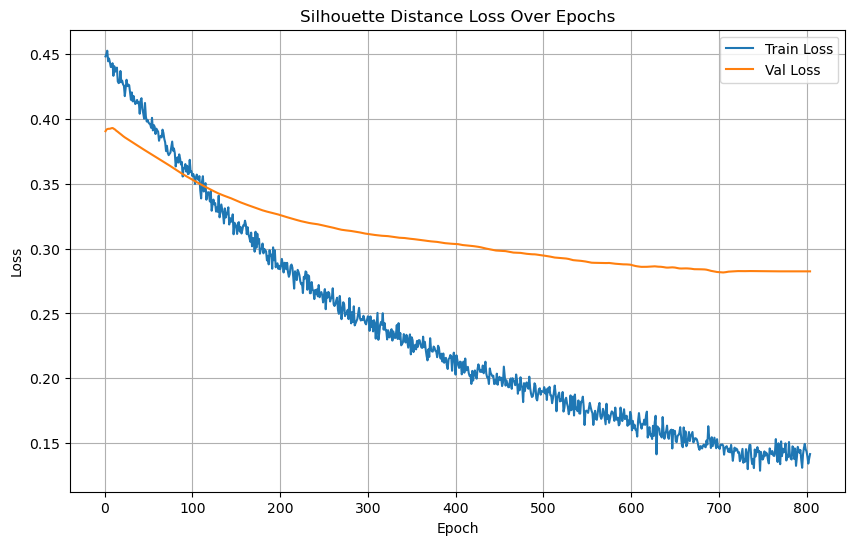

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/2313], Loss: 0.0896


Test Batch [20/2313], Loss: 0.1752
Test Batch [30/2313], Loss: 0.5000
Test Batch [40/2313], Loss: 0.0851
Test Batch [50/2313], Loss: 0.5000
Test Batch [60/2313], Loss: 0.5000


Test Batch [70/2313], Loss: 0.5000
Test Batch [80/2313], Loss: 0.1586


Test Batch [90/2313], Loss: 0.5000
Test Batch [100/2313], Loss: 0.0694
Test Batch [110/2313], Loss: 0.5000
Test Batch [120/2313], Loss: 0.1236
Test Batch [130/2313], Loss: 0.5000


Test Batch [140/2313], Loss: 0.5000


Test Batch [150/2313], Loss: 0.5000
Test Batch [160/2313], Loss: 0.0852
Test Batch [170/2313], Loss: 0.5000
Test Batch [180/2313], Loss: 0.5000
Test Batch [190/2313], Loss: 0.5000
Test Batch [200/2313], Loss: 0.1450


Test Batch [210/2313], Loss: 0.5000


Test Batch [220/2313], Loss: 0.5000
Test Batch [230/2313], Loss: 0.1077
Test Batch [240/2313], Loss: 0.0262
Test Batch [250/2313], Loss: 0.1085
Test Batch [260/2313], Loss: 0.5000
Test Batch [270/2313], Loss: 0.5000


Test Batch [280/2313], Loss: 0.5000
Test Batch [290/2313], Loss: 0.0914
Test Batch [300/2313], Loss: 0.1439
Test Batch [310/2313], Loss: 0.5000
Test Batch [320/2313], Loss: 0.0842
Test Batch [330/2313], Loss: 0.5000


Test Batch [340/2313], Loss: 0.5000
Test Batch [350/2313], Loss: 0.1510
Test Batch [360/2313], Loss: 0.1441
Test Batch [370/2313], Loss: 0.1755
Test Batch [380/2313], Loss: 0.0874
Test Batch [390/2313], Loss: 0.5000
Test Batch [400/2313], Loss: 0.5000


Test Batch [410/2313], Loss: 0.0415
Test Batch [420/2313], Loss: 0.0547
Test Batch [430/2313], Loss: 0.1377
Test Batch [440/2313], Loss: 0.5000
Test Batch [450/2313], Loss: 0.0666
Test Batch [460/2313], Loss: 0.5000


Test Batch [470/2313], Loss: 0.1491
Test Batch [480/2313], Loss: 0.5000
Test Batch [490/2313], Loss: 0.0648
Test Batch [500/2313], Loss: 0.0717
Test Batch [510/2313], Loss: 0.1204
Test Batch [520/2313], Loss: 0.0776


Test Batch [530/2313], Loss: 0.5000
Test Batch [540/2313], Loss: 0.0382
Test Batch [550/2313], Loss: 0.0670
Test Batch [560/2313], Loss: 0.5000
Test Batch [570/2313], Loss: 0.5000
Test Batch [580/2313], Loss: 0.0652


Test Batch [590/2313], Loss: 0.0523
Test Batch [600/2313], Loss: 0.5000
Test Batch [610/2313], Loss: 0.5000
Test Batch [620/2313], Loss: 0.1158
Test Batch [630/2313], Loss: 0.0191


Test Batch [640/2313], Loss: 0.0991
Test Batch [650/2313], Loss: 0.5000
Test Batch [660/2313], Loss: 0.0464
Test Batch [670/2313], Loss: 0.1095
Test Batch [680/2313], Loss: 0.5000
Test Batch [690/2313], Loss: 0.0637


Test Batch [700/2313], Loss: 0.2234
Test Batch [710/2313], Loss: 0.5000
Test Batch [720/2313], Loss: 0.5000
Test Batch [730/2313], Loss: 0.0160
Test Batch [740/2313], Loss: 0.5000
Test Batch [750/2313], Loss: 0.1147


Test Batch [760/2313], Loss: 0.0602
Test Batch [770/2313], Loss: 0.5000
Test Batch [780/2313], Loss: 0.5000
Test Batch [790/2313], Loss: 0.1012
Test Batch [800/2313], Loss: 0.0974


Test Batch [810/2313], Loss: 0.5000
Test Batch [820/2313], Loss: 0.1024
Test Batch [830/2313], Loss: 0.0399
Test Batch [840/2313], Loss: 0.0222
Test Batch [850/2313], Loss: 0.1968
Test Batch [860/2313], Loss: 0.5000


Test Batch [870/2313], Loss: 0.1373
Test Batch [880/2313], Loss: 0.0404
Test Batch [890/2313], Loss: 0.5000
Test Batch [900/2313], Loss: 0.5000
Test Batch [910/2313], Loss: 0.0213
Test Batch [920/2313], Loss: 0.5000
Test Batch [930/2313], Loss: 0.1297
Test Batch [940/2313], Loss: 0.1849
Test Batch [950/2313], Loss: 0.0121


Test Batch [960/2313], Loss: 0.5000
Test Batch [970/2313], Loss: 0.5000
Test Batch [980/2313], Loss: 0.0208
Test Batch [990/2313], Loss: 0.1356
Test Batch [1000/2313], Loss: 0.5000
Test Batch [1010/2313], Loss: 0.0776


Test Batch [1020/2313], Loss: 0.0835
Test Batch [1030/2313], Loss: 0.5000
Test Batch [1040/2313], Loss: 0.1088
Test Batch [1050/2313], Loss: 0.0690
Test Batch [1060/2313], Loss: 0.0130


Test Batch [1070/2313], Loss: 0.0258
Test Batch [1080/2313], Loss: 0.5000
Test Batch [1090/2313], Loss: 0.0543
Test Batch [1100/2313], Loss: 0.1202
Test Batch [1110/2313], Loss: 0.1820


Test Batch [1120/2313], Loss: 0.0433
Test Batch [1130/2313], Loss: 0.1069
Test Batch [1140/2313], Loss: 0.0740
Test Batch [1150/2313], Loss: 0.5000
Test Batch [1160/2313], Loss: 0.0724


Test Batch [1170/2313], Loss: 0.0437
Test Batch [1180/2313], Loss: 0.1478
Test Batch [1190/2313], Loss: 0.2168
Test Batch [1200/2313], Loss: 0.0656


Test Batch [1210/2313], Loss: 0.0856
Test Batch [1220/2313], Loss: 0.1072
Test Batch [1230/2313], Loss: 0.0850
Test Batch [1240/2313], Loss: 0.5000


Test Batch [1250/2313], Loss: 0.5000
Test Batch [1260/2313], Loss: 0.0601
Test Batch [1270/2313], Loss: 0.0903
Test Batch [1280/2313], Loss: 0.1092


Test Batch [1290/2313], Loss: 0.0752
Test Batch [1300/2313], Loss: 0.1974
Test Batch [1310/2313], Loss: 0.1702


Test Batch [1320/2313], Loss: 0.2269
Test Batch [1330/2313], Loss: 0.1258
Test Batch [1340/2313], Loss: 0.0390
Test Batch [1350/2313], Loss: 0.2204


Test Batch [1360/2313], Loss: 0.2392
Test Batch [1370/2313], Loss: 0.5000
Test Batch [1380/2313], Loss: 0.1595
Test Batch [1390/2313], Loss: 0.1887


Test Batch [1400/2313], Loss: 0.1511
Test Batch [1410/2313], Loss: 0.1665
Test Batch [1420/2313], Loss: 0.2122


Test Batch [1430/2313], Loss: 0.5000
Test Batch [1440/2313], Loss: 0.1209
Test Batch [1450/2313], Loss: 0.1338


Test Batch [1460/2313], Loss: 0.0838
Test Batch [1470/2313], Loss: 0.0868
Test Batch [1480/2313], Loss: 0.0962
Test Batch [1490/2313], Loss: 0.1881
Test Batch [1500/2313], Loss: 0.1401


Test Batch [1510/2313], Loss: 0.1025
Test Batch [1520/2313], Loss: 0.5000
Test Batch [1530/2313], Loss: 0.0869
Test Batch [1540/2313], Loss: 0.1449


Test Batch [1550/2313], Loss: 0.1934
Test Batch [1560/2313], Loss: 0.1028
Test Batch [1570/2313], Loss: 0.1050
Test Batch [1580/2313], Loss: 0.1250


Test Batch [1590/2313], Loss: 0.1678
Test Batch [1600/2313], Loss: 0.2390
Test Batch [1610/2313], Loss: 0.2247
Test Batch [1620/2313], Loss: 0.1184


Test Batch [1630/2313], Loss: 0.1136
Test Batch [1640/2313], Loss: 0.2069
Test Batch [1650/2313], Loss: 0.0451
Test Batch [1660/2313], Loss: 0.2415


Test Batch [1670/2313], Loss: 0.1613
Test Batch [1680/2313], Loss: 0.2269
Test Batch [1690/2313], Loss: 0.2391
Test Batch [1700/2313], Loss: 0.1130


Test Batch [1710/2313], Loss: 0.0881
Test Batch [1720/2313], Loss: 0.1141
Test Batch [1730/2313], Loss: 0.0672
Test Batch [1740/2313], Loss: 0.5000
Test Batch [1750/2313], Loss: 0.0821
Test Batch [1760/2313], Loss: 0.0725
Test Batch [1770/2313], Loss: 0.1021


Test Batch [1780/2313], Loss: 0.1000
Test Batch [1790/2313], Loss: 0.1179
Test Batch [1800/2313], Loss: 0.1200
Test Batch [1810/2313], Loss: 0.1250
Test Batch [1820/2313], Loss: 0.1859
Test Batch [1830/2313], Loss: 0.0364


Test Batch [1840/2313], Loss: 0.2226
Test Batch [1850/2313], Loss: 0.1170
Test Batch [1860/2313], Loss: 0.1353
Test Batch [1870/2313], Loss: 0.1483
Test Batch [1880/2313], Loss: 0.1451


Test Batch [1890/2313], Loss: 0.1568
Test Batch [1900/2313], Loss: 0.1353
Test Batch [1910/2313], Loss: 0.1833
Test Batch [1920/2313], Loss: 0.1952


Test Batch [1930/2313], Loss: 0.1238
Test Batch [1940/2313], Loss: 0.1558
Test Batch [1950/2313], Loss: 0.1666
Test Batch [1960/2313], Loss: 0.1107
Test Batch [1970/2313], Loss: 0.1301
Test Batch [1980/2313], Loss: 0.1165


Test Batch [1990/2313], Loss: 0.0903
Test Batch [2000/2313], Loss: 0.1389
Test Batch [2010/2313], Loss: 0.0821
Test Batch [2020/2313], Loss: 0.1306
Test Batch [2030/2313], Loss: 0.0867


Test Batch [2040/2313], Loss: 0.1010
Test Batch [2050/2313], Loss: 0.2327
Test Batch [2060/2313], Loss: 0.1317
Test Batch [2070/2313], Loss: 0.1042
Test Batch [2080/2313], Loss: 0.5000
Test Batch [2090/2313], Loss: 0.5000


Test Batch [2100/2313], Loss: 0.5000
Test Batch [2110/2313], Loss: 0.1626
Test Batch [2120/2313], Loss: 0.1595
Test Batch [2130/2313], Loss: 0.5000
Test Batch [2140/2313], Loss: 0.0886
Test Batch [2150/2313], Loss: 0.5000


Test Batch [2160/2313], Loss: 0.5000
Test Batch [2170/2313], Loss: 0.5000
Test Batch [2180/2313], Loss: 0.5000
Test Batch [2190/2313], Loss: 0.5000
Test Batch [2200/2313], Loss: 0.0527


Test Batch [2210/2313], Loss: 0.1715
Test Batch [2220/2313], Loss: 0.5000
Test Batch [2230/2313], Loss: 0.0386
Test Batch [2240/2313], Loss: 0.5000
Test Batch [2250/2313], Loss: 0.5000
Test Batch [2260/2313], Loss: 0.5000


Test Batch [2270/2313], Loss: 0.1358
Test Batch [2280/2313], Loss: 0.5000
Test Batch [2290/2313], Loss: 0.0670
Test Batch [2300/2313], Loss: 0.5000
Test Batch [2310/2313], Loss: 0.5000

Test Loss: 0.2291


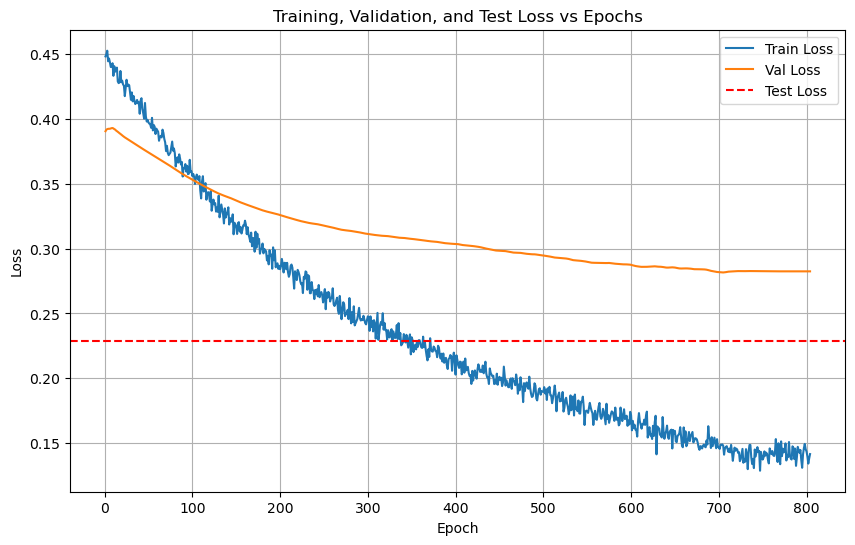

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/2313 for test dataset.
  Processed batch 20/2313 for test dataset.


  Processed batch 30/2313 for test dataset.
  Processed batch 40/2313 for test dataset.
  Processed batch 50/2313 for test dataset.
  Processed batch 60/2313 for test dataset.


  Processed batch 70/2313 for test dataset.
  Processed batch 80/2313 for test dataset.
  Processed batch 90/2313 for test dataset.
  Processed batch 100/2313 for test dataset.


  Processed batch 110/2313 for test dataset.
  Processed batch 120/2313 for test dataset.
  Processed batch 130/2313 for test dataset.
  Processed batch 140/2313 for test dataset.


  Processed batch 150/2313 for test dataset.
  Processed batch 160/2313 for test dataset.
  Processed batch 170/2313 for test dataset.
  Processed batch 180/2313 for test dataset.


  Processed batch 190/2313 for test dataset.
  Processed batch 200/2313 for test dataset.
  Processed batch 210/2313 for test dataset.


  Processed batch 220/2313 for test dataset.
  Processed batch 230/2313 for test dataset.
  Processed batch 240/2313 for test dataset.
  Processed batch 250/2313 for test dataset.


  Processed batch 260/2313 for test dataset.
  Processed batch 270/2313 for test dataset.
  Processed batch 280/2313 for test dataset.
  Processed batch 290/2313 for test dataset.


  Processed batch 300/2313 for test dataset.
  Processed batch 310/2313 for test dataset.
  Processed batch 320/2313 for test dataset.
  Processed batch 330/2313 for test dataset.


  Processed batch 340/2313 for test dataset.
  Processed batch 350/2313 for test dataset.
  Processed batch 360/2313 for test dataset.
  Processed batch 370/2313 for test dataset.


  Processed batch 380/2313 for test dataset.
  Processed batch 390/2313 for test dataset.
  Processed batch 400/2313 for test dataset.
  Processed batch 410/2313 for test dataset.


  Processed batch 420/2313 for test dataset.
  Processed batch 430/2313 for test dataset.
  Processed batch 440/2313 for test dataset.
  Processed batch 450/2313 for test dataset.


  Processed batch 460/2313 for test dataset.
  Processed batch 470/2313 for test dataset.
  Processed batch 480/2313 for test dataset.
  Processed batch 490/2313 for test dataset.


  Processed batch 500/2313 for test dataset.
  Processed batch 510/2313 for test dataset.
  Processed batch 520/2313 for test dataset.
  Processed batch 530/2313 for test dataset.


  Processed batch 540/2313 for test dataset.
  Processed batch 550/2313 for test dataset.
  Processed batch 560/2313 for test dataset.


  Processed batch 570/2313 for test dataset.
  Processed batch 580/2313 for test dataset.
  Processed batch 590/2313 for test dataset.
  Processed batch 600/2313 for test dataset.


  Processed batch 610/2313 for test dataset.
  Processed batch 620/2313 for test dataset.
  Processed batch 630/2313 for test dataset.
  Processed batch 640/2313 for test dataset.


  Processed batch 650/2313 for test dataset.
  Processed batch 660/2313 for test dataset.
  Processed batch 670/2313 for test dataset.
  Processed batch 680/2313 for test dataset.


  Processed batch 690/2313 for test dataset.
  Processed batch 700/2313 for test dataset.
  Processed batch 710/2313 for test dataset.
  Processed batch 720/2313 for test dataset.


  Processed batch 730/2313 for test dataset.
  Processed batch 740/2313 for test dataset.
  Processed batch 750/2313 for test dataset.


  Processed batch 760/2313 for test dataset.
  Processed batch 770/2313 for test dataset.
  Processed batch 780/2313 for test dataset.
  Processed batch 790/2313 for test dataset.


  Processed batch 800/2313 for test dataset.
  Processed batch 810/2313 for test dataset.
  Processed batch 820/2313 for test dataset.
  Processed batch 830/2313 for test dataset.


  Processed batch 840/2313 for test dataset.
  Processed batch 850/2313 for test dataset.
  Processed batch 860/2313 for test dataset.
  Processed batch 870/2313 for test dataset.


  Processed batch 880/2313 for test dataset.
  Processed batch 890/2313 for test dataset.
  Processed batch 900/2313 for test dataset.
  Processed batch 910/2313 for test dataset.


  Processed batch 920/2313 for test dataset.
  Processed batch 930/2313 for test dataset.
  Processed batch 940/2313 for test dataset.
  Processed batch 950/2313 for test dataset.


  Processed batch 960/2313 for test dataset.
  Processed batch 970/2313 for test dataset.
  Processed batch 980/2313 for test dataset.
  Processed batch 990/2313 for test dataset.


  Processed batch 1000/2313 for test dataset.
  Processed batch 1010/2313 for test dataset.
  Processed batch 1020/2313 for test dataset.
  Processed batch 1030/2313 for test dataset.


  Processed batch 1040/2313 for test dataset.
  Processed batch 1050/2313 for test dataset.
  Processed batch 1060/2313 for test dataset.


  Processed batch 1070/2313 for test dataset.
  Processed batch 1080/2313 for test dataset.
  Processed batch 1090/2313 for test dataset.
  Processed batch 1100/2313 for test dataset.


  Processed batch 1110/2313 for test dataset.
  Processed batch 1120/2313 for test dataset.
  Processed batch 1130/2313 for test dataset.
  Processed batch 1140/2313 for test dataset.


  Processed batch 1150/2313 for test dataset.
  Processed batch 1160/2313 for test dataset.
  Processed batch 1170/2313 for test dataset.
  Processed batch 1180/2313 for test dataset.


  Processed batch 1190/2313 for test dataset.
  Processed batch 1200/2313 for test dataset.
  Processed batch 1210/2313 for test dataset.
  Processed batch 1220/2313 for test dataset.


  Processed batch 1230/2313 for test dataset.
  Processed batch 1240/2313 for test dataset.
  Processed batch 1250/2313 for test dataset.
  Processed batch 1260/2313 for test dataset.


  Processed batch 1270/2313 for test dataset.
  Processed batch 1280/2313 for test dataset.
  Processed batch 1290/2313 for test dataset.
  Processed batch 1300/2313 for test dataset.


  Processed batch 1310/2313 for test dataset.
  Processed batch 1320/2313 for test dataset.
  Processed batch 1330/2313 for test dataset.
  Processed batch 1340/2313 for test dataset.


  Processed batch 1350/2313 for test dataset.
  Processed batch 1360/2313 for test dataset.
  Processed batch 1370/2313 for test dataset.
  Processed batch 1380/2313 for test dataset.


  Processed batch 1390/2313 for test dataset.
  Processed batch 1400/2313 for test dataset.
  Processed batch 1410/2313 for test dataset.
  Processed batch 1420/2313 for test dataset.


  Processed batch 1430/2313 for test dataset.
  Processed batch 1440/2313 for test dataset.
  Processed batch 1450/2313 for test dataset.
  Processed batch 1460/2313 for test dataset.


  Processed batch 1470/2313 for test dataset.
  Processed batch 1480/2313 for test dataset.
  Processed batch 1490/2313 for test dataset.
  Processed batch 1500/2313 for test dataset.


  Processed batch 1510/2313 for test dataset.
  Processed batch 1520/2313 for test dataset.
  Processed batch 1530/2313 for test dataset.


  Processed batch 1540/2313 for test dataset.
  Processed batch 1550/2313 for test dataset.
  Processed batch 1560/2313 for test dataset.
  Processed batch 1570/2313 for test dataset.


  Processed batch 1580/2313 for test dataset.
  Processed batch 1590/2313 for test dataset.
  Processed batch 1600/2313 for test dataset.
  Processed batch 1610/2313 for test dataset.


  Processed batch 1620/2313 for test dataset.
  Processed batch 1630/2313 for test dataset.
  Processed batch 1640/2313 for test dataset.
  Processed batch 1650/2313 for test dataset.


  Processed batch 1660/2313 for test dataset.
  Processed batch 1670/2313 for test dataset.
  Processed batch 1680/2313 for test dataset.
  Processed batch 1690/2313 for test dataset.


  Processed batch 1700/2313 for test dataset.
  Processed batch 1710/2313 for test dataset.
  Processed batch 1720/2313 for test dataset.
  Processed batch 1730/2313 for test dataset.


  Processed batch 1740/2313 for test dataset.
  Processed batch 1750/2313 for test dataset.
  Processed batch 1760/2313 for test dataset.


  Processed batch 1770/2313 for test dataset.
  Processed batch 1780/2313 for test dataset.
  Processed batch 1790/2313 for test dataset.
  Processed batch 1800/2313 for test dataset.


  Processed batch 1810/2313 for test dataset.
  Processed batch 1820/2313 for test dataset.
  Processed batch 1830/2313 for test dataset.
  Processed batch 1840/2313 for test dataset.


  Processed batch 1850/2313 for test dataset.
  Processed batch 1860/2313 for test dataset.
  Processed batch 1870/2313 for test dataset.
  Processed batch 1880/2313 for test dataset.


  Processed batch 1890/2313 for test dataset.
  Processed batch 1900/2313 for test dataset.
  Processed batch 1910/2313 for test dataset.
  Processed batch 1920/2313 for test dataset.


  Processed batch 1930/2313 for test dataset.
  Processed batch 1940/2313 for test dataset.
  Processed batch 1950/2313 for test dataset.
  Processed batch 1960/2313 for test dataset.


  Processed batch 1970/2313 for test dataset.
  Processed batch 1980/2313 for test dataset.
  Processed batch 1990/2313 for test dataset.
  Processed batch 2000/2313 for test dataset.


  Processed batch 2010/2313 for test dataset.
  Processed batch 2020/2313 for test dataset.
  Processed batch 2030/2313 for test dataset.
  Processed batch 2040/2313 for test dataset.


  Processed batch 2050/2313 for test dataset.
  Processed batch 2060/2313 for test dataset.
  Processed batch 2070/2313 for test dataset.
  Processed batch 2080/2313 for test dataset.


  Processed batch 2090/2313 for test dataset.
  Processed batch 2100/2313 for test dataset.
  Processed batch 2110/2313 for test dataset.
  Processed batch 2120/2313 for test dataset.


  Processed batch 2130/2313 for test dataset.
  Processed batch 2140/2313 for test dataset.
  Processed batch 2150/2313 for test dataset.
  Processed batch 2160/2313 for test dataset.


  Processed batch 2170/2313 for test dataset.
  Processed batch 2180/2313 for test dataset.
  Processed batch 2190/2313 for test dataset.
  Processed batch 2200/2313 for test dataset.


  Processed batch 2210/2313 for test dataset.
  Processed batch 2220/2313 for test dataset.
  Processed batch 2230/2313 for test dataset.
  Processed batch 2240/2313 for test dataset.


  Processed batch 2250/2313 for test dataset.
  Processed batch 2260/2313 for test dataset.
  Processed batch 2270/2313 for test dataset.
  Processed batch 2280/2313 for test dataset.


  Processed batch 2290/2313 for test dataset.
  Processed batch 2300/2313 for test dataset.
  Processed batch 2310/2313 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148017, 128)
Test labels shape: (148017,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 84.44%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.80      0.89         5
           2       0.80      0.80      0.80         5
           3       0.60      0.60      0.60         5
           4       0.57      0.80      0.67         5
           5       0.83      1.00      0.91         5
           6       1.00      0.60      0.75         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           0.84        45
   macro avg       0.87      0.84      0.85        45
weighted avg       0.87      0.84      0.85        45


LOG: Evaluating on the test set...
Test Accuracy: 94.30%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     65956
           1       0.92      0.74      0.82      7583
           2       0.53      0.73      0.61      3075
           3       0.66      0.66      0.66      2670
           4       0.81      0.92      0.86      6569
           5       0.83      0.89      0.86      9233
           6       0.80      0.90      0.85      7272
           7       0.99      0.96      0.98     42811
           8       1.00      0.99      0.99      2848

    accuracy                           0.94    148017
   macro avg       0.84      0.86      0.85    148017
weighted avg       0.95      0.94      0.94    148017

Saved SCL_SDL+LRM predictions and true labels to model_predictions


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148017, 128)
Test labels shape: (148017,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.4645  |  Val Loss: 2.4172
Validation loss improved from inf to 2.4172.
[Epoch 2/1000] Train Loss: 2.4229  |  Val Loss: 2.3855
Validation loss improved from 2.4172 to 2.3855.
[Epoch 3/1000] Train Loss: 2.3824  |  Val Loss: 2.3548
Validation loss improved from 2.3855 to 2.3548.
[Epoch 4/1000] Train Loss: 2.3437  |  Val Loss: 2.3241
Validation loss improved from 2.3548 to 2.3241.
[Epoch 5/1000] Train Loss: 2.3073  |  Val Loss: 2.2939
Validation loss improved from 2.3241 to 2.2939.
[Epoch 6/1000] Train Loss: 2.2703  |  Val Loss: 2.2658
Validation loss improved from 2.2939 to 2.2658.
[Epoch 7/1000] Train Loss: 2.2365  |  Val Loss: 2.2395
Validation loss improved from 2.2658 to 2.2395.
[Epoch 8/1000] Train Loss: 2.2046  |  Val Loss: 2.2135
Validation loss improved from 2.2395 to 2.2135.
[Epoch 9/1000] Train Loss: 2.1710  |  Val Loss: 2.1882
Validation loss improved from 2.2135 to 2.1882.
[Epoch 10/1000] Train Loss: 2.1407  |  Val Loss: 2.1636
Validation loss impr

[Epoch 35/1000] Train Loss: 1.5156  |  Val Loss: 1.6571
Validation loss improved from 1.6733 to 1.6571.
[Epoch 36/1000] Train Loss: 1.4959  |  Val Loss: 1.6413
Validation loss improved from 1.6571 to 1.6413.
[Epoch 37/1000] Train Loss: 1.4765  |  Val Loss: 1.6258
Validation loss improved from 1.6413 to 1.6258.
[Epoch 38/1000] Train Loss: 1.4575  |  Val Loss: 1.6108
Validation loss improved from 1.6258 to 1.6108.
[Epoch 39/1000] Train Loss: 1.4386  |  Val Loss: 1.5960
Validation loss improved from 1.6108 to 1.5960.
[Epoch 40/1000] Train Loss: 1.4203  |  Val Loss: 1.5816
Validation loss improved from 1.5960 to 1.5816.
[Epoch 41/1000] Train Loss: 1.4021  |  Val Loss: 1.5673
Validation loss improved from 1.5816 to 1.5673.
[Epoch 42/1000] Train Loss: 1.3847  |  Val Loss: 1.5533
Validation loss improved from 1.5673 to 1.5533.
[Epoch 43/1000] Train Loss: 1.3666  |  Val Loss: 1.5398
Validation loss improved from 1.5533 to 1.5398.


[Epoch 44/1000] Train Loss: 1.3494  |  Val Loss: 1.5264
Validation loss improved from 1.5398 to 1.5264.
[Epoch 45/1000] Train Loss: 1.3320  |  Val Loss: 1.5132
Validation loss improved from 1.5264 to 1.5132.
[Epoch 46/1000] Train Loss: 1.3147  |  Val Loss: 1.5001
Validation loss improved from 1.5132 to 1.5001.
[Epoch 47/1000] Train Loss: 1.2978  |  Val Loss: 1.4870
Validation loss improved from 1.5001 to 1.4870.
[Epoch 48/1000] Train Loss: 1.2806  |  Val Loss: 1.4741
Validation loss improved from 1.4870 to 1.4741.
[Epoch 49/1000] Train Loss: 1.2642  |  Val Loss: 1.4615
Validation loss improved from 1.4741 to 1.4615.
[Epoch 50/1000] Train Loss: 1.2473  |  Val Loss: 1.4489
Validation loss improved from 1.4615 to 1.4489.
[Epoch 51/1000] Train Loss: 1.2311  |  Val Loss: 1.4366
Validation loss improved from 1.4489 to 1.4366.
[Epoch 52/1000] Train Loss: 1.2147  |  Val Loss: 1.4244
Validation loss improved from 1.4366 to 1.4244.
[Epoch 53/1000] Train Loss: 1.1986  |  Val Loss: 1.4124
Validati

[Epoch 77/1000] Train Loss: 0.8619  |  Val Loss: 1.1720
Validation loss improved from 1.1807 to 1.1720.
[Epoch 78/1000] Train Loss: 0.8499  |  Val Loss: 1.1634
Validation loss improved from 1.1720 to 1.1634.
[Epoch 79/1000] Train Loss: 0.8378  |  Val Loss: 1.1547
Validation loss improved from 1.1634 to 1.1547.
[Epoch 80/1000] Train Loss: 0.8258  |  Val Loss: 1.1461
Validation loss improved from 1.1547 to 1.1461.
[Epoch 81/1000] Train Loss: 0.8136  |  Val Loss: 1.1375
Validation loss improved from 1.1461 to 1.1375.
[Epoch 82/1000] Train Loss: 0.8022  |  Val Loss: 1.1290
Validation loss improved from 1.1375 to 1.1290.
[Epoch 83/1000] Train Loss: 0.7901  |  Val Loss: 1.1205
Validation loss improved from 1.1290 to 1.1205.
[Epoch 84/1000] Train Loss: 0.7785  |  Val Loss: 1.1120
Validation loss improved from 1.1205 to 1.1120.
[Epoch 85/1000] Train Loss: 0.7674  |  Val Loss: 1.1036
Validation loss improved from 1.1120 to 1.1036.
[Epoch 86/1000] Train Loss: 0.7557  |  Val Loss: 1.0952
Validati

[Epoch 89/1000] Train Loss: 0.7229  |  Val Loss: 1.0704
Validation loss improved from 1.0785 to 1.0704.
[Epoch 90/1000] Train Loss: 0.7123  |  Val Loss: 1.0623
Validation loss improved from 1.0704 to 1.0623.
[Epoch 91/1000] Train Loss: 0.7020  |  Val Loss: 1.0544
Validation loss improved from 1.0623 to 1.0544.
[Epoch 92/1000] Train Loss: 0.6913  |  Val Loss: 1.0466
Validation loss improved from 1.0544 to 1.0466.
[Epoch 93/1000] Train Loss: 0.6815  |  Val Loss: 1.0388
Validation loss improved from 1.0466 to 1.0388.
[Epoch 94/1000] Train Loss: 0.6713  |  Val Loss: 1.0312
Validation loss improved from 1.0388 to 1.0312.
[Epoch 95/1000] Train Loss: 0.6614  |  Val Loss: 1.0237
Validation loss improved from 1.0312 to 1.0237.
[Epoch 96/1000] Train Loss: 0.6515  |  Val Loss: 1.0162
Validation loss improved from 1.0237 to 1.0162.
[Epoch 97/1000] Train Loss: 0.6421  |  Val Loss: 1.0088
Validation loss improved from 1.0162 to 1.0088.
[Epoch 98/1000] Train Loss: 0.6322  |  Val Loss: 1.0016
Validati

[Epoch 124/1000] Train Loss: 0.4161  |  Val Loss: 0.8459
Validation loss improved from 0.8507 to 0.8459.
[Epoch 125/1000] Train Loss: 0.4094  |  Val Loss: 0.8412
Validation loss improved from 0.8459 to 0.8412.
[Epoch 126/1000] Train Loss: 0.4027  |  Val Loss: 0.8367
Validation loss improved from 0.8412 to 0.8367.
[Epoch 127/1000] Train Loss: 0.3966  |  Val Loss: 0.8322
Validation loss improved from 0.8367 to 0.8322.
[Epoch 128/1000] Train Loss: 0.3901  |  Val Loss: 0.8277
Validation loss improved from 0.8322 to 0.8277.
[Epoch 129/1000] Train Loss: 0.3840  |  Val Loss: 0.8232
Validation loss improved from 0.8277 to 0.8232.
[Epoch 130/1000] Train Loss: 0.3779  |  Val Loss: 0.8189
Validation loss improved from 0.8232 to 0.8189.
[Epoch 131/1000] Train Loss: 0.3718  |  Val Loss: 0.8147
Validation loss improved from 0.8189 to 0.8147.
[Epoch 132/1000] Train Loss: 0.3661  |  Val Loss: 0.8107
Validation loss improved from 0.8147 to 0.8107.
[Epoch 133/1000] Train Loss: 0.3603  |  Val Loss: 0.806

[Epoch 134/1000] Train Loss: 0.3544  |  Val Loss: 0.8028
Validation loss improved from 0.8067 to 0.8028.
[Epoch 135/1000] Train Loss: 0.3491  |  Val Loss: 0.7988
Validation loss improved from 0.8028 to 0.7988.
[Epoch 136/1000] Train Loss: 0.3436  |  Val Loss: 0.7951
Validation loss improved from 0.7988 to 0.7951.
[Epoch 137/1000] Train Loss: 0.3382  |  Val Loss: 0.7914
Validation loss improved from 0.7951 to 0.7914.
[Epoch 138/1000] Train Loss: 0.3329  |  Val Loss: 0.7879
Validation loss improved from 0.7914 to 0.7879.
[Epoch 139/1000] Train Loss: 0.3277  |  Val Loss: 0.7844
Validation loss improved from 0.7879 to 0.7844.
[Epoch 140/1000] Train Loss: 0.3225  |  Val Loss: 0.7811
Validation loss improved from 0.7844 to 0.7811.
[Epoch 141/1000] Train Loss: 0.3175  |  Val Loss: 0.7777
Validation loss improved from 0.7811 to 0.7777.
[Epoch 142/1000] Train Loss: 0.3127  |  Val Loss: 0.7744
Validation loss improved from 0.7777 to 0.7744.
[Epoch 143/1000] Train Loss: 0.3078  |  Val Loss: 0.771

[Epoch 168/1000] Train Loss: 0.2120  |  Val Loss: 0.7042
Validation loss improved from 0.7063 to 0.7042.
[Epoch 169/1000] Train Loss: 0.2089  |  Val Loss: 0.7021
Validation loss improved from 0.7042 to 0.7021.
[Epoch 170/1000] Train Loss: 0.2058  |  Val Loss: 0.7001
Validation loss improved from 0.7021 to 0.7001.
[Epoch 171/1000] Train Loss: 0.2028  |  Val Loss: 0.6981
Validation loss improved from 0.7001 to 0.6981.
[Epoch 172/1000] Train Loss: 0.1999  |  Val Loss: 0.6960
Validation loss improved from 0.6981 to 0.6960.
[Epoch 173/1000] Train Loss: 0.1970  |  Val Loss: 0.6940
Validation loss improved from 0.6960 to 0.6940.
[Epoch 174/1000] Train Loss: 0.1941  |  Val Loss: 0.6921
Validation loss improved from 0.6940 to 0.6921.
[Epoch 175/1000] Train Loss: 0.1914  |  Val Loss: 0.6902
Validation loss improved from 0.6921 to 0.6902.


[Epoch 176/1000] Train Loss: 0.1886  |  Val Loss: 0.6884
Validation loss improved from 0.6902 to 0.6884.
[Epoch 177/1000] Train Loss: 0.1859  |  Val Loss: 0.6867
Validation loss improved from 0.6884 to 0.6867.
[Epoch 178/1000] Train Loss: 0.1833  |  Val Loss: 0.6851
Validation loss improved from 0.6867 to 0.6851.
[Epoch 179/1000] Train Loss: 0.1806  |  Val Loss: 0.6834
Validation loss improved from 0.6851 to 0.6834.
[Epoch 180/1000] Train Loss: 0.1779  |  Val Loss: 0.6817
Validation loss improved from 0.6834 to 0.6817.
[Epoch 181/1000] Train Loss: 0.1754  |  Val Loss: 0.6802
Validation loss improved from 0.6817 to 0.6802.
[Epoch 182/1000] Train Loss: 0.1729  |  Val Loss: 0.6786
Validation loss improved from 0.6802 to 0.6786.
[Epoch 183/1000] Train Loss: 0.1703  |  Val Loss: 0.6771
Validation loss improved from 0.6786 to 0.6771.
[Epoch 184/1000] Train Loss: 0.1680  |  Val Loss: 0.6756
Validation loss improved from 0.6771 to 0.6756.
[Epoch 185/1000] Train Loss: 0.1655  |  Val Loss: 0.674

[Epoch 211/1000] Train Loss: 0.1151  |  Val Loss: 0.6416
Validation loss improved from 0.6425 to 0.6416.
[Epoch 212/1000] Train Loss: 0.1136  |  Val Loss: 0.6409
Validation loss improved from 0.6416 to 0.6409.
[Epoch 213/1000] Train Loss: 0.1121  |  Val Loss: 0.6402
Validation loss improved from 0.6409 to 0.6402.
[Epoch 214/1000] Train Loss: 0.1106  |  Val Loss: 0.6395
Validation loss improved from 0.6402 to 0.6395.
[Epoch 215/1000] Train Loss: 0.1092  |  Val Loss: 0.6388
Validation loss improved from 0.6395 to 0.6388.
[Epoch 216/1000] Train Loss: 0.1077  |  Val Loss: 0.6379
Validation loss improved from 0.6388 to 0.6379.
[Epoch 217/1000] Train Loss: 0.1064  |  Val Loss: 0.6370
Validation loss improved from 0.6379 to 0.6370.
[Epoch 218/1000] Train Loss: 0.1050  |  Val Loss: 0.6361
Validation loss improved from 0.6370 to 0.6361.
[Epoch 219/1000] Train Loss: 0.1036  |  Val Loss: 0.6354
Validation loss improved from 0.6361 to 0.6354.
[Epoch 220/1000] Train Loss: 0.1022  |  Val Loss: 0.634

[Epoch 258/1000] Train Loss: 0.0647  |  Val Loss: 0.6216
Validation loss improved from 0.6218 to 0.6216.
[Epoch 259/1000] Train Loss: 0.0640  |  Val Loss: 0.6214
Validation loss improved from 0.6216 to 0.6214.
[Epoch 260/1000] Train Loss: 0.0634  |  Val Loss: 0.6211
Validation loss improved from 0.6214 to 0.6211.
[Epoch 261/1000] Train Loss: 0.0626  |  Val Loss: 0.6209
Validation loss improved from 0.6211 to 0.6209.
[Epoch 262/1000] Train Loss: 0.0620  |  Val Loss: 0.6206
Validation loss improved from 0.6209 to 0.6206.
[Epoch 263/1000] Train Loss: 0.0613  |  Val Loss: 0.6203
Validation loss improved from 0.6206 to 0.6203.
[Epoch 264/1000] Train Loss: 0.0607  |  Val Loss: 0.6201
Validation loss improved from 0.6203 to 0.6201.
[Epoch 265/1000] Train Loss: 0.0600  |  Val Loss: 0.6199
Validation loss improved from 0.6201 to 0.6199.
[Epoch 266/1000] Train Loss: 0.0594  |  Val Loss: 0.6198
Validation loss improved from 0.6199 to 0.6198.
[Epoch 267/1000] Train Loss: 0.0588  |  Val Loss: 0.619

[Epoch 304/1000] Train Loss: 0.0415  |  Val Loss: 0.6217
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 305/1000] Train Loss: 0.0412  |  Val Loss: 0.6218
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 306/1000] Train Loss: 0.0409  |  Val Loss: 0.6219
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 307/1000] Train Loss: 0.0405  |  Val Loss: 0.6219
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 308/1000] Train Loss: 0.0401  |  Val Loss: 0.6219
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 309/1000] Train Loss: 0.0398  |  Val Loss: 0.6220
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 310/1000] Train Loss: 0.0395  |  Val Loss: 0.6221
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 311/1000] Train Loss: 0.0391  |  Val Loss: 0.6222
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 312/1000] Train Loss: 0.0388  |  Val Loss: 0.6224
!! Validation loss did NOT improve !! Patience:

[Epoch 351/1000] Train Loss: 0.0288  |  Val Loss: 0.6304
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 352/1000] Train Loss: 0.0286  |  Val Loss: 0.6307
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 353/1000] Train Loss: 0.0284  |  Val Loss: 0.6309
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 354/1000] Train Loss: 0.0282  |  Val Loss: 0.6310
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 355/1000] Train Loss: 0.0280  |  Val Loss: 0.6311
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 356/1000] Train Loss: 0.0278  |  Val Loss: 0.6312
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 357/1000] Train Loss: 0.0276  |  Val Loss: 0.6314
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 358/1000] Train Loss: 0.0274  |  Val Loss: 0.6316
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 359/1000] Train Loss: 0.0272  |  Val Loss: 0.6319
!! Validation loss did NOT improve !! Patience:

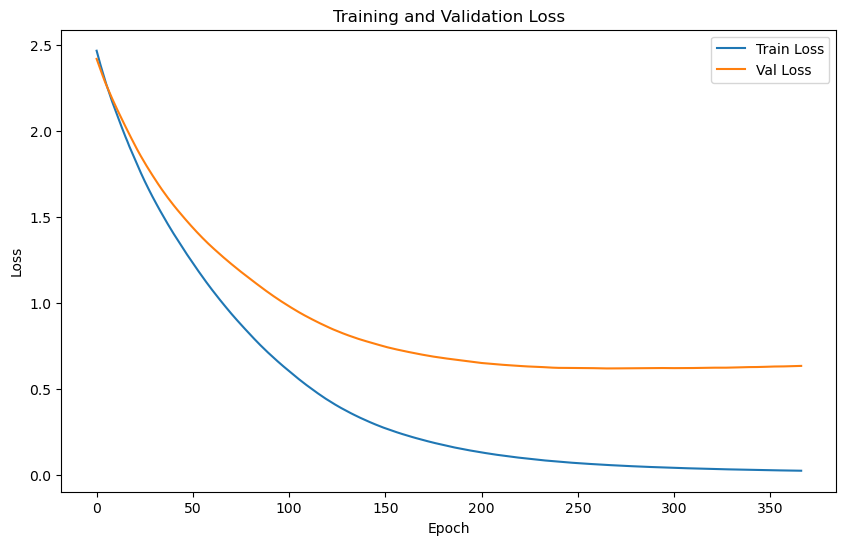

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.2297 | Test Accuracy: 95.24%


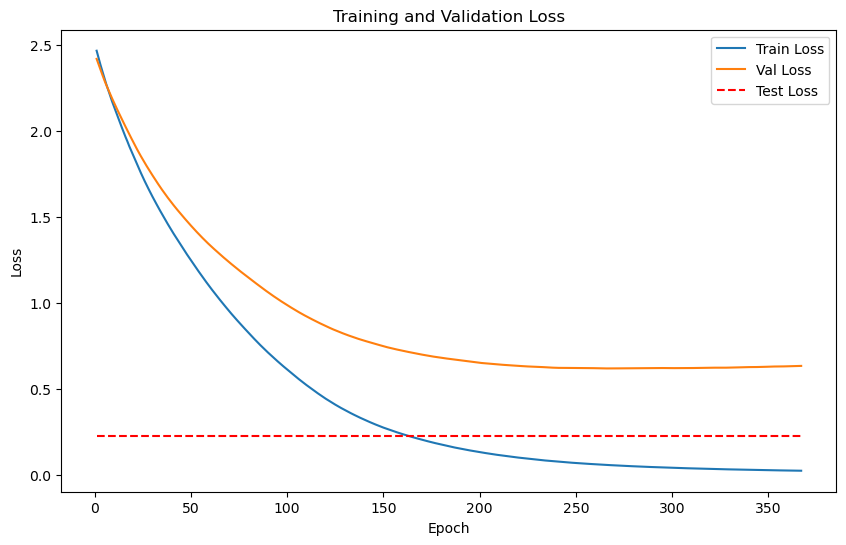

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


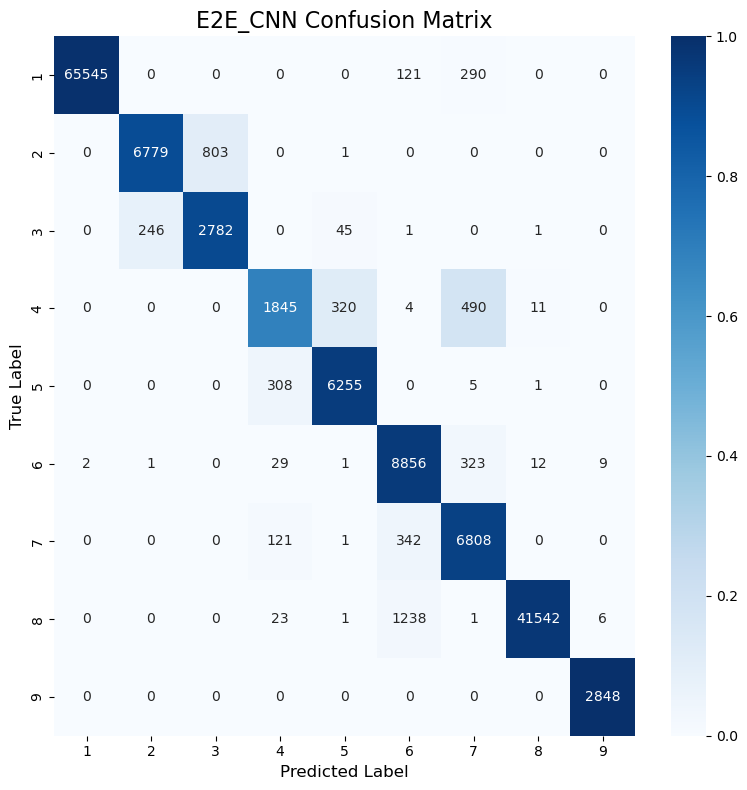

Classification Accuracy: 96.79%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


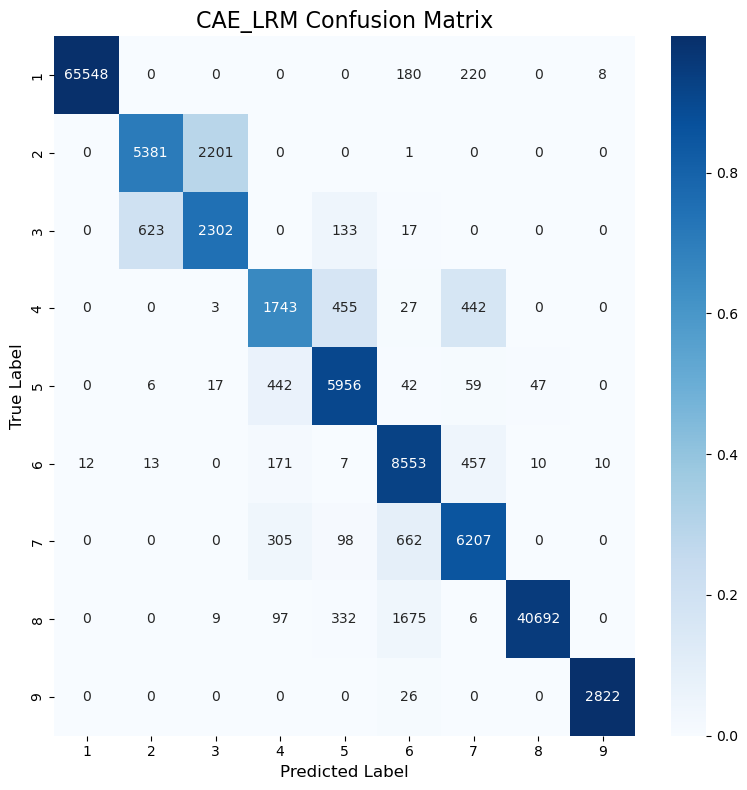

Classification Accuracy: 94.05%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


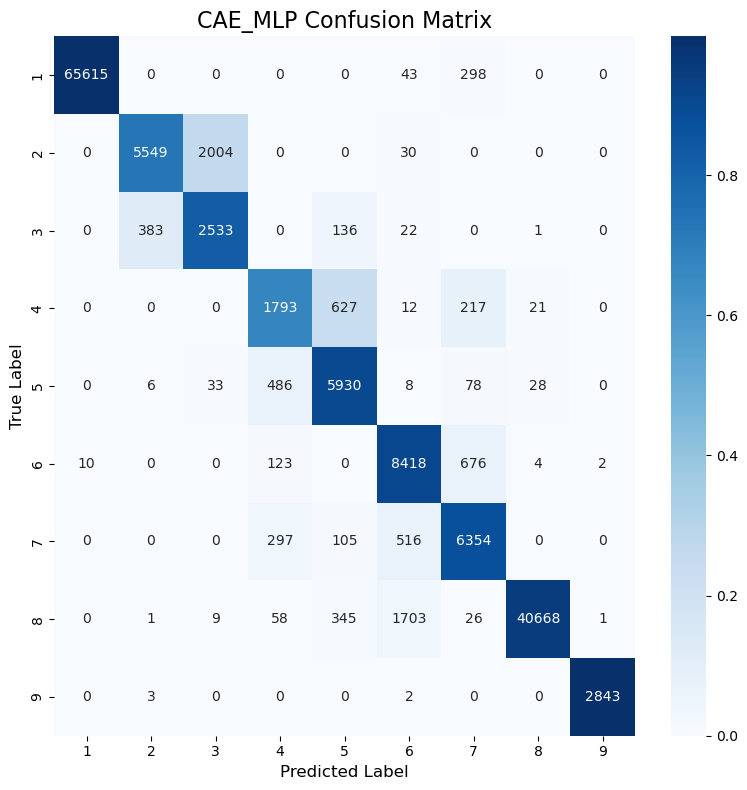

Classification Accuracy: 94.38%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


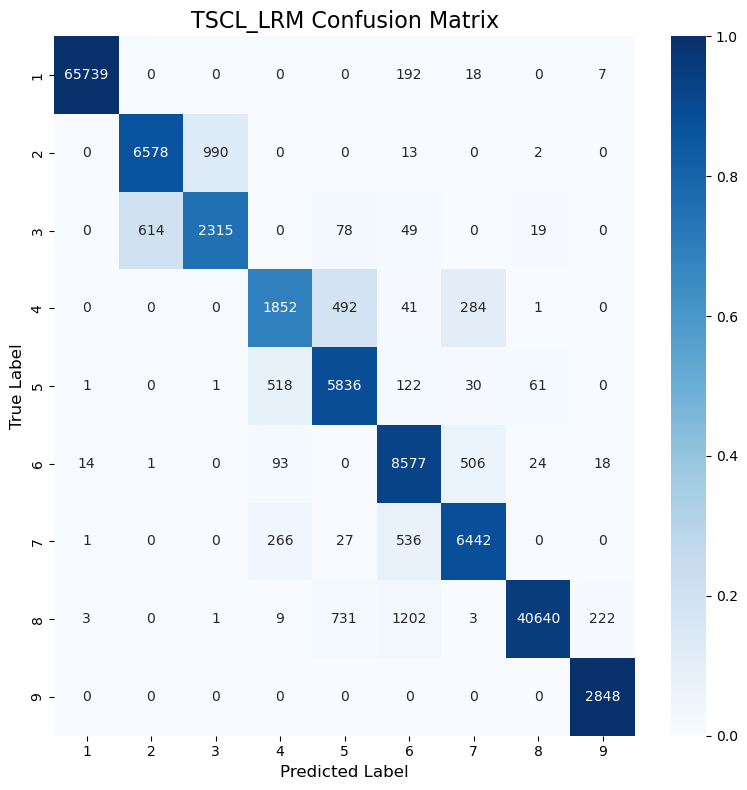

Classification Accuracy: 95.14%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


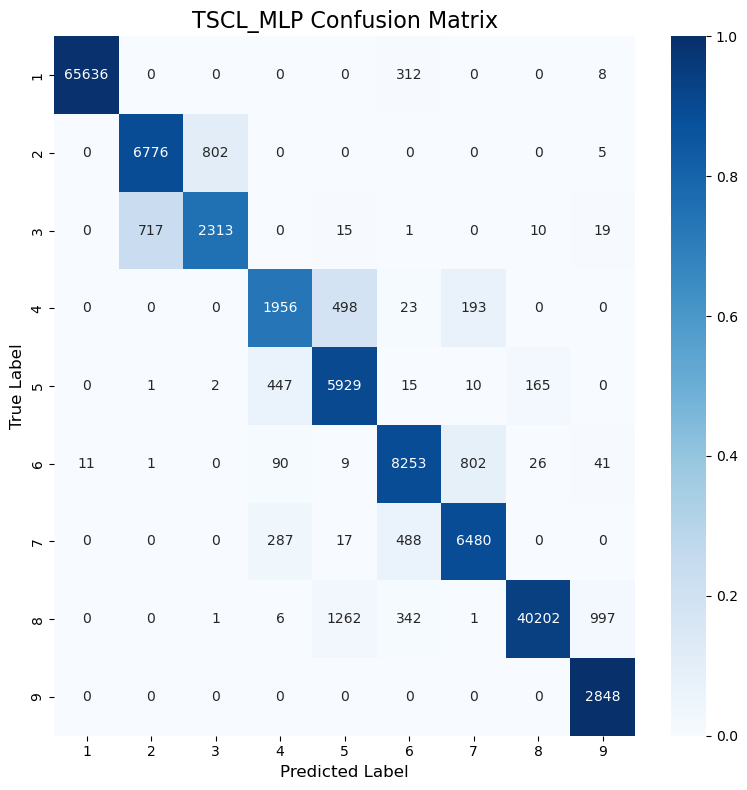

Classification Accuracy: 94.85%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


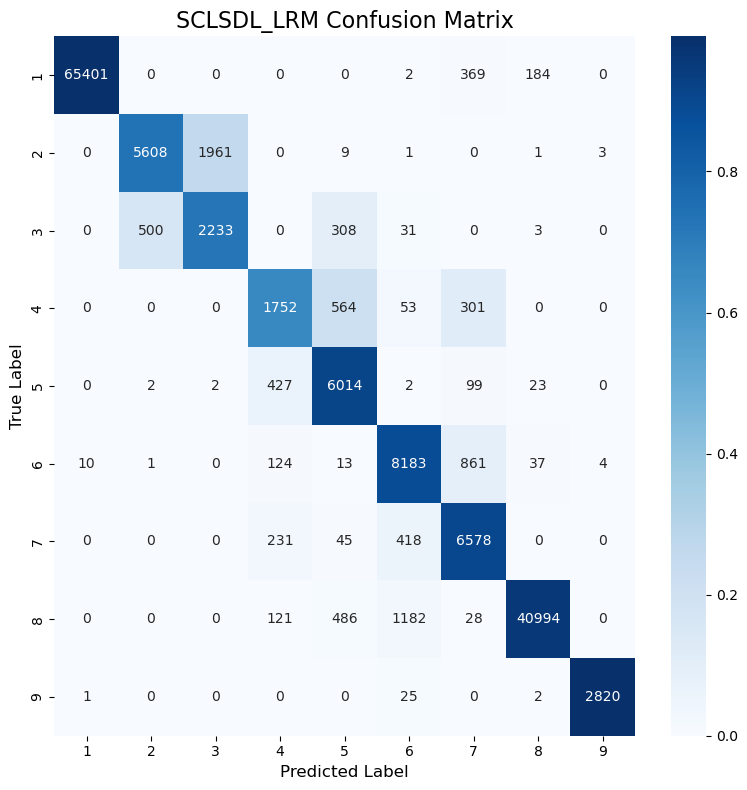

Classification Accuracy: 94.30%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


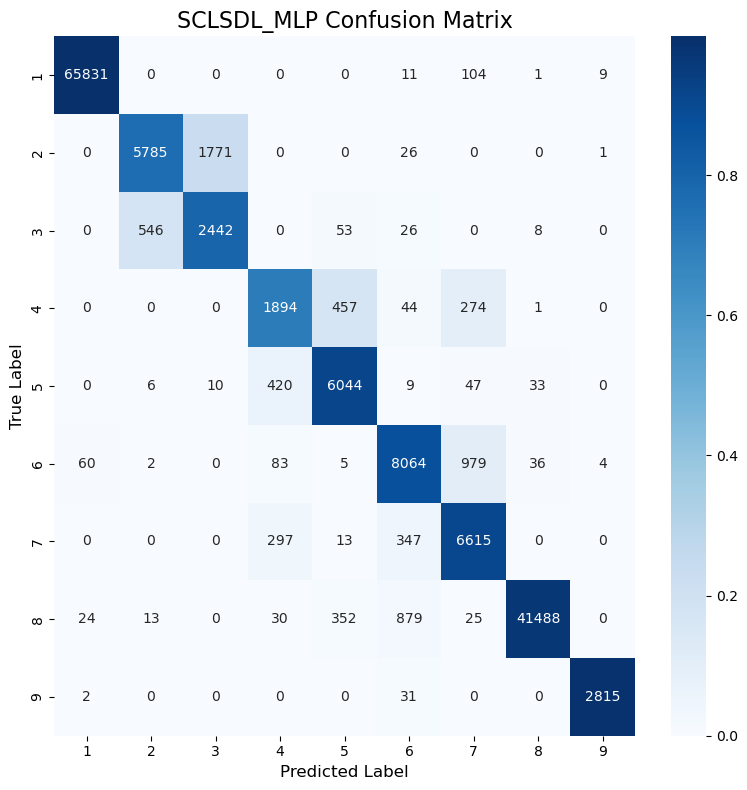

Classification Accuracy: 95.24%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          96.79
1    LRM (CAE)          94.05
2    MLP (CAE)          94.38
3     TSCL LRM          95.14
4     TSCL MLP          94.85
5  SCL_SDL LRM          94.30
6  SCL_SDL MLP          95.24

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          96.79
6  SCL_SDL MLP          95.24
3     TSCL LRM          95.14
4     TSCL MLP          94.85
2    MLP (CAE)          94.38
5  SCL_SDL LRM          94.30
1    LRM (CAE)          94.05
